In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [8]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [10]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [12]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Signal Performance

In [15]:
cfg = load_prod_strategy_config()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [17]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD']},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_type': 'exponential'},
 'signals': {'moving_average': {'fast_mavg': 20,
   'slow_mavg': 200,
   'mavg_stepsize': 8,
   'mavg_z_score_window': 126},
  'donchian': {'entry_rolling_donchian_window': 56,
   'exit_rolling_donchian_window': 28,
   'use_donchian_exit_gate': False},
  'weighting': {'ma_crossover_signal_weight': 0.85,
   'donchian_signal_weight': 0.15,
   'weighted_signal_ewm_window': 4},
  'activation': {'use_activation': F

In [19]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

ticker_list = list(cfg['universe']['tickers'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [175]:
start_date

datetime.date(2022, 4, 1)

In [177]:
start_date - pd.Timedelta(days=warmup_days)

datetime.date(2021, 6, 5)

In [179]:
start_date = start_date
end_date = datetime.now(timezone.utc).date()#- pd.Timedelta(days=1)

In [181]:
end_date

datetime.date(2025, 12, 18)

In [183]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

In [185]:
end_date_temp = pd.Timestamp('2025-07-31').date()

In [187]:
type(end_date_temp)

datetime.date

## Original Prod Config with Core L1 Coins

In [ ]:
ticker_list

In [ ]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date_test, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

In [ ]:
df_final_prod_config[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6), title='5 Coin Strategy Target Notional')

In [ ]:
df_final_prod_config['BTC-USD_final_signal'].plot(figsize=(8,6))

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in ticker_list]
df_final_prod_config[daily_pnl_cols].plot(figsize=(8,6))

In [ ]:
final_weighted_additive_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
df_final_prod_config[((df_final_prod_config.index >= pd.Timestamp('2023-10-01')) &
                      (df_final_prod_config.index <= pd.Timestamp('2023-10-31')))][final_weighted_additive_signal_cols]

In [ ]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
df_final_prod_config[((df_final_prod_config.index >= pd.Timestamp('2023-10-01')) &
                      (df_final_prod_config.index <= pd.Timestamp('2023-10-31')))][final_signal_cols]

In [ ]:
## Code to generate Trend Following Signal with Moving Avg Crossover, Donchian Channel, Rolling R Squared and Vol of Vol Signals
def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_alt(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', use_coinbase_data=True, use_saved_files=True,
        saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict

    for ticker in ticker_list:
        # Create Column Names
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

        # if pd.to_datetime(date_list[ticker]).date() > start_date:
        #     run_date = pd.to_datetime(date_list[ticker]).date()
        # else:
        #     run_date = start_date

        df_trend = tf.generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(
            start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window,
            exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
            weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
            upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
            vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
            r2_strong_threshold=r2_strong_threshold,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
            moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
            use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
            saved_file_end_date=saved_file_end_date)

        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col,
                      final_weighted_additive_signal_col,
                      rolling_r2_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
        highest_high_window=56, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
        use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
        cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
        use_specific_start_date=False, signal_start_date=None):

    ## Check if data is available for all the tickers
    # date_list = cn.coinbase_start_date_by_ticker_dict
    # ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_alt(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## L1 Coin Performance Research

### L1 Coins Run 2

In [ ]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_ticker_list = ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD']
df_final_l1_run_2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l1_run_2 = df_final_l1_run_2[df_final_l1_run_2.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l1_run_2 = perf.calculate_asset_level_returns(df_final_l1_run_2, end_date_test, l1_ticker_list)

portfolio_perf_metrics_l1_run_2 = calculate_risk_and_performance_metrics(df_final_l1_run_2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l1_run_2

In [ ]:
df_final_l1_run_2[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6), title='5 Coin Strategy Target Notional')

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l1_ticker_list]
df_final_l1_run_2[daily_pnl_cols].plot(figsize=(8,6))

In [ ]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in l1_ticker_list]
df_final_l1_run_2[final_signal_cols].plot(figsize=(8,6))

## L1 Alt Coins Performance Research

In [ ]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_alt_ticker_list = ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD']
df_final_l1_alt_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_alt_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l1_alt_run_1 = df_final_l1_alt_run_1[df_final_l1_alt_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l1_alt_run_1 = perf.calculate_asset_level_returns(df_final_l1_alt_run_1, end_date_test, l1_alt_ticker_list)

portfolio_perf_metrics_l1_alt_run_1 = calculate_risk_and_performance_metrics(df_final_l1_alt_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                             strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l1_alt_run_1

In [ ]:
df_final_l1_alt_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l1_alt_ticker_list]
df_final_l1_alt_run_1[daily_pnl_cols].plot(figsize=(8,6))

In [ ]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in l1_alt_ticker_list]
df_final_l1_alt_run_1[final_signal_cols].plot(figsize=(8,6))

## L2 Coins Performance Research

In [ ]:
L1_ALT_TICKERS += [
    'SEI-USD',   # Sei
    'TIA-USD',   # Celestia
    'KAVA-USD',  # Kava
    'ROSE-USD',  # Oasis Network
    'CELO-USD',  # Celo (already on Coinbase as CGLD/CELO)
    'HNT-USD',   # Helium
    'MOBILE-USD',# Helium Mobile
    'RNDR-USD',  # Render (arguably “infra”, but L1-adj risk)
]
# That gives you 14; you can optionally keep one more from "Other" or AI/infra
# to make it exactly 15 if you want a full grid.


In [ ]:
missing_l1_ticker_list = [
    'SEI-USD',   # Sei
    'TIA-USD',   # Celestia
    'KAVA-USD',  # Kava
    'ROSE-USD',  # Oasis Network
    'CELO-USD',  # Celo (already on Coinbase as CGLD/CELO)
    'HNT-USD',   # Helium
    'MOBILE-USD',# Helium Mobile
    'RNDR-USD',  # Render (arguably “infra”, but L1-adj risk)
]
missing_l1_ticker_start_date_dict = cn.determine_coinbase_start_date(ticker_list=missing_l1_ticker_list)

In [ ]:
missing_l1_ticker_start_date_dict

In [ ]:
missing_l2_ticker_list = ['ZK-USD','MNT-USD','MANTA-USD','LRC-USD','ZORA-USD','POL-USD','METIS-USD','STX-USD']
missing_l2_ticker_start_date_dict = cn.determine_coinbase_start_date(ticker_list=missing_l2_ticker_list)

In [ ]:
missing_l2_ticker_start_date_dict

### L2 Coins First Ticker List

In [ ]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l2_ticker_list = ['SKL-USD','IMX-USD','LRC-USD','STX-USD']
df_final_l2_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l2_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_l2_run_1 = df_final_l2_run_1[df_final_l2_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_l2_run_1 = perf.calculate_asset_level_returns(df_final_l2_run_1, end_date_test, l2_ticker_list)

portfolio_perf_metrics_l2_run_1 = calculate_risk_and_performance_metrics(df_final_l2_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_l2_run_1

In [ ]:
df_final_l2_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l2_ticker_list]
df_final_l2_run_1[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in l2_ticker_list]
df_final_l2_run_1[final_signal_cols].plot(figsize=(8,6))

## AI Coins Performance Research

In [ ]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
ai_ticker_list = ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD']
df_final_ai_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=ai_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_ai_run_1 = df_final_ai_run_1[df_final_ai_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_ai_run_1 = perf.calculate_asset_level_returns(df_final_ai_run_1, end_date_test, ai_ticker_list)

portfolio_perf_metrics_ai_run_1 = calculate_risk_and_performance_metrics(df_final_ai_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                         strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_ai_run_1

In [ ]:
df_final_ai_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in ai_ticker_list]
df_final_ai_run_1[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in ai_ticker_list]
df_final_ai_run_1[final_signal_cols].plot(figsize=(8,6))

## Defi Coins Performance Research

### Defi First Ticker Test

In [ ]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
defi_ticker_list = ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD']
df_final_defi_run_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=defi_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_defi_run_1 = df_final_defi_run_1[df_final_defi_run_1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_defi_run_1 = perf.calculate_asset_level_returns(df_final_defi_run_1, end_date_test, defi_ticker_list)

portfolio_perf_metrics_defi_run_1 = calculate_risk_and_performance_metrics(df_final_defi_run_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_defi_run_1

In [ ]:
df_final_defi_run_1[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

In [ ]:
df_final_defi_run_1['equity_curve'].plot(figsize=(8,6))

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in defi_ticker_list]
df_final_defi_run_1[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in defi_ticker_list]
df_final_defi_run_1[final_signal_cols].plot(figsize=(8,6))

### Defi Second Ticker List

In [ ]:
coinbase_start_date_by_ticker_dict = {
    ## L1 Major Coins
    'BTC-USD': '2016-01-01',  ## Core
    'ETH-USD': '2016-06-01',  ## Core
    'SOL-USD': '2021-06-01',  ## Core
    'ADA-USD': '2021-03-01',  ## Core
    'AVAX-USD': '2021-09-01', ## Core
    'DOT-USD': '2021-06-01',  ## L1 Major Run 2
    'ATOM-USD': '2020-01-01', ## L1 Major Run 2
    'LTC-USD': '2016-09-01',  ## L1 Major Run 2
    'XRP-USD': '2023-06-01',
    'ALGO-USD': '2019-08-01', ## L1 Major Run 2
    'XLM-USD': '2019-02-01',  ## L1 Major Run 2

    ## L1 Alt Coins
    'TON-USD': '2025-11-18',
    'NEAR-USD': '2022-09-01',
    'ICP-USD': '2021-05-10',  ## L1 Alt Run 1
    'HBAR-USD': '2022-10-13',
    'SUI-USD': '2023-05-18',
    'CRO-USD': '2021-11-01',  ## L1 Alt Run 1
    'APT-USD': '2022-10-19',
    'XTZ-USD': '2019-08-06',  ## L1 Alt Run 1
    'EGLD-USD': '2022-12-07',
    'FIL-USD': '2020-12-09',  ## L1 Alt Run 1
    'SEI-USD': '2023-08-15',
    'TIA-USD': '2023-11-01',
    'KAVA-USD': '2023-01-19',
    'ROSE-USD': '2022-04-26',

    ## L2 Coins
    'MATIC-USD': '2021-02-01', ## L2 Run 1
    'SKL-USD': '2021-02-01',   ## L2 Run 1
    'OP-USD': '2022-06-01',
    'ARB-USD': '2023-03-23',
    'POL-USD': '2024-09-04',
    'IMX-USD': '2021-12-09',   ## L2 Run 1
    'STRK-USD': '2024-02-21',
    'BLAST-USD': '2024-06-26',
    'ZK-USD': '2024-09-25',
    'LRC-USD': '2020-09-15',   ## L2 Run 1
    'ZORA-USD': '2025-04-24',
    'METIS-USD': '2022-06-28',
    'STX-USD': '2022-01-20',   ## L2 Run 1

    ## Meme Coins
    'DOGE-USD': '2021-06-01',
    'SHIB-USD': '2021-08-01',

    ## AI / Data / Infra Coins
    'LINK-USD': '2019-06-01',  ## AI Run 1
    'FET-USD': '2021-07-01',   ## AI Run 1
    'GRT-USD': '2020-12-01',   ## AI Run 1
    'RNDR-USD': '2022-02-03',
    'OXT-USD': '2019-12-01',   ## AI Run 1
    'AIOZ-USD': '2022-02-01',
    'MOBILE-USD': '2024-02-01',
    'HNT-USD': '2023-06-01',
    'DIA-USD': '2022-01-25',
    'KRL-USD': '2021-10-01',   ## AI Run 1
    'ZRO-USD': '2024-06-01',

    ## Stable Coins
    'USDT-USD': '2021-05-04',
    'DAI-USD': '2020-04-01',
    'USD1-USD': '2025-08-21',
    'PAX-USD': '2021-07-27',

    ## Defi Coins
    'UNI-USD': '2020-09-01',   ## Defi Run 1
    'AAVE-USD': '2020-12-01',  ## Defi Run 1
    'AMP-USD': '2021-05-01',   ## Defi Run 1
    'COMP-USD': '2020-06-23',  ## Defi Run 1
    'LDO-USD': '2022-11-17',
    'MKR-USD': '2020-06-09',   ## Defi Run 1
    'SNX-USD': '2020-12-15',   ## Defi Run 2
    'INJ-USD': '2022-09-20',
    'SUSHI-USD': '2021-03-11', ## Defi Run 2
    'CRV-USD': '2021-03-25',   ## Defi Run 2
    'BAL-USD': '2020-10-06',   ## Defi Run 2
    '1INCH-USD': '2021-04-09', ## Defi Run 2
    'RPL-USD': '2022-12-08',   
    'RSR-USD': '2025-04-22',
    'ONDO-USD': '2024-01-22',
    'ETHFI-USD': '2025-02-06',

    ## Other Coins
    'MANA-USD': '2021-04-01',
    'REQ-USD': '2021-07-01',
    'HONEY-USD': '2024-01-01'
}

In [ ]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
defi_ticker_list_2 = ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD']
df_final_defi_run_2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=defi_ticker_list_2, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_defi_run_2 = df_final_defi_run_2[df_final_defi_run_2.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_defi_run_2 = perf.calculate_asset_level_returns(df_final_defi_run_2, end_date_test, defi_ticker_list_2)

portfolio_perf_metrics_defi_run_2 = calculate_risk_and_performance_metrics(df_final_defi_run_2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_defi_run_2

In [ ]:
df_final_defi_run_2[['total_target_notional','total_actual_position_notional','total_portfolio_value']].plot(figsize=(8,6))

In [ ]:
df_final_defi_run_2['equity_curve'].plot(figsize=(8,6))

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in defi_ticker_list_2]
df_final_defi_run_2[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in defi_ticker_list_2]
df_final_defi_run_2[final_signal_cols].plot(figsize=(8,6))

## Cluster Level Portfolio Analysis

In [ ]:
ANN_DAYS = 365
ASSET_RET_SUFFIX = "_daily_pct_returns"  # if you need asset-level stuff later

# 1. Put all your sleeve DFs in a dict
sleeves = {
    "core_L1_run1": df_final_prod_config,   # BTC/ETH/SOL/ADA/AVAX
    "L1_run2":      df_final_l1_run_2,
    "L1_alt_run1":  df_final_l1_alt_run_1,
    "L2_run1":      df_final_l2_run_1,
    "AI_run1":      df_final_ai_run_1,
    "DeFi_run1":    df_final_defi_run_1,
    "DeFi_run2":    df_final_defi_run_2
}

# 2. Build DataFrames of daily portfolio returns and position counts per sleeve
sleeve_ret = pd.concat(
    {name: df["portfolio_daily_pct_returns"] for name, df in sleeves.items()},
    axis=1
).dropna(how="all")
sleeve_ret.columns = sleeve_ret.columns.get_level_values(0)

sleeve_count = pd.concat(
    {name: df["count_of_positions"] for name, df in sleeves.items()},
    axis=1
).reindex(index=sleeve_ret.index)  # align with returns
sleeve_count.columns = sleeve_count.columns.get_level_values(0)

# 3. Correlation matrix between sleeves (unchanged)
sleeve_corr = sleeve_ret.corr()

# 4. Function to compute combined sleeve portfolio with arbitrary weights
def combine_sleeves(sleeve_ret, sleeve_count, weights):
    """
    sleeve_ret:   DataFrame [date x sleeve_name] of daily portfolio returns by sleeve
    sleeve_count: DataFrame [date x sleeve_name] of count_of_positions by sleeve
    weights:      dict {sleeve_name: weight} (will be normalized)
    """
    w = pd.Series(weights, dtype=float)
    w = w / w.sum()

    # Combined returns: weighted sum of sleeve returns
    combined_ret = (sleeve_ret[w.index] * w).sum(axis=1)

    # Combined "active day" indicator: any sleeve has positions
    # You can keep it as a count if you want, but for your vol filter
    # only != 0 matters.
    combined_count = (sleeve_count[w.index] != 0).any(axis=1).astype(int)

    return combined_ret, combined_count

def summarize_strategy(daily_ret, trade_count, ann_days=ANN_DAYS):
    """
    daily_ret:   pd.Series of portfolio_daily_pct_returns
    trade_count: pd.Series of count_of_positions (same index as daily_ret)
    """

    tmp = pd.DataFrame(
        {
            "portfolio_daily_pct_returns": daily_ret,
            "count_of_positions": trade_count,
        }
    )

    perf_metrics = perf.calculate_risk_and_performance_metrics(
        tmp,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # no TC adjustment for this combined series
        transaction_cost_est=0.0,
        passive_trade_rate=0.0,
        annual_trading_days=ann_days,
    )

    return {
        "annualized_return":       perf_metrics["annualized_return"],
        "annualized_std_dev":      perf_metrics["annualized_std_dev"],
        "annualized_sharpe_ratio": perf_metrics["annualized_sharpe_ratio"],
        "max_drawdown":            perf_metrics["max_drawdown"],
    }


In [ ]:
## Sleeve Stats
sleeve_stats = {}
for name, df in sleeves.items():
    stats = summarize_strategy(
        daily_ret=df["portfolio_daily_pct_returns"],
        trade_count=df["count_of_positions"],
    )
    sleeve_stats[name] = stats

pd.DataFrame(sleeve_stats).T


In [ ]:
sleeve_ret.head()

In [ ]:
sleeve_ret['core_L1_run1'].plot()

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
_ = sns.heatmap(sleeve_corr.round(decimals=2), annot=True, cmap='RdYlGn')
plt.show()

### Combined Portfolio Sample Performance

In [ ]:
def portfolio_stats(sleeve_weights, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05):
    """
    Return (annualized_return, annualized_std_dev, annualized_sharpe_ratio)
    computed using *the same logic* as summarize_strategy /
    calculate_risk_and_performance_metrics.
    """
    sleeve_weights = np.array(sleeve_weights)

    # Daily portfolio return series
    port_daily_ret = (sleeve_returns[live_sleeves] @ sleeve_weights).rename("portfolio_daily_pct_returns")

    # Dummy trade-count series: Sharpe/stddev don't use it when
    # include_transaction_costs_and_fees=False, so 1 is fine.
    tmp = pd.DataFrame(
        {
            "portfolio_daily_pct_returns": port_daily_ret,
            "count_of_positions": 1,
        }
    )

    perf_metrics = perf.calculate_risk_and_performance_metrics(
        tmp,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        annual_rf=annual_rf,
        annual_trading_days=ann_days,
        include_transaction_costs_and_fees=False,  # match your summarize_strategy usage
        transaction_cost_est=0.0,
        passive_trade_rate=0.0,
    )

    return (
        perf_metrics["annualized_return"],
        perf_metrics["annualized_std_dev"],
        perf_metrics["annualized_sharpe_ratio"],
    )

def neg_sharpe(sleeve_weights, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05):
    return -portfolio_stats(sleeve_weights, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)[2]  # index 2 = annualized_sharpe_ratio

In [ ]:
## Core Config Performance
core_df = df_final_prod_config

core_stats = summarize_strategy(
    daily_ret=core_df["portfolio_daily_pct_returns"],
    trade_count=core_df["count_of_positions"],
)
core_stats
# should match portfolio_perf_metrics_prod_config_test for the core run


In [ ]:
sleeve_weights = {
    "core_L1_run1": 0.50,   # BTC/ETH/SOL/ADA/AVAX
    "L1_run2":      0.00,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.20,
    "AI_run1":      0.10,
    "DeFi_run1":    0.00,
    "DeFi_run2":    0.00
}

combined_ret, combined_count = combine_sleeves(sleeve_ret, sleeve_count, sleeve_weights)
combined_stats = summarize_strategy(combined_ret, combined_count)
combined_stats

In [ ]:
## Combined Portfolio Sample - Equal Weight
live_sleeves = ['core_L1_run1', 'L1_alt_run1', 'L2_run1', 'AI_run1']
sleeve_weights_list = [0.25, 0.25, 0.25, 0.25]
portfolio_stats(sleeve_weights_list, sleeve_ret, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

In [ ]:
## Portfolio with No Diversification, just the Core Coin Config
live_sleeves = ['core_L1_run1', 'L1_alt_run1', 'L2_run1', 'AI_run1']
sleeve_weights_list = [1.0, 0.0, 0.0, 0.0]
portfolio_stats(sleeve_weights_list, sleeve_ret, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

### Optimizer to Calculate the Weights for Each Sleeve to get Best Performance

In [ ]:
from scipy.optimize import minimize

# -------------------------------------------------------------------
# SciPy optimization with different core upper bounds
# -------------------------------------------------------------------

# Example: sleeves you’re including in the optimization
# live_sleeves order must match the columns of `sleeve_returns`
live_sleeves = ["core_L1_run1", "L1_alt_run1", "L2_run1", "AI_run1"]  # adjust to your keys
n_sleeves = len(live_sleeves)

# Name of the core sleeve and its index
CORE_NAME = "core_L1_run1"                         # adjust if different
core_idx = live_sleeves.index(CORE_NAME)

# Common constraints:
# 1) Sum of weights == 1
# 2) Core weight >= 0.40
constraints = [
    {"type": "eq",   "fun": lambda w: np.sum(w) - 1.0},
    {"type": "ineq", "fun": lambda w, idx=core_idx: w[idx] - 0.40},
]

def make_initial_guess(core_idx, n, core_min=0.40):
    """
    Simple feasible starting point:
    - core at core_min
    - remaining capital equally split across non-core sleeves
    """
    w0 = np.full(n, (1.0 - core_min) / (n - 1))
    w0[core_idx] = core_min
    return w0

def make_bounds(core_idx, core_max, other_max=0.5):
    """
    Build bounds list for minimize:
    - core in [0, core_max] but with separate constraint enforcing >= 0.40
    - others in [0, other_max]
    """
    bnds = []
    for i in range(n_sleeves):
        if i == core_idx:
            bnds.append((0.0, core_max))
        else:
            bnds.append((0.0, other_max))
    return bnds

def run_optimization_for_core_max(core_max, sleeve_returns, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05):
    """
    Run max-Sharpe optimization for a given core upper bound.
    """
    n_sleeves = len(live_sleeves)
    w0 = make_initial_guess(core_idx, n_sleeves, core_min=0.40)
    bounds = make_bounds(core_idx, core_max=core_max, other_max=0.5)

    res = minimize(
        neg_sharpe,
        w0,
        args=(sleeve_returns, live_sleeves, ann_days, annual_rf),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False},
    )

    w_opt = res.x
    ann_ret, ann_vol, ann_sharpe = portfolio_stats(w_opt, sleeve_returns, live_sleeves, ann_days=ann_days, annual_rf=annual_rf)

    return pd.Series(w_opt, index=live_sleeves, name=f"weights_core_max_{core_max}"), (ann_ret, ann_vol, ann_sharpe), res

# -------------------------------------------------------------------
# Run the three requested scenarios
# -------------------------------------------------------------------

# sleeve_returns should be a DataFrame with columns = live_sleeves
# e.g. df_sleeve_rets with daily sleeve portfolio returns
# sleeve_returns = df_sleeve_rets   # whatever you named it

weights_050, stats_050, res_050 = run_optimization_for_core_max(core_max=0.50, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)
weights_100, stats_100, res_100 = run_optimization_for_core_max(core_max=1.00, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)
weights_080, stats_080, res_080 = run_optimization_for_core_max(core_max=0.80, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)

live_sleeves = ['core_L1_run1', 'L1_run2', 'L1_alt_run1', 'L2_run1', 'AI_run1', 'DeFi_run1', 'DeFi_run2']
n_sleeves = len(live_sleeves)
weights_all_080, stats_all_080, res_all_080 = run_optimization_for_core_max(core_max=0.80, sleeve_returns=sleeve_ret, live_sleeves=live_sleeves)

def fmt_weights(w):
    # Works for dicts, pandas Series, or any mapping-like object
    return {k: f"{float(v):.2%}" for k, v in w.items()}

def fmt_stats(s):
    # Expecting (ann_ret, ann_vol, ann_sharpe)
    ann_ret, ann_vol, ann_sharpe = s
    return (f"{float(ann_ret):.3%}", f"{float(ann_vol):.3%}", f"{float(ann_sharpe):.3f}")

print("=== Core max 0.50 ===")
print(fmt_weights(weights_050))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_050))

print("\n=== Core max 1.00 ===")
print(fmt_weights(weights_100))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_100))

print("\n=== Core max 0.80 ===")
print(fmt_weights(weights_080))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_080))

print("\n=== Core max 0.80 with all sleeves ===")
print(fmt_weights(weights_all_080))
print("ann_ret, ann_vol, ann_sharpe:", fmt_stats(stats_all_080))

## Optimizing the Portfolio In Sample and Testing Optimized Weights Out of Sample

In [ ]:
# --- 1) Build sleeve return matrix (one column per sleeve) ---

sleeve_ret_dict = {
    "core_L1_run1": df_final_prod_config["portfolio_daily_pct_returns"],
    "L1_run2":      df_final_l1_run_2["portfolio_daily_pct_returns"],
    "L1_alt_run1":  df_final_l1_alt_run_1["portfolio_daily_pct_returns"],
    "L2_run1":      df_final_l2_run_1["portfolio_daily_pct_returns"],
    "AI_run1":      df_final_ai_run_1["portfolio_daily_pct_returns"],
    "DeFi_run1":    df_final_defi_run_1["portfolio_daily_pct_returns"],
    "DeFi_run2":    df_final_defi_run_2["portfolio_daily_pct_returns"],
}

df_sleeve_rets = pd.concat(sleeve_ret_dict, axis=1).sort_index()

# restrict to your main analysis period
df_sleeve_rets = df_sleeve_rets.loc["2022-04-01":"2024-12-31"]

In [ ]:
live_sleeves = ["core_L1_run1", "L1_alt_run1", "L2_run1", "AI_run1"]
core_name = "core_L1_run1"
core_idx = live_sleeves.index(core_name)


In [ ]:
from scipy.optimize import minimize
import numpy as np

def optimize_weights(
    sleeve_returns,
    live_sleeves,
    core_name="core_L1_run1",
    core_min=0.40,
    core_max=1.00,
    other_max=0.50,
    ann_days=ANN_DAYS,
    annual_rf=0.05,
):
    """
    Max-Sharpe weights for given sleeve_returns (e.g. train period).
    """
    live_sleeves = list(live_sleeves)
    n = len(live_sleeves)
    core_idx = live_sleeves.index(core_name)

    # constraints: sum w = 1, core >= core_min
    constraints = [
        {"type": "eq",   "fun": lambda w: np.sum(w) - 1.0},
        {"type": "ineq", "fun": lambda w, idx=core_idx, cmin=core_min: w[idx] - cmin},
    ]

    # bounds: core in [0, core_max], others in [0, other_max]
    bounds = []
    for i in range(n):
        if i == core_idx:
            bounds.append((0.0, core_max))
        else:
            bounds.append((0.0, other_max))

    # initial guess: core at core_min, others equal share of the rest
    w0 = np.full(n, (1.0 - core_min) / (n - 1))
    w0[core_idx] = core_min

    res = minimize(
        neg_sharpe,
        w0,
        args=(sleeve_returns, live_sleeves, ann_days, annual_rf),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False},
    )

    w_opt = res.x
    train_stats = portfolio_stats(w_opt, sleeve_returns, live_sleeves, ann_days=ann_days, annual_rf=annual_rf)

    w_opt_series = pd.Series(w_opt, index=live_sleeves, name="opt_weights")
    return w_opt_series, train_stats, res


In [ ]:
# define train / test periods
train_1_start, train_1_end = "2022-04-01", "2023-12-31"
test_1_start,  test_1_end  = "2024-01-01", "2024-12-31"

train_1 = df_sleeve_rets.loc[train_1_start:train_1_end, live_sleeves].dropna()
test_1  = df_sleeve_rets.loc[test_1_start:test_1_end, live_sleeves].dropna()

w_opt_1, train_stats_1, _ = optimize_weights(
    train_1,
    live_sleeves,
    core_name=core_name,
    core_min=0.40,
    core_max=1.00,
    other_max=0.50,
)

test_stats_1 = portfolio_stats(w_opt_1.values, test_1, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

print("=== Train 2022-04-01 to 2023-12-31 ===")
print("Optimal weights:\n", w_opt_1)
print("Train stats (ann_ret, ann_vol, ann_sharpe):", train_stats_1)
print("\nApply same weights to 2024:")
print("Test stats  (ann_ret, ann_vol, ann_sharpe):", test_stats_1)


In [ ]:
train_2_start, train_2_end = "2023-01-01", "2024-12-31"
test_2_start,  test_2_end  = "2022-04-01", "2022-12-31"  # partial 2022

train_2 = df_sleeve_rets.loc[train_2_start:train_2_end, live_sleeves].dropna()
test_2  = df_sleeve_rets.loc[test_2_start:test_2_end, live_sleeves].dropna()

w_opt_2, train_stats_2, _ = optimize_weights(
    train_2,
    live_sleeves,
    core_name=core_name,
    core_min=0.40,
    core_max=1.00,
    other_max=0.50,
)

test_stats_2 = portfolio_stats(w_opt_2.values, test_2, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

print("\n=== Train 2023-01-01 to 2024-12-31 ===")
print("Optimal weights:\n", w_opt_2)
print("Train stats (ann_ret, ann_vol, ann_sharpe):", train_stats_2)
print("\nApply same weights to 2022 slice:")
print("Test stats  (ann_ret, ann_vol, ann_sharpe):", test_stats_2)


In [ ]:
full = df_sleeve_rets.loc["2022-04-01":"2024-12-31", live_sleeves].dropna()

# (1) Equal-weight 25/25/25/25
w_eq = np.full(len(live_sleeves), 1.0 / len(live_sleeves))
stats_eq = portfolio_stats(w_eq, full, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

# (2) Rule-of-thumb 50/20/20/10 (core, L1_alt, L2, AI)
w_rule = np.array([0.50, 0.20, 0.20, 0.10])
stats_rule = portfolio_stats(w_rule, full, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

# (3) Optimizer weights from full-sample run (the ones you already have)
w_opt_full = np.array([0.442794, 0.204997, 0.271550, 0.080659])
stats_opt_full = portfolio_stats(w_opt_full, full, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

print("Equal-weight stats       :", stats_eq)
print("50/20/20/10 rule stats   :", stats_rule)
print("Optimized full stats     :", stats_opt_full)


In [ ]:
# No core floor (core_min=0), others capped at 0.7
w_no_core_floor, stats_no_core_floor, _ = optimize_weights(
    full,
    live_sleeves,
    core_name=core_name,
    core_min=0.0,
    core_max=1.0,
    other_max=0.70,
)

print("\n=== No core floor, others <= 0.70 ===")
print("Weights:\n", w_no_core_floor)
print("Stats (ann_ret, ann_vol, ann_sharpe):", stats_no_core_floor)


### Rolling Weight Optimization

In [ ]:
# We’ll use the same live_sleeves and optimizer
live_sleeves = ["core_L1_run1", "L1_alt_run1", "L2_run1", "AI_run1"]
core_name = "core_L1_run1"

# Full sleeve return matrix (already restricted to 2022-04-01..2024-12-31)
rets_all = df_sleeve_rets[live_sleeves].dropna()

lookback_days = 365
rebal_dates = pd.date_range("2022-04-01", "2024-12-31", freq="M")  # month-end

weights_history = []
perf_history = []

for reb_date in rebal_dates:
    if reb_date <= rets_all.index[0] + pd.Timedelta(days=lookback_days):
        continue  # not enough history yet

    train_end = reb_date
    train_start = train_end - pd.Timedelta(days=lookback_days)

    train = rets_all.loc[train_start:train_end]

    if len(train) < 200:  # safety guard
        continue

    # Optimize on trailing year
    w_opt, train_stats, _ = optimize_weights(
        sleeve_returns=train,
        live_sleeves=live_sleeves,
        core_name=core_name,
        core_min=0.40,
        core_max=1.00,
        other_max=0.50,
        ann_days=ANN_DAYS,
        annual_rf=0.05,
    )

    # Apply weights to the *next* month as a simple walk-forward test
    test_start = reb_date + pd.Timedelta(days=1)
    # end of next month or data end, whichever earlier
    test_end = min(
        (reb_date + pd.offsets.MonthEnd(1)).to_pydatetime(),
        rets_all.index[-1].to_pydatetime(),
    )
    test = rets_all.loc[test_start:test_end]

    if len(test) == 0:
        continue

    test_stats = portfolio_stats(w_opt.values, test, live_sleeves, ann_days=ANN_DAYS, annual_rf=0.05)

    weights_history.append(
        {"date": reb_date, **{s: w_opt[s] for s in live_sleeves}}
    )
    perf_history.append(
        {
            "date": reb_date,
            "train_ann_ret":  train_stats[0],
            "train_ann_vol":  train_stats[1],
            "train_sharpe":   train_stats[2],
            "test_ann_ret":   test_stats[0],
            "test_ann_vol":   test_stats[1],
            "test_sharpe":    test_stats[2],
        }
    )

weights_df = pd.DataFrame(weights_history).set_index("date")
perf_df = pd.DataFrame(perf_history).set_index("date")


In [ ]:
weights_df.plot(figsize=(8,6))

In [ ]:
weights_df

In [ ]:
perf_df

## Running the Portfolio with the Most Optimal Weights

In [ ]:
import pandas as pd
import numpy as np

# ---- Inputs ----

crypto_portfolio_ticker_dict = {
    'core_L1_run1': ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    'L1_run2'     : ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD'],
    'L1_alt_run1' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2_run1'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI_run1'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
    'DeFi_run1'   : ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD'],
    'DeFi_run2'   : ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD'],
}

# sleeves you actually want in the live mix
sleeve_weights_live = {
    "core_L1_run1": 0.45,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.25,
    "AI_run1":      0.10,
}

total_initial_capital = 15000  # across all sleeves

start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

# ---- Helper to run one sleeve ----

def run_sleeve_backtest(
    sleeve_name,
    ticker_list,
    sleeve_initial_capital,
    start_date_test,
    end_date_test,
):
    """
    Runs your production config for a given sleeve and returns the full df
    (with asset-level returns already computed).
    """

    df = fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=sleeve_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
    )

    # cut off warmup
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # add asset-level + portfolio_daily_pct_returns, etc.
    df = perf.calculate_asset_level_returns(df, end_date_test, ticker_list)

    return df


# ---- Run all live sleeves ----

sleeve_dfs = {}

for sleeve_name, weight in sleeve_weights_live.items():
    ticker_list = crypto_portfolio_ticker_dict[sleeve_name]
    sleeve_capital = total_initial_capital * weight
    print(f"Running {sleeve_name} with capital {sleeve_capital:,.2f}")
    df_sleeve = run_sleeve_backtest(
        sleeve_name=sleeve_name,
        ticker_list=ticker_list,
        sleeve_initial_capital=sleeve_capital,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
    )
    sleeve_dfs[sleeve_name] = df_sleeve


In [ ]:
# ---- Build combined portfolio from sleeves (capital-consistent) ----

value_series = {}
ret_series   = {}
pos_series   = {}

for sleeve_name, df in sleeve_dfs.items():
    # you may need to adjust these column names to match your actual df
    value_series[sleeve_name] = df["total_portfolio_value"]
    ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
    pos_series[sleeve_name]   = df["count_of_positions"]

df_value = pd.concat(value_series, axis=1).sort_index()
df_rets  = pd.concat(ret_series, axis=1).sort_index()
df_pos   = pd.concat(pos_series, axis=1).sort_index()

# P&L_i,t = V_{i,t-1} * r_{i,t}
df_pnl = df_value.shift(1) * df_rets

# Total portfolio value and P&L
total_value = df_value.sum(axis=1)
total_pnl   = df_pnl.sum(axis=1)

# Combined daily return: P&L_t / V_{t-1}
combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)

combined_positions = df_pos.sum(axis=1)

df_combined = pd.DataFrame(
    {
        "portfolio_daily_pct_returns": combined_daily_ret,
        "count_of_positions": combined_positions,
    }
)

# Rebuild combined portfolio value from returns for sanity check
total_initial_capital = 15000.0  # sum of sleeves' starting caps
df_combined["total_portfolio_value"] = (
    total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
)

# Now compute performance metrics for the combined portfolio
combined_perf_metrics = perf.calculate_risk_and_performance_metrics(
    df_combined,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)

combined_perf_metrics


In [ ]:
df_combined.head()

In [ ]:
df_combined['total_portfolio_value'].plot(figsize=(8,6))

In [ ]:
df_combined[['equity_curve','strategy_cumulative_return']].plot(figsize=(8,6))

## Testing Different Volatility Targets

In [ ]:
sleeve_weights_live

In [ ]:
total_initial_capital

In [ ]:
target_vol_grid = [0.30, 0.45, 0.60, 0.75, 0.90]

results = {}

for tv in target_vol_grid:
    print(f"\n=== Running with annualized_target_volatility = {tv} ===")
    annualized_target_volatility = tv  # update global config param used inside run_sleeve_backtest

    # ---- 1) Re-run all sleeves at this target vol ----
    sleeve_dfs = {}

    for sleeve_name, weight in sleeve_weights_live.items():
        ticker_list = crypto_portfolio_ticker_dict[sleeve_name]
        sleeve_capital = total_initial_capital * weight
        df_sleeve = run_sleeve_backtest(
            sleeve_name=sleeve_name,
            ticker_list=ticker_list,
            sleeve_initial_capital=sleeve_capital,
            start_date_test=start_date_test,
            end_date_test=end_date_test,
        )
        sleeve_dfs[sleeve_name] = df_sleeve

    # ---- 2) Build combined portfolio using P&L / total value ----

    # Collect per-sleeve value, returns, positions
    value_series = {}
    ret_series   = {}
    pos_series   = {}

    for sleeve_name, df in sleeve_dfs.items():
        value_series[sleeve_name] = df["total_portfolio_value"]
        ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
        pos_series[sleeve_name]   = df["count_of_positions"]

    df_value = pd.concat(value_series, axis=1).sort_index()
    df_rets  = pd.concat(ret_series,   axis=1).sort_index()
    df_pos   = pd.concat(pos_series,   axis=1).sort_index()

    # Sleeve-level P&L: PnL_i,t = V_{i,t-1} * r_{i,t}
    df_pnl = df_value.shift(1) * df_rets

    # Aggregate to portfolio level
    total_value = df_value.sum(axis=1)       # V_t = sum_i V_{i,t}
    total_pnl   = df_pnl.sum(axis=1)        # PnL_t = sum_i PnL_{i,t}

    # Combined daily return: r_t = PnL_t / V_{t-1}
    combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)

    # Total count of positions across sleeves (for your metrics function)
    combined_positions = df_pos.sum(axis=1)

    df_combined = pd.DataFrame(
        {
            "portfolio_daily_pct_returns": combined_daily_ret,
            "count_of_positions": combined_positions,
        }
    )

    # Rebuild combined portfolio value path from combined returns (sanity check)
    df_combined["total_portfolio_value"] = (
        total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
    )

    # ---- 3) Compute performance metrics for this target vol ----
    metrics = perf.calculate_risk_and_performance_metrics(
        df_combined,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )

    results[tv] = metrics

results


In [ ]:
sleeve_dfs.keys()

In [ ]:
perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['core_L1_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days)


In [ ]:
perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['L1_alt_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days)


In [ ]:
perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['L2_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days)


In [ ]:
perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['AI_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days)


In [ ]:
results

In [ ]:
df_combined.head()

In [ ]:
perf.calculate_annualized_std_dev(df_combined, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',annual_trading_days=365, include_transaction_costs_and_fees=False)

In [ ]:
df_combined['total_portfolio_value'].plot()

In [ ]:
df_combined['strategy_cumulative_return'].plot()

## Choosing a Vol Target of 0.75, run backtests for different time periods to verify performance

In [ ]:
import numpy as np
import pandas as pd

# --- 1) Fix target vol and run the four sleeves ---

annualized_target_volatility = 0.75  # base case

sleeve_dfs = {}
for sleeve_name, weight in sleeve_weights_live.items():
    ticker_list = crypto_portfolio_ticker_dict[sleeve_name]
    sleeve_capital = total_initial_capital * weight
    print(f"Running {sleeve_name} at target vol {annualized_target_volatility}, capital={sleeve_capital:,.2f}")
    df_sleeve = run_sleeve_backtest(
        sleeve_name=sleeve_name,
        ticker_list=ticker_list,
        sleeve_initial_capital=sleeve_capital,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
    )
    sleeve_dfs[sleeve_name] = df_sleeve

# --- 2) Build capital-consistent combined portfolio (P&L / total value) ---

value_series = {}
ret_series   = {}
pos_series   = {}

for sleeve_name, df in sleeve_dfs.items():
    value_series[sleeve_name] = df["total_portfolio_value"]
    ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
    pos_series[sleeve_name]   = df["count_of_positions"]

df_value = pd.concat(value_series, axis=1).sort_index()
df_rets  = pd.concat(ret_series,   axis=1).sort_index()
df_pos   = pd.concat(pos_series,   axis=1).sort_index()

# Sleeve P&L_i,t = V_{i,t-1} * r_{i,t}
df_pnl = df_value.shift(1) * df_rets

# Aggregate
total_value = df_value.sum(axis=1)
total_pnl   = df_pnl.sum(axis=1)

# Combined daily return
combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)
combined_positions = df_pos.sum(axis=1)

df_combined = pd.DataFrame(
    {
        "portfolio_daily_pct_returns": combined_daily_ret,
        "count_of_positions": combined_positions,
    }
)

# Rebuild combined portfolio value for sanity
df_combined["total_portfolio_value"] = (
    total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
)

# --- 3) Full-period performance (base case, TC=0.001) ---

base_metrics = perf.calculate_risk_and_performance_metrics(
    df_combined,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # same convention as earlier
    transaction_cost_est=transaction_cost_est,  # e.g. 0.001
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)

base_metrics


In [ ]:
perf.plot_daily_returns_bubble(df_combined, return_col='portfolio_daily_pct_returns')

## Strategy Performance Broken down by Year

In [ ]:
## Performance Per Year at a Target Volatility of 0.75
yearly_results = {}

for year in [2022, 2023, 2024]:
    df_year = df_combined.loc[str(year)]
    if df_year.empty:
        continue

    metrics_year = perf.calculate_risk_and_performance_metrics(
        df_year,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # or True if you want net-of-TC
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )

    yearly_results[year] = metrics_year

yearly_results


In [ ]:
import numpy as np

# Rolling windows in trading days
win_3m = 63   # ~ 3 months
win_6m = 126  # ~ 6 months

ret    = df_combined["portfolio_daily_pct_returns"]
trades = df_combined["count_of_positions"]

def rolling_sharpe_like_perf(
    returns,
    trades,
    window,
    annual_trading_days=annual_trading_days,  # e.g. 365
    annual_rf=0.05,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,
):
    """
    Rolling annualized Sharpe computed the same way as
    calculate_sharpe_ratio in strategy_performance.py.
    """
    # daily risk-free
    daily_rf = (1.0 + annual_rf) ** (1.0 / annual_trading_days) - 1.0

    # daily cost (if enabled)
    if include_transaction_costs_and_fees:
        # use the same fee estimate function from your perf module
        avg_fee_per_trade = perf.estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        daily_cost = np.abs(trades) * (transaction_cost_est + avg_fee_per_trade)
    else:
        daily_cost = 0.0

    # excess return series (ret - cost - rf)
    excess = returns - daily_cost - daily_rf

    # rolling function: mean/std of excess, then annualize
    def sharpe_from_window(x):
        mu = x.mean()
        sd = x.std()
        if sd == 0 or np.isnan(sd):
            return np.nan
        daily_sharpe = mu / sd
        return daily_sharpe * np.sqrt(annual_trading_days)

    return excess.rolling(window).apply(sharpe_from_window, raw=False)

# 3M and 6M rolling Sharpe (no costs, to match how you usually call summarize_strategy)
df_combined["rolling_3m_ann_sharpe"] = rolling_sharpe_like_perf(
    returns=ret,
    trades=trades,
    window=win_3m,
    annual_trading_days=annual_trading_days,
    annual_rf=0.05,
    include_transaction_costs_and_fees=False,   # set True if you want cost-adjusted Sharpe
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
)

df_combined["rolling_6m_ann_sharpe"] = rolling_sharpe_like_perf(
    returns=ret,
    trades=trades,
    window=win_6m,
    annual_trading_days=annual_trading_days,
    annual_rf=0.05,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
)

# Rolling realized vol (unchanged, same math as your annualized_std_dev)
roll_std_3m = ret.rolling(win_3m).std(ddof=1)
roll_std_6m = ret.rolling(win_6m).std(ddof=1)

df_combined["rolling_3m_ann_vol"] = roll_std_3m * np.sqrt(annual_trading_days)
df_combined["rolling_6m_ann_vol"] = roll_std_6m * np.sqrt(annual_trading_days)

# Rolling average positions (unchanged)
df_combined["rolling_3m_avg_positions"] = trades.rolling(win_3m).mean()
df_combined["rolling_6m_avg_positions"] = trades.rolling(win_6m).mean()


In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Equity curve
axes[0].plot(df_combined.index, df_combined["total_portfolio_value"])
axes[0].set_title("Combined Portfolio Equity (vol target 0.75)")

# Rolling Sharpe
axes[1].plot(df_combined.index, df_combined["rolling_3m_ann_sharpe"], label="3M")
axes[1].plot(df_combined.index, df_combined["rolling_6m_ann_sharpe"], label="6M")
axes[1].axhline(0, color="gray", linestyle="--", linewidth=0.8)
axes[1].set_title("Rolling Annualized Sharpe")
axes[1].legend()

# Rolling vol
axes[2].plot(df_combined.index, df_combined["rolling_3m_ann_vol"], label="3M")
axes[2].plot(df_combined.index, df_combined["rolling_6m_ann_vol"], label="6M")
axes[2].set_title("Rolling Annualized Volatility")
axes[2].legend()

# Rolling avg positions
axes[3].plot(df_combined.index, df_combined["rolling_3m_avg_positions"], label="3M")
axes[3].plot(df_combined.index, df_combined["rolling_6m_avg_positions"], label="6M")
axes[3].set_title("Rolling Average Count of Positions")
axes[3].legend()

plt.tight_layout()
plt.show()

In [ ]:
df_combined.head()

In [ ]:
df_combined[['rolling_6m_ann_sharpe','rolling_6m_avg_positions']].plot(figsize=(8,6), grid=True)

In [ ]:
df_combined[['rolling_3m_ann_sharpe','rolling_3m_avg_positions']].plot(figsize=(8,6), grid=True)

## Transaction Cost Simulation

In [ ]:
import pandas as pd
import numpy as np

# ---- Inputs ----

crypto_portfolio_ticker_dict = {
    'core_L1_run1': ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    'L1_run2'     : ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD'],
    'L1_alt_run1' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2_run1'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI_run1'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
    'DeFi_run1'   : ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD'],
    'DeFi_run2'   : ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD'],
}

# sleeves you actually want in the live mix
sleeve_weights_live = {
    "core_L1_run1": 0.45,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.25,
    "AI_run1":      0.10,
}

total_initial_capital = 15000  # across all sleeves

start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

# Fix target vol for this experiment
annualized_target_volatility = 0.75


def run_sleeve_backtest_with_t_cost_param(
    sleeve_name: str,
    ticker_list,
    sleeve_initial_capital: float,
    start_date_test,
    end_date_test,
    transaction_cost_est: float,
):
    """
    Runs your production config for a given sleeve and a given transaction_cost_est,
    returns the full df with asset-level returns.
    """

    # choose correct function for core vs alt sleeves
    fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol

    df = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=sleeve_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,   # <<-- vary this
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
    )

    # cut off warmup
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # add asset-level + portfolio_daily_pct_returns, etc.
    df = perf.calculate_asset_level_returns(df, end_date_test, ticker_list)

    return df


In [ ]:
tc_grid = [0.0, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.007, 0.01]  # 0–30 bps per trade

tc_results = {}

for tc in tc_grid:
    print(f"\n=== Running combined portfolio with transaction_cost_est = {tc} ===")

    # ---- Run all live sleeves at this TC ----
    sleeve_dfs = {}
    for sleeve_name, weight in sleeve_weights_live.items():
        ticker_list = crypto_portfolio_ticker_dict[sleeve_name]
        sleeve_capital = total_initial_capital * weight
        print(f"  Sleeve {sleeve_name}: capital={sleeve_capital:,.2f}")
        df_sleeve = run_sleeve_backtest_with_t_cost_param(
            sleeve_name=sleeve_name,
            ticker_list=ticker_list,
            sleeve_initial_capital=sleeve_capital,
            start_date_test=start_date_test,
            end_date_test=end_date_test,
            transaction_cost_est=tc,
        )
        sleeve_dfs[sleeve_name] = df_sleeve

    # ---- Capital-consistent combined portfolio (P&L / total value) ----
    value_series = {}
    ret_series   = {}
    pos_series   = {}

    for sleeve_name, df in sleeve_dfs.items():
        value_series[sleeve_name] = df["total_portfolio_value"]
        ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
        pos_series[sleeve_name]   = df["count_of_positions"]

    df_value = pd.concat(value_series, axis=1).sort_index()
    df_rets  = pd.concat(ret_series,   axis=1).sort_index()
    df_pos   = pd.concat(pos_series,   axis=1).sort_index()

    # Sleeve P&L_i,t = V_{i,t-1} * r_{i,t}
    df_pnl = df_value.shift(1) * df_rets

    # Aggregate to portfolio level
    total_value = df_value.sum(axis=1)
    total_pnl   = df_pnl.sum(axis=1)

    # Combined daily return
    combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)
    combined_positions = df_pos.sum(axis=1)

    df_combined = pd.DataFrame(
        {
            "portfolio_daily_pct_returns": combined_daily_ret,
            "count_of_positions": combined_positions,
        }
    )

    # Rebuild combined portfolio value for sanity check
    df_combined["total_portfolio_value"] = (
        total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
    )

    # ---- Compute performance metrics (returns already net of TC in the backtest) ----
    metrics = perf.calculate_risk_and_performance_metrics(
        df_combined,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # costs already modeled in the sleeve P&L
        transaction_cost_est=tc,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )

    tc_results[tc] = metrics

tc_results


In [ ]:
tc_results

## Combined Sleeve Portfolio Performance vs Core Prod Portfolio Performance at Target Vol of 0.75

In [ ]:
import pandas as pd
import numpy as np

# ---- Config ----

core_ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']

crypto_portfolio_ticker_dict = {
    'core_L1_run1': core_ticker_list,
    'L1_run2'     : ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD'],
    'L1_alt_run1' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2_run1'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI_run1'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
    'DeFi_run1'   : ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD'],
    'DeFi_run2'   : ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD'],
}

# sleeves in the combined live mix
sleeve_weights_live = {
    "core_L1_run1": 0.45,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.25,
    "AI_run1":      0.10,
}

total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

# set target vol + TC assumption for this comparison
annualized_target_volatility = 0.75
transaction_cost_est_compare = 0.001   # pick anything from your TC grid


# ---- Helper: run one sleeve (same as before, but TC passed in) ----

def run_sleeve_backtest(
    sleeve_name: str,
    ticker_list,
    sleeve_initial_capital: float,
    start_date_test,
    end_date_test,
    transaction_cost_est: float,
):
    """
    Run backtest for a single sleeve with given initial capital and TC.
    """

    fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol

    df = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=sleeve_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
    )

    # cut warmup
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # add asset-level + portfolio_daily_pct_returns, etc.
    df = perf.calculate_asset_level_returns(df, end_date_test, ticker_list)

    return df


# ---- 1) Combined sleeve portfolio ----

sleeve_dfs_is = {}
for sleeve_name, weight in sleeve_weights_live.items():
    tickers = crypto_portfolio_ticker_dict[sleeve_name]
    sleeve_capital = total_initial_capital * weight
    print(f"Combined: running {sleeve_name} with capital {sleeve_capital:,.2f}")
    df_sleeve = run_sleeve_backtest(
        sleeve_name=sleeve_name,
        ticker_list=tickers,
        sleeve_initial_capital=sleeve_capital,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
        transaction_cost_est=transaction_cost_est_compare,
    )
    sleeve_dfs_is[sleeve_name] = df_sleeve

# Capital-consistent combination
value_series = {}
ret_series   = {}
pos_series   = {}

for sleeve_name, df in sleeve_dfs_is.items():
    value_series[sleeve_name] = df["total_portfolio_value"]
    ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
    pos_series[sleeve_name]   = df["count_of_positions"]

df_value = pd.concat(value_series, axis=1).sort_index()
df_rets  = pd.concat(ret_series,   axis=1).sort_index()
df_pos   = pd.concat(pos_series,   axis=1).sort_index()

df_pnl   = df_value.shift(1) * df_rets   # PnL_i,t
total_value = df_value.sum(axis=1)
total_pnl   = df_pnl.sum(axis=1)

combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)
combined_positions = df_pos.sum(axis=1)

df_combined = pd.DataFrame(
    {
        "portfolio_daily_pct_returns": combined_daily_ret,
        "count_of_positions": combined_positions,
    }
)
df_combined["total_portfolio_value"] = (
    total_initial_capital * (1.0 + df_combined["portfolio_daily_pct_returns"]).cumprod()
)

combined_metrics = perf.calculate_risk_and_performance_metrics(
    df_combined,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)


# ---- 2) Core-only prod portfolio at same target vol & TC ----

core_initial_capital = total_initial_capital   # all capital in core sleeve

print(f"\nCore-only: running core_L1_run1 with capital {core_initial_capital:,.2f}")
df_core_only = run_sleeve_backtest(
    sleeve_name="core_L1_run1",
    ticker_list=core_ticker_list,
    sleeve_initial_capital=core_initial_capital,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    transaction_cost_est=transaction_cost_est_compare,
)

core_metrics = perf.calculate_risk_and_performance_metrics(
    df_core_only,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)


# ---- 3) Put metrics into a comparison DataFrame ----

def select_keys(d):
    return {
        "annualized_return": d["annualized_return"],
        "annualized_std_dev": d["annualized_std_dev"],
        "annualized_sharpe_ratio": d["annualized_sharpe_ratio"],
        "max_drawdown": d["max_drawdown"],
        "calmar_ratio": d["calmar_ratio"],
        "trade_count": d["trade_count"],
    }

comparison_df = pd.DataFrame.from_dict(
    {
        "combined_sleeves": select_keys(combined_metrics),
        "core_only":        select_keys(core_metrics),
    },
    orient="index",
)

print("\n=== Combined sleeves vs Core-only (vol target 0.75, TC = "
      f"{transaction_cost_est_compare}) ===")
display(comparison_df)


In [ ]:
df_combined['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Combined Sleeves', title='Total Portfolio Value')
df_core_only['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Core')

In [ ]:
df_combined['equity_curve'].plot(figsize=(8,6), legend=True, label='Combined Sleeves', title='Equity Curve')
df_core_only['equity_curve'].plot(figsize=(8,6), legend=True, label='Core')

In [ ]:
print("\n=== In-Sample Performance ===")
print("\n=== Core L1 ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs_is['core_L1_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))

print("\n=== L1 Alt ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs_is['L1_alt_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))
print("\n=== L2 ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs_is['L2_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))
print("\n=== AI ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs_is['AI_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))

In [ ]:
sleeve_dfs_is['core_L1_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Core', title='Total Portfolio Value')
sleeve_dfs_is['L1_alt_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='L1 Alt')
sleeve_dfs_is['L2_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='L2')
sleeve_dfs_is['AI_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='AI')

In [ ]:
sleeve_dfs_is['core_L1_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='Core', title='Equity Curve')
sleeve_dfs_is['L1_alt_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L1 Alt')
sleeve_dfs_is['L2_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L2')
sleeve_dfs_is['AI_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='AI')

## Out of Sample Performance

In [ ]:
import pandas as pd
import numpy as np

# ---- Config ----

core_ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']

crypto_portfolio_ticker_dict = {
    'core_L1_run1': core_ticker_list,
    'L1_run2'     : ['DOT-USD','ATOM-USD','LTC-USD','ALGO-USD','XLM-USD'],
    'L1_alt_run1' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2_run1'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI_run1'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
    'DeFi_run1'   : ['UNI-USD','AAVE-USD','AMP-USD','COMP-USD','MKR-USD'],
    'DeFi_run2'   : ['SNX-USD','SUSHI-USD','CRV-USD','BAL-USD','1INCH-USD'],
}

# sleeves in the combined live mix
sleeve_weights_live = {
    "core_L1_run1": 0.45,
    "L1_alt_run1":  0.20,
    "L2_run1":      0.25,
    "AI_run1":      0.10,
}

total_initial_capital = 15000
start_date_test = pd.Timestamp('2025-01-01').date()
end_date_test   = pd.Timestamp('2025-11-30').date()

# set target vol + TC assumption for this comparison
annualized_target_volatility = 0.75
transaction_cost_est_compare = 0.001   # pick anything from your TC grid


# ---- Helper: run one sleeve (same as before, but TC passed in) ----

def run_sleeve_backtest(
    sleeve_name: str,
    ticker_list,
    sleeve_initial_capital: float,
    start_date_test,
    end_date_test,
    transaction_cost_est: float,
):
    """
    Run backtest for a single sleeve with given initial capital and TC.
    """

    fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol

    df = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=sleeve_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
    )

    # cut warmup
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # add asset-level + portfolio_daily_pct_returns, etc.
    df = perf.calculate_asset_level_returns(df, end_date_test, ticker_list)

    return df


# ---- 1) Combined sleeve portfolio ----

sleeve_dfs = {}
for sleeve_name, weight in sleeve_weights_live.items():
    tickers = crypto_portfolio_ticker_dict[sleeve_name]
    sleeve_capital = total_initial_capital * weight
    print(f"Combined: running {sleeve_name} with capital {sleeve_capital:,.2f}")
    df_sleeve = run_sleeve_backtest(
        sleeve_name=sleeve_name,
        ticker_list=tickers,
        sleeve_initial_capital=sleeve_capital,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
        transaction_cost_est=transaction_cost_est_compare,
    )
    sleeve_dfs[sleeve_name] = df_sleeve

# Capital-consistent combination
value_series = {}
ret_series   = {}
pos_series   = {}

for sleeve_name, df in sleeve_dfs.items():
    value_series[sleeve_name] = df["total_portfolio_value"]
    ret_series[sleeve_name]   = df["portfolio_daily_pct_returns"]
    pos_series[sleeve_name]   = df["count_of_positions"]

df_value = pd.concat(value_series, axis=1).sort_index()
df_rets  = pd.concat(ret_series,   axis=1).sort_index()
df_pos   = pd.concat(pos_series,   axis=1).sort_index()

df_pnl   = df_value.shift(1) * df_rets   # PnL_i,t
total_value = df_value.sum(axis=1)
total_pnl   = df_pnl.sum(axis=1)

combined_daily_ret = (total_pnl / total_value.shift(1)).fillna(0.0)
combined_positions = df_pos.sum(axis=1)

df_combined_oos = pd.DataFrame(
    {
        "portfolio_daily_pct_returns": combined_daily_ret,
        "count_of_positions": combined_positions,
    }
)
df_combined_oos["total_portfolio_value"] = (
    total_initial_capital * (1.0 + df_combined_oos["portfolio_daily_pct_returns"]).cumprod()
)

combined_metrics_oos = perf.calculate_risk_and_performance_metrics(
    df_combined_oos,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)


# ---- 2) Core-only prod portfolio at same target vol & TC ----

core_initial_capital = total_initial_capital   # all capital in core sleeve

print(f"\nCore-only: running core_L1_run1 with capital {core_initial_capital:,.2f}")
df_core_only_oos = run_sleeve_backtest(
    sleeve_name="core_L1_run1",
    ticker_list=core_ticker_list,
    sleeve_initial_capital=core_initial_capital,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    transaction_cost_est=transaction_cost_est_compare,
)

core_metrics_oos = perf.calculate_risk_and_performance_metrics(
    df_core_only_oos,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)


# ---- 3) Put metrics into a comparison DataFrame ----

def select_keys(d):
    return {
        "annualized_return": d["annualized_return"],
        "annualized_std_dev": d["annualized_std_dev"],
        "annualized_sharpe_ratio": d["annualized_sharpe_ratio"],
        "max_drawdown": d["max_drawdown"],
        "calmar_ratio": d["calmar_ratio"],
        "trade_count": d["trade_count"],
    }

comparison_df_oos = pd.DataFrame.from_dict(
    {
        "combined_sleeves": select_keys(combined_metrics_oos),
        "core_only":        select_keys(core_metrics_oos),
    },
    orient="index",
)

print("\n=== Combined sleeves vs Core-only (vol target 0.75, TC = "
      f"{transaction_cost_est_compare}) ===")
display(comparison_df_oos)


In [ ]:
df_combined_oos['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Combined Sleeves', title='Total Portfolio Value')
df_core_only_oos['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Core')

In [ ]:
df_combined_oos['equity_curve'].plot(figsize=(8,6), legend=True, label='Combined Sleeves', title='Equity Curve')
df_core_only_oos['equity_curve'].plot(figsize=(8,6), legend=True, label='Core')

In [ ]:
print("\n=== Core L1 ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['core_L1_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))

print("\n=== L1 Alt ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['L1_alt_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))
print("\n=== L2 ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['L2_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))
print("\n=== AI ===")
print(perf.calculate_risk_and_performance_metrics(
    sleeve_dfs['AI_run1'],
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already in sleeve P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
))

In [ ]:
sleeve_dfs['core_L1_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Core', title='Total Portfolio Value')
sleeve_dfs['L1_alt_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='L1 Alt')
sleeve_dfs['L2_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='L2')
sleeve_dfs['AI_run1']['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='AI')

In [ ]:
sleeve_dfs['core_L1_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='Core', title='Equity Curve')
sleeve_dfs['L1_alt_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L1 Alt')
sleeve_dfs['L2_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L2')
sleeve_dfs['AI_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='AI')

In [ ]:
sleeve_dfs['core_L1_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='Core', title='Equity Curve')
sleeve_dfs['L1_alt_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L1 Alt')
sleeve_dfs['L2_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='L2')
sleeve_dfs['AI_run1']['equity_curve'].plot(figsize=(8,6), legend=True, label='AI')

In [ ]:
crypto_portfolio_ticker_dict

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in crypto_portfolio_ticker_dict['L1_alt_run1']]
sleeve_dfs['L1_alt_run1'][daily_pnl_cols].plot(figsize=(8,6), title='Daily P&L by Coin', grid=True)

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in crypto_portfolio_ticker_dict['L1_alt_run1']]
sleeve_dfs_is['L1_alt_run1'][daily_pnl_cols].plot(figsize=(8,6), title='Daily P&L by Coin', grid=True)

In [ ]:
sleeve_dfs['L1_alt_run1'][sleeve_dfs['L1_alt_run1'].index >= pd.Timestamp('2025-10-20')].head()

In [ ]:
perf.plot_daily_returns_bubble(sleeve_dfs['L1_alt_run1'], return_col='portfolio_daily_pct_returns')
perf.plot_daily_returns_bubble(sleeve_dfs['core_L1_run1'], return_col='portfolio_daily_pct_returns')
perf.plot_daily_returns_bubble(sleeve_dfs['L2_run1'], return_col='portfolio_daily_pct_returns')
perf.plot_daily_returns_bubble(sleeve_dfs['AI_run1'], return_col='portfolio_daily_pct_returns')

## In Sample Backtest using Coins from All Sleeves to Determine Target Notionals
### Sleeve Level Caps are calculated after the target notionals are determined per coin
### This method accounts for correlations between coins of different sleeves

In [35]:
## Get the Sleeve Config
cfg_v2 = load_prod_strategy_config(strategy_version='v0.2.0')
sleeve_config = cfg_v2['universe']['sleeves']

## Get the Full Portfolio Ticker List
expanded_ticker_list = cfg_v2['universe']['tickers']

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/config/trend_strategy_config_v0.2.0.yaml
True


In [37]:
sleeve_config

{'L1_Core': {'weight': 0.5,
  'tickers': ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']},
 'L1_Alt': {'weight': 0.15,
  'tickers': ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD']},
 'AI': {'weight': 0.35,
  'tickers': ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD']}}

In [39]:
expanded_ticker_list

['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'ICP-USD',
 'CRO-USD',
 'XTZ-USD',
 'FIL-USD',
 'LINK-USD',
 'FET-USD',
 'GRT-USD',
 'OXT-USD',
 'KRL-USD']

In [ ]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_expanded_universe(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
        highest_high_window=56, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
        use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
        cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
        use_specific_start_date=False, signal_start_date=None, sleeve_config=sleeve_config):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = get_target_volatility_daily_portfolio_positions(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date, sleeve_config=sleeve_config)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [ ]:
from collections import defaultdict

def apply_sleeve_caps(
    df,
    date,
    ticker_list,
    ticker_to_sleeve,
    sleeve_weights,
    total_portfolio_value_upper_limit,
):
    """
    df: main DataFrame
    date: current backtest date
    ticker_list: full universe list
    ticker_to_sleeve: dict[ticker] -> sleeve_name
    sleeve_weights:  dict[sleeve_name] -> max fraction of portfolio (e.g. 0.45)
    total_portfolio_value_upper_limit: the same scalar you used in target_vol sizing
    """

    # 1) Compute gross target notional per sleeve
    gross_by_sleeve = defaultdict(float)

    for ticker in ticker_list:
        sleeve = ticker_to_sleeve.get(ticker)
        if sleeve is None:
            continue
        tn = df.loc[date, f"{ticker}_target_notional"]
        gross_by_sleeve[sleeve] += abs(tn)

    # 2) For each sleeve: if above cap, scale that sleeve's target notionals down
    for sleeve, gross in gross_by_sleeve.items():
        w = sleeve_weights.get(sleeve, None)
        if w is None:
            continue

        cap = w * total_portfolio_value_upper_limit  # sleeve's gross cap
        if gross > cap and gross > 0:
            scale = cap / gross

            # Scale each ticker in that sleeve
            for ticker in ticker_list:
                if ticker_to_sleeve.get(ticker) != sleeve:
                    continue

                tn_col = f"{ticker}_target_notional"
                sz_col = f"{ticker}_target_size"
                px_col = f"{ticker}_t_1_close"

                old_tn = df.loc[date, tn_col]
                new_tn = old_tn * scale
                df.loc[date, tn_col] = new_tn

                px = df.loc[date, px_col]
                df.loc[date, sz_col] = new_tn / px

    # 3) Recompute total_target_notional for bookkeeping
    target_notional_cols = [f"{t}_target_notional" for t in ticker_list]
    df.loc[date, "total_target_notional"] = df.loc[date, target_notional_cols].sum()

    return df


In [ ]:
def get_target_volatility_daily_portfolio_positions(df, ticker_list, initial_capital, rolling_cov_window,
                                                    stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                    highest_high_window, cash_buffer_percentage,
                                                    annualized_target_volatility, transaction_cost_est=0.001,
                                                    passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                    min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                    annual_trading_days=365, use_specific_start_date=False,
                                                    signal_start_date=None, sleeve_config=sleeve_config):

    # ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df[f'cash_shrink_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date and signal_start_date is not None:
        # start_index_position = df.index.get_loc(signal_start_date)
        key = pd.Timestamp(signal_start_date).normalize()
        start_index_position = df.index.get_loc(key)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df['total_portfolio_value'].loc[previous_date]
        df['total_portfolio_value'].loc[date] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = size_cont.get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                   total_portfolio_value_upper_limit)

        ## Get Sleeve Ticker and Weight Mapping
        if sleeve_config is not None:
            ticker_to_sleeve = {}
            sleeve_weights = {}
    
            for sleeve_name, s in sleeve_config.items():
                w = float(s["weight"])
                sleeve_weights[sleeve_name] = w
                for t in s["tickers"]:
                    ticker_to_sleeve[t] = sleeve_name
        else:
            ticker_to_sleeve = {}
            sleeve_weights = {}

        ## Adjust Target Notionals based on the assigned Sleeve Weights
        df = apply_sleeve_caps(df, date, ticker_list, ticker_to_sleeve,
                               sleeve_weights, total_portfolio_value_upper_limit)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [ ]:
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

annualized_target_volatility = 0.75

In [ ]:
fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_expanded_universe

df_expanded = fn(
    start_date=start_date_test - pd.Timedelta(days=warmup_days),
    end_date=end_date_test,
    ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=total_initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date_test,
    sleeve_config=sleeve_config
)

# cut warmup
df_expanded = df_expanded[df_expanded.index >= pd.Timestamp(start_date_test)]

# add asset-level + portfolio_daily_pct_returns, etc.
df_expanded = perf.calculate_asset_level_returns(df_expanded, end_date_test, ticker_list)

In [ ]:
expended_tickers_perf_metrics = perf.calculate_risk_and_performance_metrics(
    df_expanded,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est_compare,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
expended_tickers_perf_metrics

In [ ]:
df_expanded['total_portfolio_value'].plot(figsize=(8,6))

In [ ]:
df_expanded['equity_curve'].plot(figsize=(8,6))

## Backtesting the Above Strategy for Different Target Volatilities

In [ ]:
fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_expanded_universe
expanded_df_dict = {}
expanded_results_dict = {}

for tv in [0.75, 0.85, 0.95, 1.0, 1.1, 1.2]:

    df_expanded_tv = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=expanded_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=total_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=tv,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
        sleeve_config=sleeve_config
    )
    
    # cut warmup
    df_expanded_tv = df_expanded_tv[df_expanded_tv.index >= pd.Timestamp(start_date_test)]
    
    # add asset-level + portfolio_daily_pct_returns, etc.
    df_expanded_tv = perf.calculate_asset_level_returns(df_expanded_tv, end_date_test, ticker_list)

    expanded_df_dict[tv] = df_expanded_tv

    ## Performance Metrics
    expanded_tickers_perf_metrics_tv = perf.calculate_risk_and_performance_metrics(
        df_expanded_tv,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # TC already baked into P&L
        transaction_cost_est=transaction_cost_est_compare,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )
    expanded_results_dict[tv] = expanded_tickers_perf_metrics_tv
    print(tv, expanded_tickers_perf_metrics_tv)

## Backtesting the Expanded Ticker List Without Any Sleeve Caps

In [ ]:
fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol
expanded_df_dict_no_sleeve_caps = {}
expanded_results_dict_no_sleeve_caps = {}

for tv in [0.60, 0.75, 0.85, 0.95, 1.0, 1.1, 1.2]:

    df_expanded_tv_no_sleeve_caps = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=expanded_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=total_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=tv,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test
    )
    
    # cut warmup
    df_expanded_tv_no_sleeve_caps = df_expanded_tv_no_sleeve_caps[df_expanded_tv_no_sleeve_caps.index >= pd.Timestamp(start_date_test)]
    
    # add asset-level + portfolio_daily_pct_returns, etc.
    df_expanded_tv_no_sleeve_caps = perf.calculate_asset_level_returns(df_expanded_tv_no_sleeve_caps, end_date_test, ticker_list)

    expanded_df_dict_no_sleeve_caps[tv] = df_expanded_tv_no_sleeve_caps

    ## Performance Metrics
    expanded_tickers_perf_metrics_tv = perf.calculate_risk_and_performance_metrics(
        df_expanded_tv_no_sleeve_caps,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # TC already baked into P&L
        transaction_cost_est=transaction_cost_est_compare,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )
    expanded_results_dict_no_sleeve_caps[tv] = expanded_tickers_perf_metrics_tv
    print(tv, expanded_tickers_perf_metrics_tv)

In [ ]:
expanded_df_dict_no_sleeve_caps.keys()

In [ ]:
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

fn = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol
expanded_df_dict_no_sleeve_caps = {}
expanded_results_dict_no_sleeve_caps = {}

for tv in [1.2]:

    df_expanded_tv_no_sleeve_caps = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=expanded_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=total_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=tv,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test
    )
    
    # cut warmup
    df_expanded_tv_no_sleeve_caps = df_expanded_tv_no_sleeve_caps[df_expanded_tv_no_sleeve_caps.index >= pd.Timestamp(start_date_test)]
    
    # add asset-level + portfolio_daily_pct_returns, etc.
    df_expanded_tv_no_sleeve_caps = perf.calculate_asset_level_returns(df_expanded_tv_no_sleeve_caps, end_date_test, expanded_ticker_list)

    expanded_df_dict_no_sleeve_caps[tv] = df_expanded_tv_no_sleeve_caps

    ## Performance Metrics
    expanded_tickers_perf_metrics_tv = perf.calculate_risk_and_performance_metrics(
        df_expanded_tv_no_sleeve_caps,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,   # TC already baked into P&L
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )
    expanded_results_dict_no_sleeve_caps[tv] = expanded_tickers_perf_metrics_tv
    print(tv, expanded_tickers_perf_metrics_tv)

In [ ]:
df_expanded_tv_no_sleeve_caps.head()

In [ ]:
ticker_returns_cols = [f'{ticker}_daily_pct_returns' for ticker in expanded_ticker_list]
df_ticker_returns = df_expanded_tv_no_sleeve_caps[ticker_returns_cols]
ticker_return_corr = df_ticker_returns.corr()

import seaborn as sns
plt.figure(figsize=(10, 8))
_ = sns.heatmap(ticker_return_corr.round(decimals=2), annot=True, cmap='RdYlGn')
plt.show()

In [ ]:
df_expanded_tv_no_sleeve_caps['total_portfolio_value'].plot(figsize=(8,6))

In [ ]:
df_expanded_tv_no_sleeve_caps['equity_curve'].plot(figsize=(8,6))

In [ ]:
pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_ticker_list]
df_expanded_tv_no_sleeve_caps[pnl_cols].plot(figsize=(12,10), grid=True, legend=True)

In [ ]:
import numpy as np
import pandas as pd

def add_sleeve_series(
    df,
    sleeves,
    target_risk_budget=None,    # e.g. {"core_l1": 0.45, "l1_alt": 0.20, "l2": 0.25, "ai": 0.10}
    budget_band=0.20,           # +/- 20% of target as “close enough”
    strategy_trade_count_col=None  # e.g. "strategy_trade_count"
):
    """
    For each sleeve:
      - {sleeve}_daily_pct_returns : value-weighted return of tickers in that sleeve
      - {sleeve}_gross_notional    : sum of abs notional (t-1) of sleeve
      - {sleeve}_risk_share        : sleeve gross / total gross (t-1)
      - {sleeve}_alloc_share       : sleeve NAV / total portfolio value (t-1)
      - {sleeve}_risk_share_target : desired risk budget for this sleeve (if provided)
      - {sleeve}_risk_share_diff   : realized risk_share - target
      - {sleeve}_in_budget_band    : 1 if risk_share is within budget_band of target, else 0
      - {sleeve}_trade_count       : sleeve-level trade count (allocated from strategy_trade_count_col via risk_share)

    Also adds:
      - invested_fraction_prev : NAV_{t-1} / total_portfolio_value_{t-1}
    """
    df = df.copy()

    # --- infer global ticker universe from sleeves ---
    all_tickers = sorted({t for tlist in sleeves.values() for t in tlist})
    pos_cols_all = [f"{t}_actual_position_notional" for t in all_tickers]

    # total gross & NAV from previous day
    pos_prev_all = df[pos_cols_all].shift(1)
    total_gross_prev = pos_prev_all.abs().sum(axis=1)
    total_nav_prev = pos_prev_all.sum(axis=1)

    # total portfolio value (if missing, approximate as nav + cash)
    if "total_portfolio_value" not in df.columns:
        if "available_cash" in df.columns:
            df["total_portfolio_value"] = (
                df[pos_cols_all].sum(axis=1) + df["available_cash"]
            )
        else:
            df["total_portfolio_value"] = df[pos_cols_all].sum(axis=1)

    total_portfolio_prev = df["total_portfolio_value"].shift(1)

    # how much of the portfolio is invested at all? (for diagnostics)
    df["invested_fraction_prev"] = np.where(
        total_portfolio_prev > 0,
        total_nav_prev / total_portfolio_prev,
        0.0,
    )

    for sleeve_name, tlist in sleeves.items():
        ret_cols = [f"{t}_daily_pct_returns" for t in tlist]
        pos_cols = [f"{t}_actual_position_notional" for t in tlist]

        pos_prev = df[pos_cols].shift(1)               ## Notional Cols for All Tickers in the Sleeve
        sleeve_gross_prev = pos_prev.abs().sum(axis=1) ## Absolute Sum Gross Notional
        sleeve_nav_prev = pos_prev.sum(axis=1)         ## Position Notional Sum

        # sleeve PnL and value-weighted return
        sleeve_pnl = (pos_prev.values * df[ret_cols].values).sum(axis=1)
        sleeve_ret = np.where(
            sleeve_gross_prev.values > 0,
            sleeve_pnl / sleeve_gross_prev.values,
            0.0,
        )

        df[f"{sleeve_name}_daily_pct_returns"] = sleeve_ret
        df[f"{sleeve_name}_gross_notional"] = sleeve_gross_prev

        # risk share: conditional on total gross > 0
        risk_share = np.where(
            total_gross_prev.values > 0,
            sleeve_gross_prev.values / total_gross_prev.values,
            0.0,
        )
        df[f"{sleeve_name}_risk_share"] = risk_share

        # allocation share vs total portfolio value (includes cash)
        alloc_share = np.where(
            total_portfolio_prev.values > 0,
            sleeve_nav_prev.values / total_portfolio_prev.values,
            0.0,
        )
        df[f"{sleeve_name}_alloc_share"] = alloc_share

        # --- risk-budget diagnostics ---
        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            df[f"{sleeve_name}_risk_share_target"] = target

            diff = risk_share - target
            df[f"{sleeve_name}_risk_share_diff"] = diff

            # within ±budget_band * target?
            lower = target * (1.0 - budget_band)
            upper = target * (1.0 + budget_band)
            in_band = np.where(
                (risk_share >= lower) & (risk_share <= upper),
                1,
                0,
            )
            df[f"{sleeve_name}_in_budget_band"] = in_band

        # --- allocate trade_count to sleeves (for cost-consistent metrics) ---
        if strategy_trade_count_col is not None and strategy_trade_count_col in df.columns:
            # proportional allocation by risk share
            df[f"{sleeve_name}_trade_count"] = (
                df[strategy_trade_count_col] * df[f"{sleeve_name}_risk_share"]
            )

    return df


In [ ]:
import portfolio.strategy_performance as perf
from portfolio.strategy_performance import calculate_risk_and_performance_metrics

def summarize_sleeves_with_user_metrics(
    df,
    sleeves,
    target_risk_budget=None,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,
    annual_rf=0.05,
    annual_trading_days=365,
):
    """
    For each sleeve, compute your full risk/performance metrics using
    calculate_risk_and_performance_metrics, plus risk-budget diagnostics.

    Assumes df already has (from add_sleeve_series):
      - {sleeve}_daily_pct_returns
      - {sleeve}_trade_count      (if you passed strategy_trade_count_col)
      - {sleeve}_risk_share
      - {sleeve}_in_budget_band   (optional)
    """
    rows = []

    for sleeve_name in sleeves.keys():
        ret_col   = f"{sleeve_name}_daily_pct_returns"
        tc_col    = f"{sleeve_name}_trade_count"
        rs_col    = f"{sleeve_name}_risk_share"
        band_col  = f"{sleeve_name}_in_budget_band"

        if ret_col not in df.columns:
            continue

        # if we didn't allocate trade_count, fall back to zeros
        df_sleeve = pd.DataFrame(index=df.index)
        df_sleeve["sleeve_daily_return"] = df[ret_col]
        df_sleeve['sleeve_trade_count'] = np.where(df_sleeve['sleeve_daily_return'] != 0, 1, 0)

        # if tc_col in df.columns:
        #     df_sleeve["sleeve_trade_count"] = df[tc_col]
        # else:
        #     df_sleeve["sleeve_trade_count"] = 0.0

        # --- core metrics using YOUR definitions ---
        perf = calculate_risk_and_performance_metrics(
            df_sleeve,
            strategy_daily_return_col="sleeve_daily_return",
            strategy_trade_count_col="sleeve_trade_count",
            annual_rf=annual_rf,
            annual_trading_days=annual_trading_days,
            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
            transaction_cost_est=transaction_cost_est,
            passive_trade_rate=passive_trade_rate,
        )
        # perf is a dict like:
        # {
        #   'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
        #   'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
        #   'hit_rate', 't_statistic', 'p_value', 'trade_count'
        # }

        # --- risk-budget diagnostics ---
        if rs_col in df.columns:
            rs = df[rs_col].replace([np.inf, -np.inf], np.nan).dropna()
            if not rs.empty:
                perf["mean_risk_share"] = rs.mean()
                q = rs.quantile([0.05, 0.95])
                perf["p5_risk_share"] = q.loc[0.05]
                perf["p95_risk_share"] = q.loc[0.95]
            else:
                perf["mean_risk_share"] = np.nan
                perf["p5_risk_share"] = np.nan
                perf["p95_risk_share"] = np.nan
        else:
            perf["mean_risk_share"] = np.nan
            perf["p5_risk_share"] = np.nan
            perf["p95_risk_share"] = np.nan

        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            perf["target_risk_share"] = target
            if rs_col in df.columns:
                perf["mean_risk_share_diff"] = df[rs_col].mean() - target
            else:
                perf["mean_risk_share_diff"] = np.nan

            if band_col in df.columns:
                perf["pct_days_in_band"] = df[band_col].mean()
            else:
                perf["pct_days_in_band"] = np.nan
        else:
            perf["target_risk_share"] = np.nan
            perf["mean_risk_share_diff"] = np.nan
            perf["pct_days_in_band"] = np.nan

        perf["sleeve"] = sleeve_name
        rows.append(perf)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).set_index("sleeve")


In [ ]:
core_ticker_list = cfg['universe']['tickers']
crypto_portfolio_ticker_dict = {
    'L1_Core': core_ticker_list,
    'L1_Alt' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
}
df_expanded_tv_no_sleeve_caps = add_sleeve_series(df_expanded_tv_no_sleeve_caps, sleeves=crypto_portfolio_ticker_dict)

In [ ]:
transaction_cost_est

In [ ]:
core_ticker_list = cfg['universe']['tickers']
sleeves = {
    'L1_Core': core_ticker_list,
    'L1_Alt' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
}

target_risk_budget = {
    "L1_Core": 0.45,
    "L1_Alt": 0.20,
    "L2": 0.25,
    "AI": 0.10,
}

df_sleeves_no_sleeve_caps = add_sleeve_series(df_expanded_tv_no_sleeve_caps, sleeves, target_risk_budget)

sleeve_perf_no_sleeve_caps = summarize_sleeves_with_user_metrics(
    df_sleeves_no_sleeve_caps,
    sleeves=sleeves,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,   # whatever you used for Model C headline stats
    passive_trade_rate=0.05,      # same here
    annual_rf=0.05,
    annual_trading_days=365,
)
sleeve_perf_no_sleeve_caps = sleeve_perf_no_sleeve_caps.drop(['trade_count'], axis=1)
sleeve_perf_no_sleeve_caps

In [ ]:
df_sleeves_no_sleeve_caps.head()

In [ ]:
# ----- NEW: sleeve-level metrics -----
## Performance Metrics
expanded_tickers_perf_metrics_tv_1 = perf.calculate_risk_and_performance_metrics(
    df_sleeves_no_sleeve_caps,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
sleeve_results = {"portfolio": expanded_tickers_perf_metrics_tv_1}

for sleeve_name in crypto_portfolio_ticker_dict.keys():
    sleeve_metrics = perf.calculate_risk_and_performance_metrics(
        df_sleeves_no_sleeve_caps,
        strategy_daily_return_col=f"{sleeve_name}_daily_pct_returns",
        # for trade count you can start by reusing 'count_of_positions'
        # or build a sleeve-specific count if you want later
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )
    sleeve_results[sleeve_name] = sleeve_metrics

# sleeve_results_dict_no_sleeve_caps[tv] = sleeve_results

print(f"Target vol {tv}")
print("Portfolio:", expanded_tickers_perf_metrics_tv_1)
for sname, metrics in sleeve_results.items():
    if sname == "portfolio":
        continue
    print(f"  {sname}:", metrics)

In [ ]:
sleeve_alloc_cols = [f"{s}_alloc_share" for s in crypto_portfolio_ticker_dict.keys()]
sleeve_risk_cols  = [f"{s}_risk_share" for s in crypto_portfolio_ticker_dict.keys()]

print(df_expanded_tv_no_sleeve_caps[sleeve_alloc_cols].sum(axis=1).describe())  # invested fraction per day
print(df_expanded_tv_no_sleeve_caps[sleeve_risk_cols].sum(axis=1).describe())   # should be ~1 on invested days
print(df_expanded_tv_no_sleeve_caps["invested_fraction_prev"].mean())           # average invested fraction


In [ ]:
for s in crypto_portfolio_ticker_dict.keys():
    # print("Model A", s,
    #       "avg_alloc", df_A[f"{s}_alloc_share"].mean(),
    #       "avg_risk_share", df_A[f"{s}_risk_share"].mean())
    print("Model C", s,
          "avg_alloc", df_expanded_tv_no_sleeve_caps[f"{s}_alloc_share"].mean(),
          "avg_risk_share", df_expanded_tv_no_sleeve_caps[f"{s}_risk_share"].mean())

In [ ]:
risk_share_cols = [f'{sleeve}_risk_share' for sleeve in crypto_portfolio_ticker_dict.keys()]
daily_pct_returns_cols = [f'{sleeve}_daily_pct_returns' for sleeve in crypto_portfolio_ticker_dict.keys()]

In [ ]:
df_expanded_tv_no_sleeve_caps[daily_pct_returns_cols].plot(figsize=(8,6))

## Keep Full Covariance Matrix Across All Tickers but Build a Sleeve Level Multiplier to Converge the Sleeve Contribution to 
### Core L1: 0.45
### L1 Alt : 0.20
### L2     : 0.25
### AI     : 0.10

In [ ]:
sleeve_budgets = cfg_v2['universe']['sleeves']
ticker_to_sleeve = {}
for sleeve in sleeve_budgets.keys():
    print(sleeve)
    sleeve_tickers = sleeve_budgets[sleeve]['tickers']
    for ticker in sleeve_tickers:
        ticker_to_sleeve[ticker] = sleeve

In [ ]:
ticker_to_sleeve

In [ ]:
sleeve_budgets['L1_Core']

In [ ]:
## Calculate a multiplier by date that when applied to the volatility adjusted signals, brings the
## risk contribution of each sleeve close to the allocated Risk Budget per sleeve
def risk_budget_by_sleeve(signals, daily_cov_matrix, ticker_list, ticker_to_sleeve, sleeve_budgets,
                          max_iter=100, tol=1e-5, step=0.5):
    """
    signals: base weights from your trend signal (1d np.array, length N)
    daily_cov_matrix:     NxN covariance matrix for returns on this day
    returns w: risk-budgeted weights (up to overall scale)
    """
    ## Get a list of all Sleeves in the Portfolio
    sleeves = list(sleeve_budgets.keys())
    
    ## Start with a Multiplier of 1 for Each Sleeve
    risk_multiplier = {s: 1.0 for s in sleeves}

    ## Iterate through to calculate the multiplier to minimize the max absolute error between the 
    ## allocated and actual risk budgets per sleeve
    for _ in range(max_iter):
        ## Build weights per ticker multiplying the vol adjusted signal with the current multiplier
        sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]] for i, t in enumerate(ticker_list)])

        ## If all signals are zero return
        if np.allclose(sleeve_risk_adj_weights, 0):
            return sleeve_risk_adj_weights

        ## Calculate the Portfolio Variance and Standard Deviaition for today given the current weights
        sigma2 = float(sleeve_risk_adj_weights @ daily_cov_matrix @ sleeve_risk_adj_weights)
        sigma = np.sqrt(sigma2)
        
        ## Calculate the Marginal Risk Contribution to Portfolio Risk
        ## This calculates the unit change in the portfolio volatility for a unit change in the weight of a coin
        ## This is essentially the first derivative of portfolio weight wrt signal weight w
        ## σ(w) = sqrt(w⊤Σw)
        ## ∂σ/∂w ​= 1 / (2*sqrt(w⊤Σw)) * 2Σw = Σw / σ​
        marginal_risk_unit = daily_cov_matrix @ sleeve_risk_adj_weights / sigma   # length N
        
        ## This calculates the risk contribution per coin
        ## This metric shows how much of the portfolio volatility comes from each coin in the portfolio
        ## Important Property: Sum of the risk contribution of all coins equals the portfolio volatility
        ## RCi ​= wi​ * marginali ​= wi​ * (Σw)i / σ
        risk_contribution_coin = sleeve_risk_adj_weights * marginal_risk_unit      # length N

        ## Calculate sleeve level volatility metrics and risk share
        ## RCs​ = i∈s∑ ​RCi​
        risk_contribution_sleeve = {s: 0.0 for s in sleeves}
        for i, t in enumerate(ticker_list):
            s = ticker_to_sleeve[t]
            risk_contribution_sleeve[s] += risk_contribution_coin[i]

        ## Calculate percent of risk contribution per sleeve or risk share
        ## s∑​risk_shares ​= 1/σ * ∑​RCs ​= 1/σ * ​i∑​RCi ​= 1
        risk_share_sleeve = {s: risk_contribution_sleeve[s] / sigma for s in sleeves}

        ## Calculate the maximum absolute difference between actual risk share per sleeve and desired risk budget
        ## If the maximum absolute difference is below the tolerance threshold, we exit and keep the calculated multiplier
        risk_allocation_error = max(abs(risk_share_sleeve[s] - sleeve_budgets[s]['weight']) for s in sleeves)
        if risk_allocation_error < tol:
            break

        ## Multiplicative Update: 
        ## If a sleeve has too much risk, we shrink its multiplier
        ### For too much risk, desired risk budget / actual risk per sleeve is less than 1
        ### We square this fraction by the step leading to a smaller multiplier for the next iteration
        
        ## If a sleeve has too little risk, we grow its multiplier
        ### For too little risk, desired risk budget / actual risk per sleeve is greater than 1
        ### We square this fraction by the step leading to a larger multiplier for the next iteration
        for s in sleeves:
            if risk_share_sleeve[s] > 0:
                risk_multiplier[s] *= (sleeve_budgets[s]['weight'] / risk_share_sleeve[s]) ** step

    ## Final Sleeve Risk Adjusted Weights
    sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]] for i, t in enumerate(ticker_list)])
    return sleeve_risk_adj_weights


In [ ]:
sleeve_budgets

In [ ]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
        highest_high_window=56, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
        use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
        cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
        use_specific_start_date=False, signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    cfg_v2 = load_prod_strategy_config(strategy_version='v0.2.0')
    sleeve_budgets = cfg_v2['universe']['sleeves']
    ticker_to_sleeve = {}
    for sleeve in sleeve_budgets.keys():
        print(sleeve)
        sleeve_tickers = sleeve_budgets[sleeve]['tickers']
        for ticker in sleeve_tickers:
            ticker_to_sleeve[ticker] = sleeve
    
    df = get_target_volatility_daily_portfolio_positions_with_risk_multiplier(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date,
        ticker_to_sleeve=ticker_to_sleeve, sleeve_budgets=sleeve_budgets)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df


In [ ]:
def get_target_volatility_daily_portfolio_positions_with_risk_multiplier(df, ticker_list, initial_capital, rolling_cov_window,
                                                                         stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                                         highest_high_window, cash_buffer_percentage,
                                                                         annualized_target_volatility, transaction_cost_est=0.001,
                                                                         passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                                         min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                                         annual_trading_days=365, use_specific_start_date=False,
                                                                         signal_start_date=None, ticker_to_sleeve=ticker_to_sleeve,
                                                                         sleeve_budgets=sleeve_budgets):

    # ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_risk_multiplier'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df[f'cash_shrink_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date and signal_start_date is not None:
        # start_index_position = df.index.get_loc(signal_start_date)
        key = pd.Timestamp(signal_start_date).normalize()
        start_index_position = df.index.get_loc(key)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df['total_portfolio_value'].loc[previous_date]
        df['total_portfolio_value'].loc[date] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = get_target_volatility_position_sizing_with_risk_multiplier(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                        total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [ ]:
for ticker in ticker_list:
    df_expanded_ticker_with_risk_mult[f'{ticker}_risk_multiplier'] = 0.0

In [ ]:
date = pd.Timestamp('2024-12-01')
## Calculate the covariance matrix for tickers in the portfolio
returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in expanded_ticker_list]
cov_matrix = df_expanded_ticker_with_risk_mult[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

unscaled_weight_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in expanded_ticker_list]
df_expanded_ticker_with_risk_mult.loc[date, unscaled_weight_cols].values
daily_weights = df_expanded_ticker_with_risk_mult.loc[date, unscaled_weight_cols].values
daily_cov_matrix = cov_matrix.loc[date].loc[returns_cols, returns_cols].values

In [ ]:
rb_weights = risk_budget_by_sleeve(
    signals=daily_weights,
    daily_cov_matrix=daily_cov_matrix,
    ticker_list=expanded_ticker_list,
    ticker_to_sleeve=ticker_to_sleeve,
    sleeve_budgets=sleeve_budgets,
)

In [ ]:
len(rb_weights)

In [ ]:
risk_multiplier_cols = [f'{ticker}_risk_multiplier' for ticker in expanded_ticker_list]
df_expanded_ticker_with_risk_mult.loc[date, risk_multiplier_cols] = rb_weights

In [ ]:
rb_weights

In [ ]:
df_expanded_ticker_with_risk_mult[risk_multiplier_cols].head()

In [ ]:
ada_cols = [x for x in df_expanded_ticker_with_risk_mult.columns if 'ADA' in x]
df_expanded_ticker_with_risk_mult.head()

In [ ]:
ada_cols

In [ ]:
daily_weights

In [ ]:
def get_target_volatility_position_sizing_with_risk_multiplier(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                               total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets):

    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    risk_multiplier_cols = [f'{ticker}_risk_multiplier' for ticker in ticker_list]

    if date not in df.index or date not in cov_matrix.index:
        raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

    ## Iterate through each day and get the unscaled weights and calculate the daily covariance matrix
    daily_weights = df.loc[date, unscaled_weight_cols].values
    daily_cov_matrix = cov_matrix.loc[date].loc[returns_cols, returns_cols].values
    
    ## Apply the Sleeve Risk Adjusted Multiplier to the Daily Weights
    if ticker_to_sleeve is not None and sleeve_budgets is not None:
        rb_weights = risk_budget_by_sleeve(
            signals=daily_weights,
            daily_cov_matrix=daily_cov_matrix,
            ticker_list=ticker_list,
            ticker_to_sleeve=ticker_to_sleeve,
            sleeve_budgets=sleeve_budgets,
        )
    else:
        rb_weights = daily_weights.copy()
    df.loc[date, risk_multiplier_cols] = rb_weights
    
    ## If all weights are zero, we can just zero out and return
    if np.allclose(rb_weights, 0):
        df.loc[date, scaled_weight_cols] = 0.0
        df.loc[date, target_notional_cols] = 0.0
        df.loc[date, 'daily_portfolio_volatility'] = 0.0
        df.loc[date, 'target_vol_scaling_factor'] = 0.0
        df.loc[date, 'cash_scaling_factor'] = 1.0
        df.loc[date, 'final_scaling_factor'] = 0.0
        df.loc[date, 'total_target_notional'] = 0.0
        return df
        
    ## Calculate the portfolio volatility based on the new weights
    daily_portfolio_volatility = size_bin.calculate_portfolio_volatility(rb_weights, daily_cov_matrix)
    df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
    if daily_portfolio_volatility > 0:
        vol_scaling_factor = daily_target_volatility / daily_portfolio_volatility
    else:
        vol_scaling_factor = 0

    ## Apply Scaling Factor with No Leverage
    gross_weight_sum = np.sum(np.abs(rb_weights))
    cash_scaling_factor = 1.0 / np.maximum(gross_weight_sum, 1e-12)            # ∑ w ≤ 1  (long‑only)
    final_scaling_factor = min(vol_scaling_factor, cash_scaling_factor)

    df.loc[date, 'target_vol_scaling_factor'] = vol_scaling_factor
    df.loc[date, 'cash_scaling_factor'] = cash_scaling_factor
    df.loc[date, 'final_scaling_factor'] = final_scaling_factor

    # Scale the weights to target volatility
    scaled_weights = rb_weights * final_scaling_factor
    df.loc[date, scaled_weight_cols] = scaled_weights

    ## Calculate the target notional and size
    target_notionals = scaled_weights * total_portfolio_value_upper_limit
    df.loc[date, target_notional_cols] = target_notionals
    target_sizes = target_notionals / df.loc[date, t_1_price_cols].values

    for i, ticker in enumerate(ticker_list):
        df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

    total_target_notional = target_notionals.sum()
    df.loc[date, 'total_target_notional'] = total_target_notional

    return df

In [ ]:
import numpy as np
import pandas as pd

def add_sleeve_series(
    df,
    sleeves,
    target_risk_budget=None,    # e.g. {"core_l1": 0.45, "l1_alt": 0.20, "l2": 0.25, "ai": 0.10}
    budget_band=0.20,           # +/- 20% of target as “close enough”
    strategy_trade_count_col=None  # e.g. "strategy_trade_count"
):
    """
    For each sleeve:
      - {sleeve}_daily_pct_returns : value-weighted return of tickers in that sleeve
      - {sleeve}_gross_notional    : sum of abs notional (t-1) of sleeve
      - {sleeve}_risk_share        : sleeve gross / total gross (t-1)
      - {sleeve}_alloc_share       : sleeve NAV / total portfolio value (t-1)
      - {sleeve}_risk_share_target : desired risk budget for this sleeve (if provided)
      - {sleeve}_risk_share_diff   : realized risk_share - target
      - {sleeve}_in_budget_band    : 1 if risk_share is within budget_band of target, else 0
      - {sleeve}_trade_count       : sleeve-level trade count (allocated from strategy_trade_count_col via risk_share)

    Also adds:
      - invested_fraction_prev : NAV_{t-1} / total_portfolio_value_{t-1}
    """
    df = df.copy()

    # --- infer global ticker universe from sleeves ---
    all_tickers = sorted({t for tlist in sleeves.values() for t in tlist})
    pos_cols_all = [f"{t}_actual_position_notional" for t in all_tickers]

    # total gross & NAV from previous day
    pos_prev_all = df[pos_cols_all].shift(1)
    total_gross_prev = pos_prev_all.abs().sum(axis=1)
    total_nav_prev = pos_prev_all.sum(axis=1)

    # total portfolio value (if missing, approximate as nav + cash)
    if "total_portfolio_value" not in df.columns:
        if "available_cash" in df.columns:
            df["total_portfolio_value"] = (
                df[pos_cols_all].sum(axis=1) + df["available_cash"]
            )
        else:
            df["total_portfolio_value"] = df[pos_cols_all].sum(axis=1)

    total_portfolio_prev = df["total_portfolio_value"].shift(1)

    # how much of the portfolio is invested at all? (for diagnostics)
    df["invested_fraction_prev"] = np.where(
        total_portfolio_prev > 0,
        total_nav_prev / total_portfolio_prev,
        0.0,
    )

    for sleeve_name, tlist in sleeves.items():
        ret_cols = [f"{t}_daily_pct_returns" for t in tlist]
        pos_cols = [f"{t}_actual_position_notional" for t in tlist]

        pos_prev = df[pos_cols].shift(1)               ## Notional Cols for All Tickers in the Sleeve
        sleeve_gross_prev = pos_prev.abs().sum(axis=1) ## Absolute Sum Gross Notional
        sleeve_nav_prev = pos_prev.sum(axis=1)         ## Position Notional Sum

        # sleeve PnL and value-weighted return
        sleeve_pnl = (pos_prev.values * df[ret_cols].values).sum(axis=1)
        sleeve_ret = np.where(
            sleeve_gross_prev.values > 0,
            sleeve_pnl / sleeve_gross_prev.values,
            0.0,
        )

        df[f"{sleeve_name}_daily_pct_returns"] = sleeve_ret
        df[f"{sleeve_name}_gross_notional"] = sleeve_gross_prev

        # risk share: conditional on total gross > 0
        risk_share = np.where(
            total_gross_prev.values > 0,
            sleeve_gross_prev.values / total_gross_prev.values,
            0.0,
        )
        df[f"{sleeve_name}_risk_share"] = risk_share

        # allocation share vs total portfolio value (includes cash)
        alloc_share = np.where(
            total_portfolio_prev.values > 0,
            sleeve_nav_prev.values / total_portfolio_prev.values,
            0.0,
        )
        df[f"{sleeve_name}_alloc_share"] = alloc_share

        # --- risk-budget diagnostics ---
        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            df[f"{sleeve_name}_risk_share_target"] = target

            diff = risk_share - target
            df[f"{sleeve_name}_risk_share_diff"] = diff

            # within ±budget_band * target?
            lower = target * (1.0 - budget_band)
            upper = target * (1.0 + budget_band)
            in_band = np.where(
                (risk_share >= lower) & (risk_share <= upper),
                1,
                0,
            )
            df[f"{sleeve_name}_in_budget_band"] = in_band

        # --- allocate trade_count to sleeves (for cost-consistent metrics) ---
        if strategy_trade_count_col is not None and strategy_trade_count_col in df.columns:
            # proportional allocation by risk share
            df[f"{sleeve_name}_trade_count"] = (
                df[strategy_trade_count_col] * df[f"{sleeve_name}_risk_share"]
            )

    return df


In [ ]:
%%time

total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier

df_expanded_ticker_with_risk_mult = fn(
    start_date=start_date_test - pd.Timedelta(days=warmup_days),
    end_date=end_date_test,
    ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=total_initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date_test
)

# cut warmup
df_expanded_ticker_with_risk_mult = df_expanded_ticker_with_risk_mult[df_expanded_ticker_with_risk_mult.index >= pd.Timestamp(start_date_test)]

# add asset-level + portfolio_daily_pct_returns, etc.
df_expanded_ticker_with_risk_mult = perf.calculate_asset_level_returns(df_expanded_ticker_with_risk_mult, end_date_test, expanded_ticker_list)

## Performance Metrics
expanded_tickers_perf_metrics_with_risk_mult = perf.calculate_risk_and_performance_metrics(
    df_expanded_ticker_with_risk_mult,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
expanded_tickers_perf_metrics_with_risk_mult

In [ ]:
tv

In [ ]:
df_expanded_ticker_with_risk_mult_copy = df_expanded_ticker_with_risk_mult.copy()

In [ ]:
## Max Iter: 1000
df_expanded_ticker_with_risk_mult['total_portfolio_value'].plot(figsize=(8,6))

In [ ]:
risk_multiplier_cols = [f'{ticker}_risk_multiplier' for ticker in expanded_ticker_list]
df_expanded_ticker_with_risk_mult[risk_multiplier_cols].plot(figsize=(8,6))

In [ ]:
risk_multiplier_cols = [f'{ticker}_risk_multiplier' for ticker in expanded_ticker_list]
df_expanded_ticker_with_risk_mult[risk_multiplier_cols].head()

In [ ]:
## Max Iter: 100
df_expanded_ticker_with_risk_mult['total_portfolio_value'].plot(figsize=(8,6))

In [ ]:
expanded_tickers_perf_metrics_with_risk_mult

In [ ]:
sleeve_budgets.keys()

In [ ]:
import portfolio.strategy_performance as perf
from portfolio.strategy_performance import calculate_risk_and_performance_metrics

def summarize_sleeves_with_user_metrics(
    df,
    sleeves,
    target_risk_budget=None,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,
    annual_rf=0.05,
    annual_trading_days=365,
):
    """
    For each sleeve, compute your full risk/performance metrics using
    calculate_risk_and_performance_metrics, plus risk-budget diagnostics.

    Assumes df already has (from add_sleeve_series):
      - {sleeve}_daily_pct_returns
      - {sleeve}_trade_count      (if you passed strategy_trade_count_col)
      - {sleeve}_risk_share
      - {sleeve}_in_budget_band   (optional)
    """
    rows = []

    for sleeve_name in sleeves.keys():
        ret_col   = f"{sleeve_name}_daily_pct_returns"
        tc_col    = f"{sleeve_name}_trade_count"
        rs_col    = f"{sleeve_name}_risk_share"
        band_col  = f"{sleeve_name}_in_budget_band"

        if ret_col not in df.columns:
            continue

        # if we didn't allocate trade_count, fall back to zeros
        df_sleeve = pd.DataFrame(index=df.index)
        df_sleeve["sleeve_daily_return"] = df[ret_col]
        df_sleeve['sleeve_trade_count'] = np.where(df_sleeve['sleeve_daily_return'] != 0, 1, 0)

        # if tc_col in df.columns:
        #     df_sleeve["sleeve_trade_count"] = df[tc_col]
        # else:
        #     df_sleeve["sleeve_trade_count"] = 0.0

        # --- core metrics using YOUR definitions ---
        perf = calculate_risk_and_performance_metrics(
            df_sleeve,
            strategy_daily_return_col="sleeve_daily_return",
            strategy_trade_count_col="sleeve_trade_count",
            annual_rf=annual_rf,
            annual_trading_days=annual_trading_days,
            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
            transaction_cost_est=transaction_cost_est,
            passive_trade_rate=passive_trade_rate,
        )
        # perf is a dict like:
        # {
        #   'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
        #   'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
        #   'hit_rate', 't_statistic', 'p_value', 'trade_count'
        # }

        # --- risk-budget diagnostics ---
        if rs_col in df.columns:
            rs = df[rs_col].replace([np.inf, -np.inf], np.nan).dropna()
            if not rs.empty:
                perf["mean_risk_share"] = rs.mean()
                q = rs.quantile([0.05, 0.95])
                perf["p5_risk_share"] = q.loc[0.05]
                perf["p95_risk_share"] = q.loc[0.95]
            else:
                perf["mean_risk_share"] = np.nan
                perf["p5_risk_share"] = np.nan
                perf["p95_risk_share"] = np.nan
        else:
            perf["mean_risk_share"] = np.nan
            perf["p5_risk_share"] = np.nan
            perf["p95_risk_share"] = np.nan

        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            perf["target_risk_share"] = target
            if rs_col in df.columns:
                perf["mean_risk_share_diff"] = df[rs_col].mean() - target
            else:
                perf["mean_risk_share_diff"] = np.nan

            if band_col in df.columns:
                perf["pct_days_in_band"] = df[band_col].mean()
            else:
                perf["pct_days_in_band"] = np.nan
        else:
            perf["target_risk_share"] = np.nan
            perf["mean_risk_share_diff"] = np.nan
            perf["pct_days_in_band"] = np.nan

        perf["sleeve"] = sleeve_name
        rows.append(perf)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).set_index("sleeve")


In [ ]:
## Max Iterations of 1000
core_ticker_list = cfg['universe']['tickers']
sleeves = {
    'L1_Core': core_ticker_list,
    'L1_Alt' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
}

target_risk_budget = {
    "L1_Core": 0.45,
    "L1_Alt": 0.20,
    "L2": 0.25,
    "AI": 0.10,
}

df_sleeves = add_sleeve_series(df_expanded_ticker_with_risk_mult, sleeves, target_risk_budget)

sleeve_perf = summarize_sleeves_with_user_metrics(
    df_sleeves,
    sleeves=sleeves,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,   # whatever you used for Model C headline stats
    passive_trade_rate=0.05,      # same here
    annual_rf=0.05,
    annual_trading_days=365,
)
sleeve_perf = sleeve_perf.drop(['trade_count'], axis=1)
sleeve_perf

In [ ]:
## Max Iterations of 100
core_ticker_list = cfg['universe']['tickers']
sleeves = {
    'L1_Core': core_ticker_list,
    'L1_Alt' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
}

target_risk_budget = {
    "L1_Core": 0.45,
    "L1_Alt": 0.20,
    "L2": 0.25,
    "AI": 0.10,
}

df_sleeves = add_sleeve_series(df_expanded_ticker_with_risk_mult, sleeves, target_risk_budget)

sleeve_perf = summarize_sleeves_with_user_metrics(
    df_sleeves,
    sleeves=sleeves,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,   # whatever you used for Model C headline stats
    passive_trade_rate=0.05,      # same here
    annual_rf=0.05,
    annual_trading_days=365,
)
sleeve_perf = sleeve_perf.drop(['trade_count'], axis=1)
sleeve_perf

In [ ]:
df_sleeves.head()

In [ ]:
df_expanded_ticker_with_risk_mult.head()

In [ ]:
ret_col   = f"{sleeve_name}_daily_pct_returns"
tc_col    = f"{sleeve_name}_trade_count"
rs_col    = f"{sleeve_name}_risk_share"
band_col  = f"{sleeve_name}_in_budget_band"

transaction_cost_est=0.001   # whatever you used for Model C headline stats
passive_trade_rate=0.05      # same here
annual_rf=0.05
annual_trading_days=365

# if ret_col not in df_sleeves.columns:
#     continue

# if we didn't allocate trade_count, fall back to zeros
df_sleeve_temp = pd.DataFrame(index=df_sleeves.index)
df_sleeve_temp["sleeve_daily_return"] = df_sleeves[ret_col]

if tc_col in df_sleeves.columns:
    df_sleeve_temp["sleeve_trade_count"] = df_sleeves[tc_col]
else:
    df_sleeve_temp["sleeve_trade_count"] = 0.0

# --- core metrics using YOUR definitions ---
perf = calculate_risk_and_performance_metrics(
    df_sleeve_temp,
    strategy_daily_return_col="sleeve_daily_return",
    strategy_trade_count_col="sleeve_trade_count",
    annual_rf=annual_rf,
    annual_trading_days=annual_trading_days,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
)

In [ ]:
sleeve_name

In [ ]:
perf

In [ ]:
perf.calculate_annualized_std_dev(df_sleeve_temp[df_sleeve_temp.sleeve_daily_return != 0], strategy_daily_return_col='sleeve_daily_return',
                                 strategy_trade_count_col='sleeve_trade_count', include_transaction_costs_and_fees=False, annual_trading_days=365)

In [ ]:
df_sleeve_temp[df_sleeve_temp.sleeve_daily_return != 0]['sleeve_daily_return'].std()

In [ ]:
core_ticker_list = cfg['universe']['tickers']
crypto_portfolio_ticker_dict = {
    'L1_Core': core_ticker_list,
    'L1_Alt' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
}
df_expanded_ticker_with_risk_mult = add_sleeve_series(df_expanded_ticker_with_risk_mult, sleeves=crypto_portfolio_ticker_dict)

# ----- NEW: sleeve-level metrics -----
## Performance Metrics
expanded_tickers_perf_metrics_tv_1 = perf.calculate_risk_and_performance_metrics(
    df_expanded_ticker_with_risk_mult,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
sleeve_results = {"portfolio": expanded_tickers_perf_metrics_tv_1}

for sleeve_name in crypto_portfolio_ticker_dict.keys():
    sleeve_metrics = perf.calculate_risk_and_performance_metrics(
        df_expanded_ticker_with_risk_mult,
        strategy_daily_return_col=f"{sleeve_name}_daily_pct_returns",
        # for trade count you can start by reusing 'count_of_positions'
        # or build a sleeve-specific count if you want later
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )
    sleeve_results[sleeve_name] = sleeve_metrics

# sleeve_results_dict_no_sleeve_caps[tv] = sleeve_results

print(f"Target vol {tv}")
print("Portfolio:", expanded_tickers_perf_metrics_tv_1)
for sname, metrics in sleeve_results.items():
    if sname == "portfolio":
        continue
    print(f"  {sname}:", metrics)

In [ ]:
ticker_to_sleeve

In [ ]:
df_expanded_ticker_with_risk_mult.head()

In [ ]:
sleeve_pnl_cols = [f'{sleeve}_daily_pct_returns' for sleeve in sleeve_budgets.keys()]
df_expanded_ticker_with_risk_mult[sleeve_pnl_cols].plot(figsize=(8,6))

In [ ]:
sleeve_alloc_share_cols = [f'{sleeve}_alloc_share' for sleeve in sleeve_budgets.keys()]
df_expanded_ticker_with_risk_mult[sleeve_alloc_share_cols].plot(figsize=(8,6))

In [ ]:
sleeve_risk_share_cols = [f'{sleeve}_risk_share' for sleeve in sleeve_budgets.keys()]
df_expanded_ticker_with_risk_mult[sleeve_risk_share_cols].plot(figsize=(8,6))

## Full Covariance Matrix Across All Tickers Optimizing the Sleeve Level Multiplier to Converge the Sleeve Contribution only on signals with Active Weights
### Core L1: 0.45
### L1 Alt : 0.20
### L2     : 0.25
### AI     : 0.10

In [ ]:
## Calculate a multiplier by date that when applied to the volatility adjusted signals, brings the
## risk contribution of each sleeve close to the allocated Risk Budget per sleeve
def risk_budget_by_sleeve_optimized_by_signal(signals, daily_cov_matrix, ticker_list, ticker_to_sleeve, sleeve_budgets,
                                              max_iter=100, tol=1e-5, step=0.5,
                                              min_signal_eps=1e-4,
                                              mode="cap" # "cap" = treat budgets as max, "target" = your current behaviour
                                             ):
    """
    signals: 1d np.array of base weights (vol-adjusted signals), length N
    daily_cov_matrix: NxN covariance matrix
    ticker_to_sleeve: dict {ticker: sleeve_name}
    sleeve_budgets:   dict {sleeve_name: {'weight': target_risk_share}}

    mode:
      - "cap": only reduce risk of sleeves whose risk_share > budget
      - "target": symmetric adjustment (your original behaviour)
    """
    ## Convert signals and covariance matrix to floating point numbers
    signals = np.asarray(signals, dtype=float)
    daily_cov_matrix = np.asarray(daily_cov_matrix, dtype=float)
    
    ## Get a list of all Sleeves in the Portfolio
    sleeves = list(sleeve_budgets.keys())

    ## Identify active sleeves based on signal magnitude
    sleeve_signal_abs = {s: 0.0 for s in sleeves}
    for i, t in enumerate(ticker_list):
        s = ticker_to_sleeve[t]
        sleeve_signal_abs[s] += abs(signals[i])
    active_sleeves = {s for s in sleeves if sleeve_signal_abs[s] > min_signal_eps}

    ## If no sleeve has any signal, just return zeros
    if not active_sleeves:
        return np.zeros_like(signals, dtype=float)

    ## If only one sleeve is active, no need for optimization – just use original signals
    if len(active_sleeves) == 1:
        return np.asarray(signals, dtype=float)

    ## Renormalize budgets over active sleeves only (optional but helpful)
    total_budget_active = sum(sleeve_budgets[s]['weight'] for s in active_sleeves)
    eff_budget = {}
    for s in sleeves:
        if s in active_sleeves and total_budget_active > 0:
            eff_budget[s] = sleeve_budgets[s]['weight'] / total_budget_active
        else:
            eff_budget[s] = 0.0
    
    ## Start with a Multiplier of 1 for Each Sleeve
    risk_multiplier = {s: 1.0 for s in sleeves}

    ## Iterate through to calculate the multiplier to minimize the max absolute error between the 
    ## allocated and actual risk budgets per sleeve
    for _ in range(max_iter):
        ## Build weights per ticker multiplying the vol adjusted signal with the current multiplier
        sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]] for i, t in enumerate(ticker_list)])

        ## If all signals are zero return
        if np.allclose(sleeve_risk_adj_weights, 0):
            return sleeve_risk_adj_weights

        ## Calculate the Portfolio Variance and Standard Deviaition for today given the current weights
        sigma2 = float(sleeve_risk_adj_weights @ daily_cov_matrix @ sleeve_risk_adj_weights)
        sigma = np.sqrt(sigma2)
        
        ## Calculate the Marginal Risk Contribution to Portfolio Risk
        ## This calculates the unit change in the portfolio volatility for a unit change in the weight of a coin
        ## This is essentially the first derivative of portfolio weight wrt signal weight w
        ## σ(w) = sqrt(w⊤Σw)
        ## ∂σ/∂w ​= 1 / (2*sqrt(w⊤Σw)) * 2Σw = Σw / σ​
        marginal_risk_unit = daily_cov_matrix @ sleeve_risk_adj_weights / sigma   # length N
        
        ## This calculates the risk contribution per coin
        ## This metric shows how much of the portfolio volatility comes from each coin in the portfolio
        ## Important Property: Sum of the risk contribution of all coins equals the portfolio volatility
        ## RCi ​= wi​ * marginali ​= wi​ * (Σw)i / σ
        risk_contribution_coin = sleeve_risk_adj_weights * marginal_risk_unit      # length N

        ## Calculate sleeve level volatility metrics and risk share
        ## RCs​ = i∈s∑ ​RCi​
        risk_contribution_sleeve = {s: 0.0 for s in sleeves}
        for i, t in enumerate(ticker_list):
            s = ticker_to_sleeve[t]
            risk_contribution_sleeve[s] += risk_contribution_coin[i]

        ## Calculate percent of risk contribution per sleeve or risk share
        ## s∑​risk_shares ​= 1/σ * ∑​RCs ​= 1/σ * ​i∑​RCi ​= 1
        risk_share_sleeve = {s: risk_contribution_sleeve[s] / sigma for s in sleeves}

        ## Calculate the maximum absolute difference between actual risk share per sleeve and desired risk budget
        ## If the maximum absolute difference is below the tolerance threshold, we exit and keep the calculated multiplier
        risk_allocation_error = max(abs(risk_share_sleeve[s] - sleeve_budgets[s]['weight']) for s in sleeves)
        if risk_allocation_error < tol:
            break

        ## Multiplicative Update: 
        ## If a sleeve has too much risk, we shrink its multiplier
        ### For too much risk, desired risk budget / actual risk per sleeve is less than 1
        ### We square this fraction by the step leading to a smaller multiplier for the next iteration
        
        ## If a sleeve has too little risk, we grow its multiplier
        ### For too little risk, desired risk budget / actual risk per sleeve is greater than 1
        ### We square this fraction by the step leading to a larger multiplier for the next iteration
        for s in active_sleeves:
            rs = risk_share_sleeve[s]
            b = eff_budget[s]
            if rs <= 0:
                continue

            if mode == 'target':
                ratio = b / rs
                risk_multiplier[s] *= ratio ** step

            elif mode == 'cap':
                ## only shrink sleeves that are ABOVE their budget
                if rs > b and b > 0:
                    ratio = b / rs
                    risk_multiplier[s] *= ratio ** step
                ## if rs <= b, leave multiplier unchanged (don't lever up weak sleeves)

    ## Final Sleeve Risk Adjusted Weights
    sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]]
                                        for i, t in enumerate(ticker_list)], dtype=float)
    
    return sleeve_risk_adj_weights

In [ ]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_signal_opt(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
        highest_high_window=56, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
        use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
        cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
        use_specific_start_date=False, signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    cfg_v2 = load_prod_strategy_config(strategy_version='v0.2.0')
    sleeve_budgets = cfg_v2['universe']['sleeves']
    ticker_to_sleeve = {}
    for sleeve in sleeve_budgets.keys():
        print(sleeve)
        sleeve_tickers = sleeve_budgets[sleeve]['tickers']
        for ticker in sleeve_tickers:
            ticker_to_sleeve[ticker] = sleeve
    
    df = get_target_volatility_daily_portfolio_positions_with_risk_multiplier_signal_opt(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date,
        ticker_to_sleeve=ticker_to_sleeve, sleeve_budgets=sleeve_budgets)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [ ]:
def get_target_volatility_daily_portfolio_positions_with_risk_multiplier_signal_opt(df, ticker_list, initial_capital, rolling_cov_window,
                                                                                    stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                                                    highest_high_window, cash_buffer_percentage,
                                                                                    annualized_target_volatility, transaction_cost_est=0.001,
                                                                                    passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                                                    min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                                                    annual_trading_days=365, use_specific_start_date=False,
                                                                                    signal_start_date=None, ticker_to_sleeve=None,
                                                                                    sleeve_budgets=None):

    # ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_risk_multiplier'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df[f'cash_shrink_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date and signal_start_date is not None:
        # start_index_position = df.index.get_loc(signal_start_date)
        key = pd.Timestamp(signal_start_date).normalize()
        start_index_position = df.index.get_loc(key)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df['total_portfolio_value'].loc[previous_date]
        df['total_portfolio_value'].loc[date] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = get_target_volatility_position_sizing_with_risk_multiplier_signal_opt(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                                   total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [ ]:
def get_target_volatility_position_sizing_with_risk_multiplier_signal_opt(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                          total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets):

    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    risk_multiplier_cols = [f'{ticker}_risk_multiplier' for ticker in ticker_list]

    if date not in df.index or date not in cov_matrix.index:
        raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

    ## Iterate through each day and get the unscaled weights and calculate the daily covariance matrix
    daily_weights = df.loc[date, unscaled_weight_cols].values
    daily_cov_matrix = cov_matrix.loc[date].loc[returns_cols, returns_cols].values
    
    ## Apply the Sleeve Risk Adjusted Multiplier to the Daily Weights
    if ticker_to_sleeve is not None and sleeve_budgets is not None:
        rb_weights = risk_budget_by_sleeve_optimized_by_signal(
            signals=daily_weights,
            daily_cov_matrix=daily_cov_matrix,
            ticker_list=ticker_list,
            ticker_to_sleeve=ticker_to_sleeve,
            sleeve_budgets=sleeve_budgets,
            max_iter=100,
            tol=1e-05,
            step=0.5,
            min_signal_eps=0.0001,
            mode='target'
        )
    else:
        rb_weights = daily_weights.copy()
    rb_weights = np.asarray(rb_weights, dtype=float)
    df.loc[date, risk_multiplier_cols] = rb_weights
    
    ## If all weights are zero, we can just zero out and return
    if np.allclose(rb_weights, 0):
        df.loc[date, scaled_weight_cols] = 0.0
        df.loc[date, target_notional_cols] = 0.0
        df.loc[date, 'daily_portfolio_volatility'] = 0.0
        df.loc[date, 'target_vol_scaling_factor'] = 0.0
        df.loc[date, 'cash_scaling_factor'] = 1.0
        df.loc[date, 'final_scaling_factor'] = 0.0
        df.loc[date, 'total_target_notional'] = 0.0
        return df
        
    ## Calculate the portfolio volatility based on the new weights
    daily_portfolio_volatility = size_bin.calculate_portfolio_volatility(rb_weights, daily_cov_matrix)
    df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
    if daily_portfolio_volatility > 0:
        vol_scaling_factor = daily_target_volatility / daily_portfolio_volatility
    else:
        vol_scaling_factor = 0

    ## Apply Scaling Factor with No Leverage
    gross_weight_sum = np.sum(np.abs(rb_weights))
    cash_scaling_factor = 1.0 / np.maximum(gross_weight_sum, 1e-12)            # ∑ w ≤ 1  (long‑only)
    final_scaling_factor = min(vol_scaling_factor, cash_scaling_factor)

    df.loc[date, 'target_vol_scaling_factor'] = vol_scaling_factor
    df.loc[date, 'cash_scaling_factor'] = cash_scaling_factor
    df.loc[date, 'final_scaling_factor'] = final_scaling_factor

    # Scale the weights to target volatility
    scaled_weights = rb_weights * final_scaling_factor
    df.loc[date, scaled_weight_cols] = scaled_weights

    ## Calculate the target notional and size
    target_notionals = scaled_weights * total_portfolio_value_upper_limit
    df.loc[date, target_notional_cols] = target_notionals
    target_sizes = target_notionals / df.loc[date, t_1_price_cols].values

    for i, ticker in enumerate(ticker_list):
        df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

    total_target_notional = target_notionals.sum()
    df.loc[date, 'total_target_notional'] = total_target_notional

    return df

In [ ]:
import numpy as np
import pandas as pd

def add_sleeve_series(
    df,
    sleeves,
    target_risk_budget=None,    # e.g. {"core_l1": 0.45, "l1_alt": 0.20, "l2": 0.25, "ai": 0.10}
    budget_band=0.20,           # +/- 20% of target as “close enough”
    strategy_trade_count_col=None  # e.g. "strategy_trade_count"
):
    """
    For each sleeve:
      - {sleeve}_daily_pct_returns : value-weighted return of tickers in that sleeve
      - {sleeve}_gross_notional    : sum of abs notional (t-1) of sleeve
      - {sleeve}_risk_share        : sleeve gross / total gross (t-1)
      - {sleeve}_alloc_share       : sleeve NAV / total portfolio value (t-1)
      - {sleeve}_risk_share_target : desired risk budget for this sleeve (if provided)
      - {sleeve}_risk_share_diff   : realized risk_share - target
      - {sleeve}_in_budget_band    : 1 if risk_share is within budget_band of target, else 0
      - {sleeve}_trade_count       : sleeve-level trade count (allocated from strategy_trade_count_col via risk_share)

    Also adds:
      - invested_fraction_prev : NAV_{t-1} / total_portfolio_value_{t-1}
    """
    df = df.copy()

    # --- infer global ticker universe from sleeves ---
    all_tickers = sorted({t for tlist in sleeves.values() for t in tlist})
    pos_cols_all = [f"{t}_actual_position_notional" for t in all_tickers]

    # total gross & NAV from previous day
    pos_prev_all = df[pos_cols_all].shift(1)
    total_gross_notional_t_1 = pos_prev_all.abs().sum(axis=1)
    total_net_notional_t_1 = pos_prev_all.sum(axis=1)

    # total portfolio value (if missing, approximate as nav + cash)
    if "total_portfolio_value" not in df.columns:
        if "available_cash" in df.columns:
            df["total_portfolio_value"] = (
                df[pos_cols_all].sum(axis=1) + df["available_cash"]
            )
        else:
            df["total_portfolio_value"] = df[pos_cols_all].sum(axis=1)

    total_portfolio_value_t_1 = df["total_portfolio_value"].shift(1)

    # how much of the portfolio is invested at all? (for diagnostics)
    df["invested_fraction_t_1"] = np.where(
        total_portfolio_value_t_1 > 0,
        total_net_notional_t_1 / total_portfolio_value_t_1,
        0.0,
    )

    for sleeve_name, tlist in sleeves.items():
        sleeve_ret_cols = [f"{t}_daily_pct_returns" for t in tlist]
        sleeve_pos_cols = [f"{t}_actual_position_notional" for t in tlist]

        sleeve_notionals_t_1 = df[sleeve_pos_cols].shift(1)                ## Notional Cols for All Tickers in the Sleeve
        sleeve_gross_notional_t_1 = sleeve_notionals_t_1.abs().sum(axis=1) ## Absolute Sum Gross Notional
        sleeve_net_notional_t_1 = sleeve_notionals_t_1.sum(axis=1)         ## Position Notional Sum

        # sleeve PnL and value-weighted return
        sleeve_pnl = (sleeve_notionals_t_1.values * df[sleeve_ret_cols].values).sum(axis=1)
        sleeve_ret = np.where(
            sleeve_gross_notional_t_1.values > 0,
            sleeve_pnl / sleeve_gross_notional_t_1.values,
            0.0,
        )

        df[f"{sleeve_name}_daily_pct_returns"] = sleeve_ret
        df[f"{sleeve_name}_gross_notional"] = sleeve_gross_notional_t_1

        # risk share: conditional on total gross > 0
        risk_share = np.where(
            total_gross_notional_t_1.values > 0,
            sleeve_gross_notional_t_1.values / total_gross_notional_t_1.values,
            0.0,
        )
        df[f"{sleeve_name}_risk_share"] = risk_share

        # allocation share vs total portfolio value (includes cash)
        alloc_share = np.where(
            total_portfolio_value_t_1.values > 0,
            sleeve_net_notional_t_1.values / total_portfolio_value_t_1.values,
            0.0,
        )
        df[f"{sleeve_name}_alloc_share"] = alloc_share

        # --- risk-budget diagnostics ---
        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            df[f"{sleeve_name}_risk_share_target"] = target

            diff = risk_share - target
            df[f"{sleeve_name}_risk_share_diff"] = diff

            # within ±budget_band * target?
            lower = target * (1.0 - budget_band)
            upper = target * (1.0 + budget_band)
            in_band = np.where(
                (risk_share >= lower) & (risk_share <= upper),
                1,
                0,
            )
            df[f"{sleeve_name}_in_budget_band"] = in_band

        # --- allocate trade_count to sleeves (for cost-consistent metrics) ---
        if strategy_trade_count_col is not None and strategy_trade_count_col in df.columns:
            # proportional allocation by risk share
            df[f"{sleeve_name}_trade_count"] = (
                df[strategy_trade_count_col] * df[f"{sleeve_name}_risk_share"]
            )

    return df


In [ ]:
import portfolio.strategy_performance as perf
from portfolio.strategy_performance import calculate_risk_and_performance_metrics

def summarize_sleeves_with_user_metrics(
    df,
    sleeves,
    target_risk_budget=None,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,
    annual_rf=0.05,
    annual_trading_days=365,
):
    """
    For each sleeve, compute your full risk/performance metrics using
    calculate_risk_and_performance_metrics, plus risk-budget diagnostics.

    Assumes df already has (from add_sleeve_series):
      - {sleeve}_daily_pct_returns
      - {sleeve}_trade_count      (if you passed strategy_trade_count_col)
      - {sleeve}_risk_share
      - {sleeve}_in_budget_band   (optional)
    """
    rows = []

    for sleeve_name in sleeves.keys():
        ret_col   = f"{sleeve_name}_daily_pct_returns"
        tc_col    = f"{sleeve_name}_trade_count"
        rs_col    = f"{sleeve_name}_risk_share"
        band_col  = f"{sleeve_name}_in_budget_band"

        if ret_col not in df.columns:
            continue

        # if we didn't allocate trade_count, fall back to zeros
        df_sleeve = pd.DataFrame(index=df.index)
        df_sleeve["sleeve_daily_return"] = df[ret_col]
        df_sleeve['sleeve_trade_count'] = np.where(df_sleeve['sleeve_daily_return'] != 0, 1, 0)

        # if tc_col in df.columns:
        #     df_sleeve["sleeve_trade_count"] = df[tc_col]
        # else:
        #     df_sleeve["sleeve_trade_count"] = 0.0

        # --- core metrics using YOUR definitions ---
        perf = calculate_risk_and_performance_metrics(
            df_sleeve,
            strategy_daily_return_col="sleeve_daily_return",
            strategy_trade_count_col="sleeve_trade_count",
            annual_rf=annual_rf,
            annual_trading_days=annual_trading_days,
            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
            transaction_cost_est=transaction_cost_est,
            passive_trade_rate=passive_trade_rate,
        )
        # perf is a dict like:
        # {
        #   'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
        #   'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
        #   'hit_rate', 't_statistic', 'p_value', 'trade_count'
        # }

        # --- risk-budget diagnostics ---
        if rs_col in df.columns:
            rs = df[rs_col].replace([np.inf, -np.inf], np.nan).dropna()
            if not rs.empty:
                perf["mean_risk_share"] = rs.mean()
                q = rs.quantile([0.05, 0.95])
                perf["p5_risk_share"] = q.loc[0.05]
                perf["p95_risk_share"] = q.loc[0.95]
            else:
                perf["mean_risk_share"] = np.nan
                perf["p5_risk_share"] = np.nan
                perf["p95_risk_share"] = np.nan
        else:
            perf["mean_risk_share"] = np.nan
            perf["p5_risk_share"] = np.nan
            perf["p95_risk_share"] = np.nan

        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            perf["target_risk_share"] = target
            if rs_col in df.columns:
                perf["mean_risk_share_diff"] = df[rs_col].mean() - target
            else:
                perf["mean_risk_share_diff"] = np.nan

            if band_col in df.columns:
                perf["pct_days_in_band"] = df[band_col].mean()
            else:
                perf["pct_days_in_band"] = np.nan
        else:
            perf["target_risk_share"] = np.nan
            perf["mean_risk_share_diff"] = np.nan
            perf["pct_days_in_band"] = np.nan

        perf["sleeve"] = sleeve_name
        rows.append(perf)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).set_index("sleeve")

In [ ]:
%%time

total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_signal_opt

df_expanded_ticker_with_risk_mult_signal_opt_cap = fn(
    start_date=start_date_test - pd.Timedelta(days=warmup_days),
    end_date=end_date_test,
    ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=total_initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date_test
)

# cut warmup
df_expanded_ticker_with_risk_mult_signal_opt_cap = df_expanded_ticker_with_risk_mult_signal_opt_cap[df_expanded_ticker_with_risk_mult_signal_opt_cap.index >= pd.Timestamp(start_date_test)]

# add asset-level + portfolio_daily_pct_returns, etc.
df_expanded_ticker_with_risk_mult_signal_opt_cap = perf.calculate_asset_level_returns(df_expanded_ticker_with_risk_mult_signal_opt_cap, end_date_test, expanded_ticker_list)

## Performance Metrics
expanded_tickers_perf_metrics_with_risk_mult_signal_opt_cap = perf.calculate_risk_and_performance_metrics(
    df_expanded_ticker_with_risk_mult_signal_opt_cap,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
expanded_tickers_perf_metrics_with_risk_mult_signal_opt_cap

In [ ]:
## Max Iterations of 100
core_ticker_list = cfg['universe']['tickers']
sleeves = {
    'L1_Core': core_ticker_list,
    'L1_Alt' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
}

target_risk_budget = {
    "L1_Core": 0.45,
    "L1_Alt": 0.20,
    "L2": 0.25,
    "AI": 0.10,
}

df_sleeves_signal_opt_cap = add_sleeve_series(df_expanded_ticker_with_risk_mult_signal_opt_cap, sleeves, target_risk_budget)

sleeve_perf_signal_opt_cap = summarize_sleeves_with_user_metrics(
    df_sleeves_signal_opt_cap,
    sleeves=sleeves,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,   # whatever you used for Model C headline stats
    passive_trade_rate=0.05,      # same here
    annual_rf=0.05,
    annual_trading_days=365,
)
sleeve_perf_signal_opt_cap = sleeve_perf_signal_opt_cap.drop(['trade_count'], axis=1)
sleeve_perf_signal_opt_cap

In [ ]:
tv

In [ ]:
%%time

## Mode here is Target
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_signal_opt

df_expanded_ticker_with_risk_mult_signal_opt_target = fn(
    start_date=start_date_test - pd.Timedelta(days=warmup_days),
    end_date=end_date_test,
    ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=total_initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date_test
)

# cut warmup
df_expanded_ticker_with_risk_mult_signal_opt_target = df_expanded_ticker_with_risk_mult_signal_opt_target[df_expanded_ticker_with_risk_mult_signal_opt_target.index >= pd.Timestamp(start_date_test)]

# add asset-level + portfolio_daily_pct_returns, etc.
df_expanded_ticker_with_risk_mult_signal_opt_target = perf.calculate_asset_level_returns(df_expanded_ticker_with_risk_mult_signal_opt_target, end_date_test, expanded_ticker_list)

## Performance Metrics
expanded_tickers_perf_metrics_with_risk_mult_signal_opt_target = perf.calculate_risk_and_performance_metrics(
    df_expanded_ticker_with_risk_mult_signal_opt_target,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
expanded_tickers_perf_metrics_with_risk_mult_signal_opt_target

In [ ]:
## Max Iterations of 100
core_ticker_list = cfg['universe']['tickers']
sleeves = {
    'L1_Core': core_ticker_list,
    'L1_Alt' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
}

target_risk_budget = {
    "L1_Core": 0.45,
    "L1_Alt": 0.20,
    "L2": 0.25,
    "AI": 0.10,
}

df_sleeves_signal_opt_target = add_sleeve_series(df_expanded_ticker_with_risk_mult_signal_opt_target, sleeves, target_risk_budget)

sleeve_perf_signal_opt_target = summarize_sleeves_with_user_metrics(
    df_sleeves_signal_opt_target,
    sleeves=sleeves,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,   # whatever you used for Model C headline stats
    passive_trade_rate=0.05,      # same here
    annual_rf=0.05,
    annual_trading_days=365,
)
sleeve_perf_signal_opt_target = sleeve_perf_signal_opt_target.drop(['trade_count'], axis=1)
sleeve_perf_signal_opt_target

In [ ]:
df_expanded_ticker_with_risk_mult_signal_opt_cap['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Mode: Target')
df_expanded_ticker_with_risk_mult_signal_opt_target['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Mode: Cap')
df_expanded_tv_no_sleeve_caps['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='No Sleeve Caps')

In [ ]:
df_expanded_ticker_with_risk_mult_signal_opt_cap['equity_curve'].plot(figsize=(8,6), legend=True, label='Mode: Target')
df_expanded_ticker_with_risk_mult_signal_opt_target['equity_curve'].plot(figsize=(8,6), legend=True, label='Mode: Cap')
df_expanded_tv_no_sleeve_caps['equity_curve'].plot(figsize=(8,6), legend=True, label='No Sleeve Caps')

In [ ]:
unweighted_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in expanded_ticker_list]
df_expanded_ticker_with_risk_mult_signal_opt_cap[unweighted_signal_cols].plot(figsize=(8,6))

In [ ]:
risk_multiplier_cols = [f'{ticker}_risk_multiplier' for ticker in expanded_ticker_list]
df_expanded_ticker_with_risk_mult_signal_opt_cap[risk_multiplier_cols].plot(figsize=(8,6))

In [ ]:
risk_multiplier_cols = [f'{ticker}_risk_multiplier' for ticker in expanded_ticker_list]
df_expanded_ticker_with_risk_mult_signal_opt_target[risk_multiplier_cols].plot(figsize=(8,6))

In [ ]:
# risk_multiplier_cols = [f'{ticker}_risk_multiplier' for ticker in expanded_ticker_list]
# df_expanded_ticker_with_risk_mult[risk_multiplier_cols].plot(figsize=(8,6))

In [ ]:
df_expanded_ticker_with_risk_mult_signal_opt_cap.head()

## Full Covariance Matrix Across All Tickers Optimizing the Sleeve Level Multiplier to Converge the Sleeve Contribution only on signals with New Active Weights
### Core L1: 0.60
### L1 Alt : 0.10
### L2     : 0.10
### AI     : 0.20

In [ ]:
## Calculate a multiplier by date that when applied to the volatility adjusted signals, brings the
## risk contribution of each sleeve close to the allocated Risk Budget per sleeve
def risk_budget_by_sleeve_optimized_by_signal(signals, daily_cov_matrix, ticker_list, ticker_to_sleeve, sleeve_budgets,
                                              max_iter=100, tol=1e-5, step=0.5,
                                              min_signal_eps=1e-4,
                                              mode="cap" # "cap" = treat budgets as max, "target" = your current behaviour
                                             ):
    """
    signals: 1d np.array of base weights (vol-adjusted signals), length N
    daily_cov_matrix: NxN covariance matrix
    ticker_to_sleeve: dict {ticker: sleeve_name}
    sleeve_budgets:   dict {sleeve_name: {'weight': target_risk_share}}

    mode:
      - "cap": only reduce risk of sleeves whose risk_share > budget
      - "target": symmetric adjustment (your original behaviour)
    """
    ## Convert signals and covariance matrix to floating point numbers
    signals = np.asarray(signals, dtype=float)
    daily_cov_matrix = np.asarray(daily_cov_matrix, dtype=float)
    
    ## Get a list of all Sleeves in the Portfolio
    sleeves = list(sleeve_budgets.keys())

    ## Identify active sleeves based on signal magnitude
    sleeve_signal_abs = {s: 0.0 for s in sleeves}
    for i, t in enumerate(ticker_list):
        s = ticker_to_sleeve[t]
        sleeve_signal_abs[s] += abs(signals[i])
    active_sleeves = {s for s in sleeves if sleeve_signal_abs[s] > min_signal_eps}

    ## If no sleeve has any signal, just return zeros
    if not active_sleeves:
        return np.zeros_like(signals, dtype=float)

    ## If only one sleeve is active, no need for optimization – just use original signals
    if len(active_sleeves) == 1:
        return np.asarray(signals, dtype=float)

    ## Renormalize budgets over active sleeves only (optional but helpful)
    total_budget_active = sum(sleeve_budgets[s]['weight'] for s in active_sleeves)
    eff_budget = {}
    for s in sleeves:
        if s in active_sleeves and total_budget_active > 0:
            eff_budget[s] = sleeve_budgets[s]['weight'] / total_budget_active
        else:
            eff_budget[s] = 0.0
    
    ## Start with a Multiplier of 1 for Each Sleeve
    risk_multiplier = {s: 1.0 for s in sleeves}

    ## Iterate through to calculate the multiplier to minimize the max absolute error between the 
    ## allocated and actual risk budgets per sleeve
    for _ in range(max_iter):
        ## Build weights per ticker multiplying the vol adjusted signal with the current multiplier
        sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]] for i, t in enumerate(ticker_list)])

        ## If all signals are zero return
        if np.allclose(sleeve_risk_adj_weights, 0):
            return sleeve_risk_adj_weights

        ## Calculate the Portfolio Variance and Standard Deviaition for today given the current weights
        sigma2 = float(sleeve_risk_adj_weights @ daily_cov_matrix @ sleeve_risk_adj_weights)
        sigma = np.sqrt(sigma2)
        
        ## Calculate the Marginal Risk Contribution to Portfolio Risk
        ## This calculates the unit change in the portfolio volatility for a unit change in the weight of a coin
        ## This is essentially the first derivative of portfolio weight wrt signal weight w
        ## σ(w) = sqrt(w⊤Σw)
        ## ∂σ/∂w ​= 1 / (2*sqrt(w⊤Σw)) * 2Σw = Σw / σ​
        marginal_risk_unit = daily_cov_matrix @ sleeve_risk_adj_weights / sigma   # length N
        
        ## This calculates the risk contribution per coin
        ## This metric shows how much of the portfolio volatility comes from each coin in the portfolio
        ## Important Property: Sum of the risk contribution of all coins equals the portfolio volatility
        ## RCi ​= wi​ * marginali ​= wi​ * (Σw)i / σ
        risk_contribution_coin = sleeve_risk_adj_weights * marginal_risk_unit      # length N

        ## Calculate sleeve level volatility metrics and risk share
        ## RCs​ = i∈s∑ ​RCi​
        risk_contribution_sleeve = {s: 0.0 for s in sleeves}
        for i, t in enumerate(ticker_list):
            s = ticker_to_sleeve[t]
            risk_contribution_sleeve[s] += risk_contribution_coin[i]

        ## Calculate percent of risk contribution per sleeve or risk share
        ## s∑​risk_shares ​= 1/σ * ∑​RCs ​= 1/σ * ​i∑​RCi ​= 1
        risk_share_sleeve = {s: risk_contribution_sleeve[s] / sigma for s in sleeves}

        ## Calculate the maximum absolute difference between actual risk share per sleeve and desired risk budget
        ## If the maximum absolute difference is below the tolerance threshold, we exit and keep the calculated multiplier
        risk_allocation_error = max(abs(risk_share_sleeve[s] - sleeve_budgets[s]['weight']) for s in sleeves)
        if risk_allocation_error < tol:
            break

        ## Multiplicative Update: 
        ## If a sleeve has too much risk, we shrink its multiplier
        ### For too much risk, desired risk budget / actual risk per sleeve is less than 1
        ### We square this fraction by the step leading to a smaller multiplier for the next iteration
        
        ## If a sleeve has too little risk, we grow its multiplier
        ### For too little risk, desired risk budget / actual risk per sleeve is greater than 1
        ### We square this fraction by the step leading to a larger multiplier for the next iteration
        for s in active_sleeves:
            rs = risk_share_sleeve[s]
            b = eff_budget[s]
            if rs <= 0:
                continue

            if mode == 'target':
                ratio = b / rs
                risk_multiplier[s] *= ratio ** step

            elif mode == 'cap':
                ## only shrink sleeves that are ABOVE their budget
                if rs > b and b > 0:
                    ratio = b / rs
                    risk_multiplier[s] *= ratio ** step
                ## if rs <= b, leave multiplier unchanged (don't lever up weak sleeves)

    ## Final Sleeve Risk Adjusted Weights
    sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]]
                                        for i, t in enumerate(ticker_list)], dtype=float)
    
    return sleeve_risk_adj_weights

In [ ]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_signal_opt_new_weights(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
        highest_high_window=56, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
        use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
        cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
        use_specific_start_date=False, signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    cfg_v2 = load_prod_strategy_config(strategy_version='v0.2.0')
    sleeve_budgets = cfg_v2['universe']['sleeves']
    ticker_to_sleeve = {}
    for sleeve in sleeve_budgets.keys():
        print(sleeve)
        sleeve_tickers = sleeve_budgets[sleeve]['tickers']
        for ticker in sleeve_tickers:
            ticker_to_sleeve[ticker] = sleeve
    
    df = get_target_volatility_daily_portfolio_positions_with_risk_multiplier_signal_opt_new_weights(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date,
        ticker_to_sleeve=ticker_to_sleeve, sleeve_budgets=sleeve_budgets)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [ ]:
def get_target_volatility_daily_portfolio_positions_with_risk_multiplier_signal_opt_new_weights(df, ticker_list, initial_capital, rolling_cov_window,
                                                                                                stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                                                                highest_high_window, cash_buffer_percentage,
                                                                                                annualized_target_volatility, transaction_cost_est=0.001,
                                                                                                passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                                                                min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                                                signal_start_date=None, ticker_to_sleeve=ticker_to_sleeve,
                                                                                                sleeve_budgets=sleeve_budgets):

    # ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_risk_multiplier'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df[f'cash_shrink_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date and signal_start_date is not None:
        # start_index_position = df.index.get_loc(signal_start_date)
        key = pd.Timestamp(signal_start_date).normalize()
        start_index_position = df.index.get_loc(key)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df['total_portfolio_value'].loc[previous_date]
        df['total_portfolio_value'].loc[date] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = get_target_volatility_position_sizing_with_risk_multiplier_signal_opt_new_weights(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                                               total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [ ]:
def get_target_volatility_position_sizing_with_risk_multiplier_signal_opt_new_weights(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                                      total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets):

    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    risk_multiplier_cols = [f'{ticker}_risk_multiplier' for ticker in ticker_list]

    if date not in df.index or date not in cov_matrix.index:
        raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

    ## Iterate through each day and get the unscaled weights and calculate the daily covariance matrix
    daily_weights = df.loc[date, unscaled_weight_cols].values
    daily_cov_matrix = cov_matrix.loc[date].loc[returns_cols, returns_cols].values
    
    ## Apply the Sleeve Risk Adjusted Multiplier to the Daily Weights
    if ticker_to_sleeve is not None and sleeve_budgets is not None:
        rb_weights = risk_budget_by_sleeve_optimized_by_signal(
            signals=daily_weights,
            daily_cov_matrix=daily_cov_matrix,
            ticker_list=ticker_list,
            ticker_to_sleeve=ticker_to_sleeve,
            sleeve_budgets=sleeve_budgets,
            max_iter=100,
            tol=1e-05,
            step=0.5,
            min_signal_eps=0.0001,
            mode='target'
        )
    else:
        rb_weights = daily_weights.copy()
    rb_weights = np.asarray(rb_weights, dtype=float)
    df.loc[date, risk_multiplier_cols] = rb_weights
    
    ## If all weights are zero, we can just zero out and return
    if np.allclose(rb_weights, 0):
        df.loc[date, scaled_weight_cols] = 0.0
        df.loc[date, target_notional_cols] = 0.0
        df.loc[date, 'daily_portfolio_volatility'] = 0.0
        df.loc[date, 'target_vol_scaling_factor'] = 0.0
        df.loc[date, 'cash_scaling_factor'] = 1.0
        df.loc[date, 'final_scaling_factor'] = 0.0
        df.loc[date, 'total_target_notional'] = 0.0
        return df
        
    ## Calculate the portfolio volatility based on the new weights
    daily_portfolio_volatility = size_bin.calculate_portfolio_volatility(rb_weights, daily_cov_matrix)
    df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
    if daily_portfolio_volatility > 0:
        vol_scaling_factor = daily_target_volatility / daily_portfolio_volatility
    else:
        vol_scaling_factor = 0

    ## Apply Scaling Factor with No Leverage
    gross_weight_sum = np.sum(np.abs(rb_weights))
    cash_scaling_factor = 1.0 / np.maximum(gross_weight_sum, 1e-12)            # ∑ w ≤ 1  (long‑only)
    final_scaling_factor = min(vol_scaling_factor, cash_scaling_factor)

    df.loc[date, 'target_vol_scaling_factor'] = vol_scaling_factor
    df.loc[date, 'cash_scaling_factor'] = cash_scaling_factor
    df.loc[date, 'final_scaling_factor'] = final_scaling_factor

    # Scale the weights to target volatility
    scaled_weights = rb_weights * final_scaling_factor
    df.loc[date, scaled_weight_cols] = scaled_weights

    ## Calculate the target notional and size
    target_notionals = scaled_weights * total_portfolio_value_upper_limit
    df.loc[date, target_notional_cols] = target_notionals
    target_sizes = target_notionals / df.loc[date, t_1_price_cols].values

    for i, ticker in enumerate(ticker_list):
        df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

    total_target_notional = target_notionals.sum()
    df.loc[date, 'total_target_notional'] = total_target_notional

    return df

In [ ]:
def add_sleeve_series(
    df,
    sleeves,
    target_risk_budget=None,    # e.g. {"core_l1": 0.45, "l1_alt": 0.20, "l2": 0.25, "ai": 0.10}
    budget_band=0.20,           # +/- 20% of target as “close enough”
    strategy_trade_count_col=None  # e.g. "strategy_trade_count"
):
    """
    For each sleeve:
      - {sleeve}_daily_pct_returns : value-weighted return of tickers in that sleeve
      - {sleeve}_gross_notional    : sum of abs notional (t-1) of sleeve
      - {sleeve}_risk_share        : sleeve gross / total gross (t-1)
      - {sleeve}_alloc_share       : sleeve NAV / total portfolio value (t-1)
      - {sleeve}_risk_share_target : desired risk budget for this sleeve (if provided)
      - {sleeve}_risk_share_diff   : realized risk_share - target
      - {sleeve}_in_budget_band    : 1 if risk_share is within budget_band of target, else 0
      - {sleeve}_trade_count       : sleeve-level trade count (allocated from strategy_trade_count_col via risk_share)

    Also adds:
      - invested_fraction_prev : NAV_{t-1} / total_portfolio_value_{t-1}
    """
    df = df.copy()

    # --- infer global ticker universe from sleeves ---
    all_tickers = sorted({t for tlist in sleeves.values() for t in tlist})
    pos_cols_all = [f"{t}_actual_position_notional" for t in all_tickers]

    # total gross & NAV from previous day
    pos_prev_all = df[pos_cols_all].shift(1)
    total_gross_notional_t_1 = pos_prev_all.abs().sum(axis=1)
    total_net_notional_t_1 = pos_prev_all.sum(axis=1)

    # total portfolio value (if missing, approximate as nav + cash)
    if "total_portfolio_value" not in df.columns:
        if "available_cash" in df.columns:
            df["total_portfolio_value"] = (
                df[pos_cols_all].sum(axis=1) + df["available_cash"]
            )
        else:
            df["total_portfolio_value"] = df[pos_cols_all].sum(axis=1)

    total_portfolio_value_t_1 = df["total_portfolio_value"].shift(1)

    # how much of the portfolio is invested at all? (for diagnostics)
    df["invested_fraction_t_1"] = np.where(
        total_portfolio_value_t_1 > 0,
        total_net_notional_t_1 / total_portfolio_value_t_1,
        0.0,
    )

    for sleeve_name, tlist in sleeves.items():
        sleeve_ret_cols = [f"{t}_daily_pct_returns" for t in tlist]
        sleeve_pos_cols = [f"{t}_actual_position_notional" for t in tlist]

        sleeve_notionals_t_1 = df[sleeve_pos_cols].shift(1)                ## Notional Cols for All Tickers in the Sleeve
        sleeve_gross_notional_t_1 = sleeve_notionals_t_1.abs().sum(axis=1) ## Absolute Sum Gross Notional
        sleeve_net_notional_t_1 = sleeve_notionals_t_1.sum(axis=1)         ## Position Notional Sum

        # sleeve PnL and value-weighted return
        sleeve_pnl = (sleeve_notionals_t_1.values * df[sleeve_ret_cols].values).sum(axis=1)
        sleeve_ret = np.where(
            sleeve_gross_notional_t_1.values > 0,
            sleeve_pnl / sleeve_gross_notional_t_1.values,
            0.0,
        )

        df[f"{sleeve_name}_daily_pct_returns"] = sleeve_ret
        df[f"{sleeve_name}_gross_notional"] = sleeve_gross_notional_t_1

        # risk share: conditional on total gross > 0
        risk_share = np.where(
            total_gross_notional_t_1.values > 0,
            sleeve_gross_notional_t_1.values / total_gross_notional_t_1.values,
            0.0,
        )
        df[f"{sleeve_name}_risk_share"] = risk_share

        # allocation share vs total portfolio value (includes cash)
        alloc_share = np.where(
            total_portfolio_value_t_1.values > 0,
            sleeve_net_notional_t_1.values / total_portfolio_value_t_1.values,
            0.0,
        )
        df[f"{sleeve_name}_alloc_share"] = alloc_share

        # --- risk-budget diagnostics ---
        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            df[f"{sleeve_name}_risk_share_target"] = target

            diff = risk_share - target
            df[f"{sleeve_name}_risk_share_diff"] = diff

            # within ±budget_band * target?
            lower = target * (1.0 - budget_band)
            upper = target * (1.0 + budget_band)
            in_band = np.where(
                (risk_share >= lower) & (risk_share <= upper),
                1,
                0,
            )
            df[f"{sleeve_name}_in_budget_band"] = in_band

        # --- allocate trade_count to sleeves (for cost-consistent metrics) ---
        if strategy_trade_count_col is not None and strategy_trade_count_col in df.columns:
            # proportional allocation by risk share
            df[f"{sleeve_name}_trade_count"] = (
                df[strategy_trade_count_col] * df[f"{sleeve_name}_risk_share"]
            )

    return df


In [ ]:
import portfolio.strategy_performance as perf
from portfolio.strategy_performance import calculate_risk_and_performance_metrics

def summarize_sleeves_with_user_metrics(
    df,
    sleeves,
    target_risk_budget=None,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,
    annual_rf=0.05,
    annual_trading_days=365,
):
    """
    For each sleeve, compute your full risk/performance metrics using
    calculate_risk_and_performance_metrics, plus risk-budget diagnostics.

    Assumes df already has (from add_sleeve_series):
      - {sleeve}_daily_pct_returns
      - {sleeve}_trade_count      (if you passed strategy_trade_count_col)
      - {sleeve}_risk_share
      - {sleeve}_in_budget_band   (optional)
    """
    rows = []

    for sleeve_name in sleeves.keys():
        ret_col   = f"{sleeve_name}_daily_pct_returns"
        tc_col    = f"{sleeve_name}_trade_count"
        rs_col    = f"{sleeve_name}_risk_share"
        band_col  = f"{sleeve_name}_in_budget_band"

        if ret_col not in df.columns:
            continue

        # if we didn't allocate trade_count, fall back to zeros
        df_sleeve = pd.DataFrame(index=df.index)
        df_sleeve["sleeve_daily_return"] = df[ret_col]
        df_sleeve['sleeve_trade_count'] = np.where(df_sleeve['sleeve_daily_return'] != 0, 1, 0)

        # if tc_col in df.columns:
        #     df_sleeve["sleeve_trade_count"] = df[tc_col]
        # else:
        #     df_sleeve["sleeve_trade_count"] = 0.0

        # --- core metrics using YOUR definitions ---
        perf = calculate_risk_and_performance_metrics(
            df_sleeve,
            strategy_daily_return_col="sleeve_daily_return",
            strategy_trade_count_col="sleeve_trade_count",
            annual_rf=annual_rf,
            annual_trading_days=annual_trading_days,
            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
            transaction_cost_est=transaction_cost_est,
            passive_trade_rate=passive_trade_rate,
        )
        # perf is a dict like:
        # {
        #   'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
        #   'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
        #   'hit_rate', 't_statistic', 'p_value', 'trade_count'
        # }

        # --- risk-budget diagnostics ---
        if rs_col in df.columns:
            rs = df[rs_col].replace([np.inf, -np.inf], np.nan).dropna()
            if not rs.empty:
                perf["mean_risk_share"] = rs.mean()
                q = rs.quantile([0.05, 0.95])
                perf["p5_risk_share"] = q.loc[0.05]
                perf["p95_risk_share"] = q.loc[0.95]
            else:
                perf["mean_risk_share"] = np.nan
                perf["p5_risk_share"] = np.nan
                perf["p95_risk_share"] = np.nan
        else:
            perf["mean_risk_share"] = np.nan
            perf["p5_risk_share"] = np.nan
            perf["p95_risk_share"] = np.nan

        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            perf["target_risk_share"] = target
            if rs_col in df.columns:
                perf["mean_risk_share_diff"] = df[rs_col].mean() - target
            else:
                perf["mean_risk_share_diff"] = np.nan

            if band_col in df.columns:
                perf["pct_days_in_band"] = df[band_col].mean()
            else:
                perf["pct_days_in_band"] = np.nan
        else:
            perf["target_risk_share"] = np.nan
            perf["mean_risk_share_diff"] = np.nan
            perf["pct_days_in_band"] = np.nan

        perf["sleeve"] = sleeve_name
        rows.append(perf)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).set_index("sleeve")

In [ ]:
%%time

total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_signal_opt_new_weights

df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights = fn(
    start_date=start_date_test - pd.Timedelta(days=warmup_days),
    end_date=end_date_test,
    ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=total_initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date_test
)

# cut warmup
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights = df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights[df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights.index >= pd.Timestamp(start_date_test)]

# add asset-level + portfolio_daily_pct_returns, etc.
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights = perf.calculate_asset_level_returns(df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights, end_date_test, expanded_ticker_list)

## Performance Metrics
expanded_tickers_perf_metrics_with_risk_mult_signal_opt_cap_new_weights = perf.calculate_risk_and_performance_metrics(
    df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
expanded_tickers_perf_metrics_with_risk_mult_signal_opt_cap_new_weights

In [ ]:
## Max Iterations of 100
core_ticker_list = cfg['universe']['tickers']
sleeves = {
    'L1_Core': core_ticker_list,
    'L1_Alt' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
}

target_risk_budget = {
    "L1_Core": 0.60,
    "L1_Alt": 0.10,
    "L2": 0.10,
    "AI": 0.20,
}

df_sleeves_signal_opt_cap_new_weights = add_sleeve_series(df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights, sleeves, target_risk_budget)

sleeve_perf_signal_opt_cap_new_weights = summarize_sleeves_with_user_metrics(
    df_sleeves_signal_opt_cap_new_weights,
    sleeves=sleeves,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,   # whatever you used for Model C headline stats
    passive_trade_rate=0.05,      # same here
    annual_rf=0.05,
    annual_trading_days=365,
)
sleeve_perf_signal_opt_cap_new_weights = sleeve_perf_signal_opt_cap_new_weights.drop(['trade_count'], axis=1)
sleeve_perf_signal_opt_cap_new_weights

In [ ]:
%%time

total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_signal_opt_new_weights

df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2 = fn(
    start_date=start_date_test - pd.Timedelta(days=warmup_days),
    end_date=end_date_test,
    ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=total_initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date_test
)

# cut warmup
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2 = df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2[df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2.index >= pd.Timestamp(start_date_test)]

# add asset-level + portfolio_daily_pct_returns, etc.
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2 = perf.calculate_asset_level_returns(df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2, end_date_test, expanded_ticker_list)

## Performance Metrics
expanded_tickers_perf_metrics_with_risk_mult_signal_opt_cap_new_weights_2 = perf.calculate_risk_and_performance_metrics(
    df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
expanded_tickers_perf_metrics_with_risk_mult_signal_opt_cap_new_weights_2

In [ ]:
## Max Iterations of 100
core_ticker_list = cfg['universe']['tickers']
sleeves = {
    'L1_Core': core_ticker_list,
    'L1_Alt' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
}

target_risk_budget = {
    "L1_Core": 0.70,
    "L1_Alt": 0.05,
    "L2": 0.05,
    "AI": 0.20,
}

df_sleeves_signal_opt_cap_new_weights_2 = add_sleeve_series(df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2, sleeves, target_risk_budget)

sleeve_perf_signal_opt_cap_new_weights_2 = summarize_sleeves_with_user_metrics(
    df_sleeves_signal_opt_cap_new_weights_2,
    sleeves=sleeves,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,   # whatever you used for Model C headline stats
    passive_trade_rate=0.05,      # same here
    annual_rf=0.05,
    annual_trading_days=365,
)
sleeve_perf_signal_opt_cap_new_weights_2 = sleeve_perf_signal_opt_cap_new_weights_2.drop(['trade_count'], axis=1)
sleeve_perf_signal_opt_cap_new_weights_2

In [ ]:
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Weights 1')
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Weights 2')

In [ ]:
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights['equity_curve'].plot(figsize=(8,6), legend=True, label='Weights 1')
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2['equity_curve'].plot(figsize=(8,6), legend=True, label='Weights 2')

In [ ]:
%%time

total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_signal_opt_new_weights

df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_3 = fn(
    start_date=start_date_test - pd.Timedelta(days=warmup_days),
    end_date=end_date_test,
    ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=total_initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date_test
)

# cut warmup
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_3 = df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_3[df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_3.index >= pd.Timestamp(start_date_test)]

# add asset-level + portfolio_daily_pct_returns, etc.
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_3 = perf.calculate_asset_level_returns(df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_3, end_date_test, expanded_ticker_list)

## Performance Metrics
expanded_tickers_perf_metrics_with_risk_mult_signal_opt_cap_new_weights_3 = perf.calculate_risk_and_performance_metrics(
    df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_3,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,   # TC already baked into P&L
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
expanded_tickers_perf_metrics_with_risk_mult_signal_opt_cap_new_weights_3

In [ ]:
## Max Iterations of 100
core_ticker_list = cfg['universe']['tickers']
sleeves = {
    'L1_Core': core_ticker_list,
    'L1_Alt' : ['ICP-USD','CRO-USD','XTZ-USD','FIL-USD'],
    'L2'     : ['SKL-USD','IMX-USD','LRC-USD','STX-USD'],
    'AI'     : ['LINK-USD','FET-USD','GRT-USD','OXT-USD','KRL-USD'],
}

target_risk_budget = {
    "L1_Core": 0.45,
    "L1_Alt": 0.15,
    "L2": 0.15,
    "AI": 0.25,
}

df_sleeves_signal_opt_cap_new_weights_3 = add_sleeve_series(df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_3, sleeves, target_risk_budget)

sleeve_perf_signal_opt_cap_new_weights_3 = summarize_sleeves_with_user_metrics(
    df_sleeves_signal_opt_cap_new_weights_3,
    sleeves=sleeves,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,   # whatever you used for Model C headline stats
    passive_trade_rate=0.05,      # same here
    annual_rf=0.05,
    annual_trading_days=365,
)
sleeve_perf_signal_opt_cap_new_weights_3 = sleeve_perf_signal_opt_cap_new_weights_3.drop(['trade_count'], axis=1)
sleeve_perf_signal_opt_cap_new_weights_3

In [ ]:
df_expanded_ticker_with_risk_mult_signal_opt_cap['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Mode: Cap')
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Weights 1')
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_2['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Weights 2')
df_expanded_ticker_with_risk_mult_signal_opt_cap_new_weights_3['total_portfolio_value'].plot(figsize=(8,6), legend=True, label='Weights 3')

## Sleeve Weights Backtest

In [41]:
client = cn.get_coinbase_rest_api_client(portfolio_name=cfg_v2['portfolio']['name'])
current_positions = cn.get_current_positions_from_portfolio(client, ticker_list=expanded_ticker_list,
                                                                portfolio_name=cfg_v2['portfolio']['name'])

In [42]:
current_positions

{'BTC-USD': {'ticker_qty': 0,
  'ticker_mid_price': 89569.995,
  'ticker_current_notional': 0.0},
 'ETH-USD': {'ticker_qty': 0,
  'ticker_mid_price': 3155.0950000000003,
  'ticker_current_notional': 0.0},
 'SOL-USD': {'ticker_qty': 0,
  'ticker_mid_price': 131.905,
  'ticker_current_notional': 0.0},
 'ADA-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.40195000000000003,
  'ticker_current_notional': 0.0},
 'AVAX-USD': {'ticker_qty': 0,
  'ticker_mid_price': 13.205,
  'ticker_current_notional': 0.0},
 'ICP-USD': {'ticker_qty': 0,
  'ticker_mid_price': 3.1665,
  'ticker_current_notional': 0.0},
 'CRO-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.096895,
  'ticker_current_notional': 0.0},
 'XTZ-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.4825,
  'ticker_current_notional': 0.0},
 'FIL-USD': {'ticker_qty': 0,
  'ticker_mid_price': 1.3275000000000001,
  'ticker_current_notional': 0.0},
 'LINK-USD': {'ticker_qty': 0,
  'ticker_mid_price': 13.592500000000001,
  'ticker_current_notional':

In [45]:
## Calculate a multiplier by date that when applied to the volatility adjusted signals, brings the
## risk contribution of each sleeve close to the allocated Risk Budget per sleeve
def risk_budget_by_sleeve_optimized_by_signal(signals, daily_cov_matrix, ticker_list, ticker_to_sleeve, sleeve_budgets,
                                              max_iter=100, tol=1e-5, step=0.5,
                                              min_signal_eps=1e-4,
                                              mode="cap" # "cap" = treat budgets as max, "target" = your current behaviour
                                             ):
    """
    signals: 1d np.array of base weights (vol-adjusted signals), length N
    daily_cov_matrix: NxN covariance matrix
    ticker_to_sleeve: dict {ticker: sleeve_name}
    sleeve_budgets:   dict {sleeve_name: {'weight': target_risk_share}}

    mode:
      - "cap": only reduce risk of sleeves whose risk_share > budget
      - "target": symmetric adjustment (your original behaviour)
    """
    ## Convert signals and covariance matrix to floating point numbers
    signals = np.asarray(signals, dtype=float)
    daily_cov_matrix = np.asarray(daily_cov_matrix, dtype=float)
    
    ## Get a list of all Sleeves in the Portfolio
    sleeves = list(sleeve_budgets.keys())

    ## Start with a Multiplier of 1 for Each Sleeve
    risk_multiplier = {s: 1.0 for s in sleeves}

    ## Identify active sleeves based on signal magnitude
    sleeve_signal_abs = {s: 0.0 for s in sleeves}
    for i, t in enumerate(ticker_list):
        s = ticker_to_sleeve[t]
        sleeve_signal_abs[s] += abs(signals[i])
    active_sleeves = {s for s in sleeves if sleeve_signal_abs[s] > min_signal_eps}

    ## If no sleeve has any signal, just return zeros
    if not active_sleeves:
        return np.zeros_like(signals, dtype=float), risk_multiplier

    ## If only one sleeve is active, no need for optimization – just use original signals
    if len(active_sleeves) == 1:
        return np.asarray(signals, dtype=float), risk_multiplier

    ## Renormalize budgets over active sleeves only (optional but helpful)
    total_budget_active = sum(sleeve_budgets[s]['weight'] for s in active_sleeves)
    eff_budget = {}
    for s in sleeves:
        if s in active_sleeves and total_budget_active > 0:
            eff_budget[s] = sleeve_budgets[s]['weight'] / total_budget_active
        else:
            eff_budget[s] = 0.0

    ## Iterate through to calculate the multiplier to minimize the max absolute error between the 
    ## allocated and actual risk budgets per sleeve
    for _ in range(max_iter):
        ## Build weights per ticker multiplying the vol adjusted signal with the current multiplier
        sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]] for i, t in enumerate(ticker_list)])

        ## If all signals are zero return
        if np.allclose(sleeve_risk_adj_weights, 0):
            return sleeve_risk_adj_weights, risk_multiplier

        ## Calculate the Portfolio Variance and Standard Deviaition for today given the current weights
        sigma2 = float(sleeve_risk_adj_weights @ daily_cov_matrix @ sleeve_risk_adj_weights)
        sigma = np.sqrt(sigma2)
        
        ## Calculate the Marginal Risk Contribution to Portfolio Risk
        ## This calculates the unit change in the portfolio volatility for a unit change in the weight of a coin
        ## This is essentially the first derivative of portfolio weight wrt signal weight w
        ## σ(w) = sqrt(w⊤Σw)
        ## ∂σ/∂w ​= 1 / (2*sqrt(w⊤Σw)) * 2Σw = Σw / σ​
        marginal_risk_unit = daily_cov_matrix @ sleeve_risk_adj_weights / sigma   # length N
        
        ## This calculates the risk contribution per coin
        ## This metric shows how much of the portfolio volatility comes from each coin in the portfolio
        ## Important Property: Sum of the risk contribution of all coins equals the portfolio volatility
        ## RCi ​= wi​ * marginali ​= wi​ * (Σw)i / σ
        risk_contribution_coin = sleeve_risk_adj_weights * marginal_risk_unit      # length N

        ## Calculate sleeve level volatility metrics and risk share
        ## RCs​ = i∈s∑ ​RCi​
        risk_contribution_sleeve = {s: 0.0 for s in sleeves}
        for i, t in enumerate(ticker_list):
            s = ticker_to_sleeve[t]
            risk_contribution_sleeve[s] += risk_contribution_coin[i]

        ## Calculate percent of risk contribution per sleeve or risk share
        ## s∑​risk_shares ​= 1/σ * ∑​RCs ​= 1/σ * ​i∑​RCi ​= 1
        risk_share_sleeve = {s: risk_contribution_sleeve[s] / sigma for s in sleeves}

        ## Calculate the maximum absolute difference between actual risk share per sleeve and desired risk budget
        ## If the maximum absolute difference is below the tolerance threshold, we exit and keep the calculated multiplier
        # risk_allocation_error = max(abs(risk_share_sleeve[s] - sleeve_budgets[s]['weight']) for s in sleeves)
        risk_allocation_error = max(abs(risk_share_sleeve[s] - eff_budget[s]) for s in active_sleeves)
        if risk_allocation_error < tol:
            break

        ## Multiplicative Update: 
        ## If a sleeve has too much risk, we shrink its multiplier
        ### For too much risk, desired risk budget / actual risk per sleeve is less than 1
        ### We square this fraction by the step leading to a smaller multiplier for the next iteration
        
        ## If a sleeve has too little risk, we grow its multiplier
        ### For too little risk, desired risk budget / actual risk per sleeve is greater than 1
        ### We square this fraction by the step leading to a larger multiplier for the next iteration
        for s in active_sleeves:
            rs = risk_share_sleeve[s]
            b = eff_budget[s]
            if rs <= 0:
                continue

            if mode == 'target':
                ratio = b / rs
                risk_multiplier[s] *= ratio ** step

            elif mode == 'cap':
                ## only shrink sleeves that are ABOVE their budget
                if rs > b and b > 0:
                    ratio = b / rs
                    risk_multiplier[s] *= ratio ** step
                ## if rs <= b, leave multiplier unchanged (don't lever up weak sleeves)

    ## Final Sleeve Risk Adjusted Weights
    sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]]
                                        for i, t in enumerate(ticker_list)], dtype=float)
    
    return sleeve_risk_adj_weights, risk_multiplier

In [47]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
        highest_high_window=56, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
        use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
        cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
        use_specific_start_date=False, signal_start_date=None, sleeve_budgets=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    # cfg_v2 = load_prod_strategy_config(strategy_version='v0.2.0')
    # sleeve_budgets = cfg_v2['universe']['sleeves']
    ticker_to_sleeve = {}
    for sleeve in sleeve_budgets.keys():
        print(sleeve)
        sleeve_tickers = sleeve_budgets[sleeve]['tickers']
        for ticker in sleeve_tickers:
            ticker_to_sleeve[ticker] = sleeve
    
    df = get_target_volatility_daily_portfolio_positions_with_risk_multiplier_sleeve_weights_opt(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date,
        ticker_to_sleeve=ticker_to_sleeve, sleeve_budgets=sleeve_budgets)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [49]:
def get_target_volatility_daily_portfolio_positions_with_risk_multiplier_sleeve_weights_opt(df, ticker_list, initial_capital, rolling_cov_window,
                                                                                            stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                                                            highest_high_window, cash_buffer_percentage,
                                                                                            annualized_target_volatility, transaction_cost_est=0.001,
                                                                                            passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                                                            min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                                                            annual_trading_days=365, use_specific_start_date=False,
                                                                                            signal_start_date=None, ticker_to_sleeve=None,
                                                                                            sleeve_budgets=None):

    # ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_sleeve_risk_multiplier'] = 0.0
        df[f'{ticker}_sleeve_risk_adj_weights'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df[f'cash_shrink_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date and signal_start_date is not None:
        # start_index_position = df.index.get_loc(signal_start_date)
        key = pd.Timestamp(signal_start_date).normalize()
        start_index_position = df.index.get_loc(key)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df['total_portfolio_value'].loc[previous_date]
        df['total_portfolio_value'].loc[date] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = get_target_volatility_position_sizing_with_risk_multiplier_sleeve_weights_opt(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                                           total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [151]:
def get_target_volatility_position_sizing_with_risk_multiplier_sleeve_weights_opt(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                                  total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets):

    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    sleeve_risk_multiplier_cols = [f'{ticker}_sleeve_risk_multiplier' for ticker in ticker_list]
    sleeve_risk_adj_cols = [f'{ticker}_sleeve_risk_adj_weights' for ticker in ticker_list]

    if date not in df.index or date not in cov_matrix.index:
        raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

    ## Iterate through each day and get the unscaled weights and calculate the daily covariance matrix
    daily_weights = df.loc[date, unscaled_weight_cols].values
    daily_cov_matrix = cov_matrix.loc[date].loc[returns_cols, returns_cols].values
    
    ## Apply the Sleeve Risk Adjusted Multiplier to the Daily Weights
    if ticker_to_sleeve is not None and sleeve_budgets is not None:
        rb_weights, sleeve_risk_multiplier = risk_budget_by_sleeve_optimized_by_signal(
            signals=daily_weights,
            daily_cov_matrix=daily_cov_matrix,
            ticker_list=ticker_list,
            ticker_to_sleeve=ticker_to_sleeve,
            sleeve_budgets=sleeve_budgets,
            max_iter=100,
            tol=1e-05,
            step=0.5,
            min_signal_eps=0.0001,
            mode='cap'
        )
        sleeve_risk_multiplier = np.array(
            [float(sleeve_risk_multiplier.get(ticker_to_sleeve[t], 1.0)) for t in ticker_list],
            dtype=float
        )
    else:
        rb_weights = daily_weights.copy()
        sleeve_risk_multiplier = np.ones(len(ticker_list))
    rb_weights = np.asarray(rb_weights, dtype=float)
    rb_weights = np.clip(rb_weights, 0.0, None)
    sleeve_risk_multiplier = np.asarray(sleeve_risk_multiplier, dtype=float)
    df.loc[date, sleeve_risk_adj_cols] = rb_weights
    df.loc[date, sleeve_risk_multiplier_cols] = sleeve_risk_multiplier
    
    ## If all weights are zero, we can just zero out and return
    if np.allclose(rb_weights, 0):
        df.loc[date, scaled_weight_cols] = 0.0
        df.loc[date, target_notional_cols] = 0.0
        df.loc[date, 'daily_portfolio_volatility'] = 0.0
        df.loc[date, 'target_vol_scaling_factor'] = 0.0
        df.loc[date, 'cash_scaling_factor'] = 1.0
        df.loc[date, 'final_scaling_factor'] = 0.0
        df.loc[date, 'total_target_notional'] = 0.0
        return df
        
    ## Calculate the portfolio volatility based on the new weights
    daily_portfolio_volatility = size_bin.calculate_portfolio_volatility(rb_weights, daily_cov_matrix)
    df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
    if daily_portfolio_volatility > 0:
        vol_scaling_factor = daily_target_volatility / daily_portfolio_volatility
    else:
        vol_scaling_factor = 0

    ## Apply Scaling Factor with No Leverage
    gross_weight_sum = np.sum(np.abs(rb_weights))
    cash_scaling_factor = 1.0 / np.maximum(gross_weight_sum, 1e-12)            # ∑ w ≤ 1  (long‑only)
    final_scaling_factor = min(vol_scaling_factor, cash_scaling_factor)

    df.loc[date, 'target_vol_scaling_factor'] = vol_scaling_factor
    df.loc[date, 'cash_scaling_factor'] = cash_scaling_factor
    df.loc[date, 'final_scaling_factor'] = final_scaling_factor

    # Scale the weights to target volatility
    scaled_weights = rb_weights * final_scaling_factor
    df.loc[date, scaled_weight_cols] = scaled_weights

    ## Calculate the target notional and size
    target_notionals = scaled_weights * total_portfolio_value_upper_limit
    df.loc[date, target_notional_cols] = target_notionals
    target_sizes = target_notionals / df.loc[date, t_1_price_cols].values

    for i, ticker in enumerate(ticker_list):
        df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

    total_target_notional = target_notionals.sum()
    df.loc[date, 'total_target_notional'] = total_target_notional

    return df

In [153]:
def add_sleeve_series(
    df,
    sleeves,
    target_risk_budget=None,    # e.g. {"core_l1": 0.45, "l1_alt": 0.20, "l2": 0.25, "ai": 0.10}
    budget_band=0.20,           # +/- 20% of target as “close enough”
    strategy_trade_count_col=None  # e.g. "strategy_trade_count"
):
    """
    For each sleeve:
      - {sleeve}_daily_pct_returns : value-weighted return of tickers in that sleeve
      - {sleeve}_gross_notional    : sum of abs notional (t-1) of sleeve
      - {sleeve}_risk_share        : sleeve gross / total gross (t-1)
      - {sleeve}_alloc_share       : sleeve NAV / total portfolio value (t-1)
      - {sleeve}_risk_share_target : desired risk budget for this sleeve (if provided)
      - {sleeve}_risk_share_diff   : realized risk_share - target
      - {sleeve}_in_budget_band    : 1 if risk_share is within budget_band of target, else 0
      - {sleeve}_trade_count       : sleeve-level trade count (allocated from strategy_trade_count_col via risk_share)

    Also adds:
      - invested_fraction_prev : NAV_{t-1} / total_portfolio_value_{t-1}
    """
    df = df.copy()

    # --- infer global ticker universe from sleeves ---
    all_tickers = sorted({t for tlist in sleeves.values() for t in tlist})
    pos_cols_all = [f"{t}_actual_position_notional" for t in all_tickers]

    # total gross & NAV from previous day
    pos_prev_all = df[pos_cols_all].shift(1)
    total_gross_notional_t_1 = pos_prev_all.abs().sum(axis=1)
    total_net_notional_t_1 = pos_prev_all.sum(axis=1)

    # total portfolio value (if missing, approximate as nav + cash)
    if "total_portfolio_value" not in df.columns:
        if "available_cash" in df.columns:
            df["total_portfolio_value"] = (
                df[pos_cols_all].sum(axis=1) + df["available_cash"]
            )
        else:
            df["total_portfolio_value"] = df[pos_cols_all].sum(axis=1)

    total_portfolio_value_t_1 = df["total_portfolio_value"].shift(1)

    # how much of the portfolio is invested at all? (for diagnostics)
    df["invested_fraction_t_1"] = np.where(
        total_portfolio_value_t_1 > 0,
        total_net_notional_t_1 / total_portfolio_value_t_1,
        0.0,
    )

    for sleeve_name, tlist in sleeves.items():
        sleeve_ret_cols = [f"{t}_daily_pct_returns" for t in tlist]
        sleeve_pos_cols = [f"{t}_actual_position_notional" for t in tlist]

        sleeve_notionals_t_1 = df[sleeve_pos_cols].shift(1)                ## Notional Cols for All Tickers in the Sleeve
        sleeve_gross_notional_t_1 = sleeve_notionals_t_1.abs().sum(axis=1) ## Absolute Sum Gross Notional
        sleeve_net_notional_t_1 = sleeve_notionals_t_1.sum(axis=1)         ## Position Notional Sum

        # sleeve PnL and value-weighted return
        sleeve_pnl = (sleeve_notionals_t_1.values * df[sleeve_ret_cols].values).sum(axis=1)
        sleeve_ret = np.where(
            sleeve_gross_notional_t_1.values > 0,
            sleeve_pnl / sleeve_gross_notional_t_1.values,
            0.0,
        )

        df[f"{sleeve_name}_daily_pct_returns"] = sleeve_ret
        df[f"{sleeve_name}_gross_notional"] = sleeve_gross_notional_t_1

        # risk share: conditional on total gross > 0
        risk_share = np.where(
            total_gross_notional_t_1.values > 0,
            sleeve_gross_notional_t_1.values / total_gross_notional_t_1.values,
            0.0,
        )
        df[f"{sleeve_name}_risk_share"] = risk_share

        # allocation share vs total portfolio value (includes cash)
        alloc_share = np.where(
            total_portfolio_value_t_1.values > 0,
            sleeve_net_notional_t_1.values / total_portfolio_value_t_1.values,
            0.0,
        )
        df[f"{sleeve_name}_alloc_share"] = alloc_share

        # --- risk-budget diagnostics ---
        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            df[f"{sleeve_name}_risk_share_target"] = target

            diff = risk_share - target
            df[f"{sleeve_name}_risk_share_diff"] = diff

            # within ±budget_band * target?
            lower = target * (1.0 - budget_band)
            upper = target * (1.0 + budget_band)
            in_band = np.where(
                (risk_share >= lower) & (risk_share <= upper),
                1,
                0,
            )
            df[f"{sleeve_name}_in_budget_band"] = in_band

        # --- allocate trade_count to sleeves (for cost-consistent metrics) ---
        if strategy_trade_count_col is not None and strategy_trade_count_col in df.columns:
            # proportional allocation by risk share
            df[f"{sleeve_name}_trade_count"] = (
                df[strategy_trade_count_col] * df[f"{sleeve_name}_risk_share"]
            )

    return df

import portfolio.strategy_performance as perf
from portfolio.strategy_performance import calculate_risk_and_performance_metrics

def summarize_sleeves_with_user_metrics(
    df,
    sleeves,
    target_risk_budget=None,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,
    annual_rf=0.05,
    annual_trading_days=365,
):
    """
    For each sleeve, compute your full risk/performance metrics using
    calculate_risk_and_performance_metrics, plus risk-budget diagnostics.

    Assumes df already has (from add_sleeve_series):
      - {sleeve}_daily_pct_returns
      - {sleeve}_trade_count      (if you passed strategy_trade_count_col)
      - {sleeve}_risk_share
      - {sleeve}_in_budget_band   (optional)
    """
    rows = []

    for sleeve_name in sleeves.keys():
        ret_col   = f"{sleeve_name}_daily_pct_returns"
        tc_col    = f"{sleeve_name}_trade_count"
        rs_col    = f"{sleeve_name}_risk_share"
        band_col  = f"{sleeve_name}_in_budget_band"

        if ret_col not in df.columns:
            continue

        # if we didn't allocate trade_count, fall back to zeros
        df_sleeve = pd.DataFrame(index=df.index)
        df_sleeve["sleeve_daily_return"] = df[ret_col]
        df_sleeve['sleeve_trade_count'] = np.where(df_sleeve['sleeve_daily_return'] != 0, 1, 0)

        # if tc_col in df.columns:
        #     df_sleeve["sleeve_trade_count"] = df[tc_col]
        # else:
        #     df_sleeve["sleeve_trade_count"] = 0.0

        # --- core metrics using YOUR definitions ---
        perf = calculate_risk_and_performance_metrics(
            df_sleeve,
            strategy_daily_return_col="sleeve_daily_return",
            strategy_trade_count_col="sleeve_trade_count",
            annual_rf=annual_rf,
            annual_trading_days=annual_trading_days,
            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
            transaction_cost_est=transaction_cost_est,
            passive_trade_rate=passive_trade_rate,
        )
        # perf is a dict like:
        # {
        #   'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
        #   'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
        #   'hit_rate', 't_statistic', 'p_value', 'trade_count'
        # }

        # --- risk-budget diagnostics ---
        if rs_col in df.columns:
            rs = df[rs_col].replace([np.inf, -np.inf], np.nan).dropna()
            if not rs.empty:
                perf["mean_risk_share"] = rs.mean()
                q = rs.quantile([0.05, 0.95])
                perf["p5_risk_share"] = q.loc[0.05]
                perf["p95_risk_share"] = q.loc[0.95]
            else:
                perf["mean_risk_share"] = np.nan
                perf["p5_risk_share"] = np.nan
                perf["p95_risk_share"] = np.nan
        else:
            perf["mean_risk_share"] = np.nan
            perf["p5_risk_share"] = np.nan
            perf["p95_risk_share"] = np.nan

        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            perf["target_risk_share"] = target
            if rs_col in df.columns:
                perf["mean_risk_share_diff"] = df[rs_col].mean() - target
            else:
                perf["mean_risk_share_diff"] = np.nan

            if band_col in df.columns:
                perf["pct_days_in_band"] = df[band_col].mean()
            else:
                perf["pct_days_in_band"] = np.nan
        else:
            perf["target_risk_share"] = np.nan
            perf["mean_risk_share_diff"] = np.nan
            perf["pct_days_in_band"] = np.nan

        perf["sleeve"] = sleeve_name
        rows.append(perf)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).set_index("sleeve")

In [155]:
def run_sleeve_weight_optimization(
    w_core, w_alt, w_l2, w_ai,
    fn,
    start_date_test,
    end_date_test,
    total_initial_capital,
    expanded_ticker_list,
    # strategy params
    fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
    entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
    ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
    rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit, r2_smooth_window, r2_confirm_days,
    log_std_window, coef_of_variation_window, vol_of_vol_z_score_window, vol_of_vol_p_min,
    r2_strong_threshold, use_activation, tanh_activation_constant_dict, moving_avg_type,
    long_only, price_or_returns_calc, rolling_cov_window, volatility_window,
    rolling_atr_window, atr_multiplier, transaction_cost_est, passive_trade_rate,
    notional_threshold_pct, cooldown_counter_threshold, use_coinbase_data,
    saved_file_end_date, rolling_sharpe_window, cash_buffer_percentage,
    annualized_target_volatility, annual_trading_days, warmup_days,
):
    # ----- sleeve definition (tickers + budgets for this run) -----
    l1_core_tickers = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']
    l1_alt_tickers  = ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD']
    l2_tickers      = ['SKL-USD', 'IMX-USD', 'LRC-USD', 'STX-USD']
    ai_tickers      = ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD']

    sleeves = {
        "L1_Core": l1_core_tickers,
        "L1_Alt":  l1_alt_tickers,
        "L2":      l2_tickers,
        "AI":      ai_tickers,
    }

    target_risk_budget = {
        "L1_Core": float(np.round(w_core, 2)),
        "L1_Alt":  float(np.round(w_alt, 2)),
        "L2":      float(np.round(w_l2, 2)),
        "AI":      float(np.round(w_ai, 2)),
    }

    # sleeve_budgets dict used by the sizer (includes tickers + weights)
    sleeve_budgets = {
        s: {"tickers": sleeves[s], "weight": target_risk_budget[s]} for s in sleeves
    }

    # ----- 1) run the full backtest -----
    df = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=expanded_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=total_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
        sleeve_budgets=sleeve_budgets,
    )

    # ----- 2) cut warmup -----
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # ----- 3) add asset-level + portfolio returns -----
    df = perf.calculate_asset_level_returns(df, end_date_test, expanded_ticker_list)

    # ----- 4) portfolio-level metrics -----
    port_metrics = calculate_risk_and_performance_metrics(
        df,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )
    port_metrics.update({
        "w_core": w_core,
        "w_alt":  w_alt,
        "w_l2":   w_l2,
        "w_ai":   w_ai,
    })

    # ----- 5) sleeve-level metrics -----
    df_sleeves = add_sleeve_series(
        df,
        sleeves=sleeves,
        target_risk_budget=target_risk_budget,
        budget_band=0.20,
        strategy_trade_count_col="count_of_positions",
    )

    sleeve_metrics = summarize_sleeves_with_user_metrics(
        df_sleeves,
        sleeves=sleeves,
        target_risk_budget=target_risk_budget,
        include_transaction_costs_and_fees=False,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_rf=0.05,
        annual_trading_days=annual_trading_days,
    )

    # tag the run weights on the sleeve table too
    sleeve_metrics["w_core"] = w_core
    sleeve_metrics["w_alt"]  = w_alt
    sleeve_metrics["w_l2"]   = w_l2
    sleeve_metrics["w_ai"]   = w_ai

    return port_metrics, sleeve_metrics


In [ ]:
core_grid = np.arange(0.45, 0.75, 0.05)
alt_grid  = np.arange(0.00, 0.20, 0.05)
l2_grid   = np.arange(0.00, 0.20, 0.05)
# AI weight = 1 - core - alt - l2

for w_core in core_grid:
    for w_alt in alt_grid:
        for w_l2 in l2_grid:
            w_ai = 1.0 - (w_core + w_alt + w_l2)
            if w_ai < 0.15 or w_ai > 0.40:
                continue
            print(np.round(w_core, 2), np.round(w_alt, 2), np.round(w_l2, 2), np.round(w_ai, 2))

In [163]:
cfg_v2 = load_prod_strategy_config(strategy_version='v0.2.0')

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/config/trend_strategy_config_v0.2.0.yaml
True


In [169]:
type(cfg_v2['risk_and_sizing']['risk_min_signal'])

float

In [173]:
cfg['risk_and_sizing'].get('risk_sleeve_budget_tolerance')

In [ ]:
%%time

## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

core_grid = np.arange(0.45, 0.75, 0.05)
alt_grid  = np.arange(0.00, 0.20, 0.05)
l2_grid   = np.arange(0.00, 0.20, 0.05)
# AI weight = 1 - core - alt - l2

portfolio_results = []
sleeve_results_list = []

fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt

for w_core in core_grid:
    for w_alt in alt_grid:
        for w_l2 in l2_grid:
            w_ai = 1.0 - (w_core + w_alt + w_l2)
            if w_ai < 0.15 or w_ai > 0.40:
                continue

            print("weights:", w_core, w_alt, w_l2, w_ai)

            port_metrics, sleeve_metrics = run_sleeve_weight_optimization(
                w_core, w_alt, w_l2, w_ai,
                fn=fn,
                start_date_test=start_date_test,
                end_date_test=end_date_test,
                total_initial_capital=total_initial_capital,
                expanded_ticker_list=expanded_ticker_list,
                fast_mavg=fast_mavg,
                slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize,
                mavg_z_score_window=mavg_z_score_window,
                entry_rolling_donchian_window=entry_rolling_donchian_window,
                exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate,
                ma_crossover_signal_weight=ma_crossover_signal_weight,
                donchian_signal_weight=donchian_signal_weight,
                weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window,
                lower_r_sqr_limit=lower_r_sqr_limit,
                upper_r_sqr_limit=upper_r_sqr_limit,
                r2_smooth_window=r2_smooth_window,
                r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window,
                coef_of_variation_window=coef_of_variation_window,
                vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                vol_of_vol_p_min=vol_of_vol_p_min,
                r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation,
                tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type,
                long_only=long_only,
                price_or_returns_calc=price_or_returns_calc,
                rolling_cov_window=rolling_cov_window,
                volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window,
                atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est,
                passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct,
                cooldown_counter_threshold=cooldown_counter_threshold,
                use_coinbase_data=use_coinbase_data,
                saved_file_end_date=saved_file_end_date,
                rolling_sharpe_window=rolling_sharpe_window,
                cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=tv,
                annual_trading_days=annual_trading_days,
                warmup_days=warmup_days,
            )

            portfolio_results.append(port_metrics)

            # add a unique run id so we can join / group later
            run_id = f"core{w_core:.2f}_alt{w_alt:.2f}_l2{w_l2:.2f}_ai{w_ai:.2f}"
            tmp = sleeve_metrics.copy()
            tmp["run_id"] = run_id
            sleeve_results_list.append(tmp)

# portfolio-level summary
portfolio_df = pd.DataFrame(portfolio_results).sort_values(
    "annualized_sharpe_ratio", ascending=False
)

# sleeve-level summary: MultiIndex [run_id, sleeve]
sleeve_df = (
    pd.concat(sleeve_results_list)
      .reset_index()        # index was 'sleeve'
      .set_index(["run_id", "sleeve"])
)

portfolio_df.head()
sleeve_df.head()


In [ ]:
tv

In [ ]:
portfolio_df.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Sleeve_Weight_Optimization_Portfolio_Results-2022-04-01_2024-12-31.pickle')
sleeve_df.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Sleeve_Weight_Optimization_Sleeve_Results-2022-04-01_2024-12-31.pickle')

In [ ]:
portfolio_df

In [ ]:
sleeve_df = sleeve_df.replace([-np.inf, np.inf], np.nan)
sleeve_df

In [ ]:
portfolio_df.groupby(['w_core']).agg({'annualized_return': ['median','mean'],
                                      'annualized_sharpe_ratio': ['median','mean'],
                                      'annualized_std_dev': ['median','mean']})

In [ ]:
portfolio_df.groupby(['w_alt']).agg({'annualized_return': ['median','mean'],
                                      'annualized_sharpe_ratio': ['median','mean'],
                                      'annualized_std_dev': ['median','mean']})

In [ ]:
portfolio_df.groupby(['w_l2']).agg({'annualized_return': ['median','mean'],
                                      'annualized_sharpe_ratio': ['median','mean'],
                                      'annualized_std_dev': ['median','mean']})

In [ ]:
portfolio_df['w_ai'] = np.round(portfolio_df['w_ai'], 2)
portfolio_df.groupby(['w_ai']).agg({'annualized_return': ['median','mean'],
                                      'annualized_sharpe_ratio': ['median','mean'],
                                      'annualized_std_dev': ['median','mean']})

In [ ]:
sleeve_df.reset_index().groupby(['sleeve']).agg({'annualized_return': ['median','mean'],
                                                 'annualized_sharpe_ratio': ['median','mean'],
                                                 'annualized_std_dev': ['median','mean']})

## In Sample Performance for Different Weights from Optimization

In [157]:
def run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn,
    start_date_test,
    end_date_test,
    total_initial_capital,
    expanded_ticker_list,
    # strategy params
    fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
    entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
    ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
    rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit, r2_smooth_window, r2_confirm_days,
    log_std_window, coef_of_variation_window, vol_of_vol_z_score_window, vol_of_vol_p_min,
    r2_strong_threshold, use_activation, tanh_activation_constant_dict, moving_avg_type,
    long_only, price_or_returns_calc, rolling_cov_window, volatility_window,
    rolling_atr_window, atr_multiplier, transaction_cost_est, passive_trade_rate,
    notional_threshold_pct, cooldown_counter_threshold, use_coinbase_data,
    saved_file_end_date, rolling_sharpe_window, cash_buffer_percentage,
    annualized_target_volatility, annual_trading_days, warmup_days,
):
    # ----- sleeve definition (tickers + budgets for this run) -----
    l1_core_tickers = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']
    l1_alt_tickers  = ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD']
    # l2_tickers      = ['SKL-USD', 'IMX-USD', 'LRC-USD', 'STX-USD']
    ai_tickers      = ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD']

    sleeves = {
        "L1_Core": l1_core_tickers,
        "L1_Alt":  l1_alt_tickers,
        # "L2":      l2_tickers,
        "AI":      ai_tickers,
    }

    target_risk_budget = {
        "L1_Core": float(np.round(w_core, 2)),
        "L1_Alt":  float(np.round(w_alt, 2)),
        # "L2":      float(np.round(w_l2, 2)),
        "AI":      float(np.round(w_ai, 2)),
    }

    # sleeve_budgets dict used by the sizer (includes tickers + weights)
    sleeve_budgets = {
        s: {"tickers": sleeves[s], "weight": target_risk_budget[s]} for s in sleeves
    }

    # ----- 1) run the full backtest -----
    df = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=expanded_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=total_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
        sleeve_budgets=sleeve_budgets,
    )

    # ----- 2) cut warmup -----
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # ----- 3) add asset-level + portfolio returns -----
    df = perf.calculate_asset_level_returns(df, end_date_test, expanded_ticker_list)

    # ----- 4) portfolio-level metrics -----
    port_metrics = calculate_risk_and_performance_metrics(
        df,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )
    port_metrics.update({
        "w_core": w_core,
        "w_alt":  w_alt,
        "w_l2":   w_l2,
        "w_ai":   w_ai,
    })

    # ----- 5) sleeve-level metrics -----
    df_sleeves = add_sleeve_series(
        df,
        sleeves=sleeves,
        target_risk_budget=target_risk_budget,
        budget_band=0.20,
        strategy_trade_count_col="count_of_positions",
    )

    sleeve_metrics = summarize_sleeves_with_user_metrics(
        df_sleeves,
        sleeves=sleeves,
        target_risk_budget=target_risk_budget,
        include_transaction_costs_and_fees=False,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_rf=0.05,
        annual_trading_days=annual_trading_days,
    )

    # tag the run weights on the sleeve table too
    sleeve_metrics["w_core"] = w_core
    sleeve_metrics["w_alt"]  = w_alt
    sleeve_metrics["w_l2"]   = w_l2
    sleeve_metrics["w_ai"]   = w_ai

    return df, port_metrics, sleeve_metrics


In [159]:
## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

## Sleeve Weights
w_core = 0.45
w_alt = 0.15
w_l2 = 0.00
w_ai = 0.40

fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt

tv = 1.2
df_core_45_alt_15_l2_0_ai_40, port_metrics_core_45_alt_15_l2_0_ai_40, sleeve_metrics_core_45_alt_15_l2_0_ai_40 = run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn=fn,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    total_initial_capital=total_initial_capital,
    expanded_ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    warmup_days=warmup_days,
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


In [160]:
port_metrics_core_45_alt_15_l2_0_ai_40

{'annualized_return': 0.56619185023616,
 'annualized_sharpe_ratio': 1.629865825459605,
 'calmar_ratio': 3.522315937553306,
 'annualized_std_dev': 0.6359907086038661,
 'max_drawdown': -0.16074419792946,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.13518886679920478,
 't_statistic': 3.0101855905784007,
 'p_value': 0.002676075114444359,
 'trade_count': 211.0,
 'w_core': 0.45,
 'w_alt': 0.15,
 'w_l2': 0.0,
 'w_ai': 0.4}

In [73]:
sleeve_metrics_core_45_alt_15_l2_0_ai_40

,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,mean_risk_share,p5_risk_share,p95_risk_share,target_risk_share,mean_risk_share_diff,pct_days_in_band,w_core,w_alt,w_l2,w_ai
sleeve,,,,,,,,,,,,,,,,,,,,
L1_Core,0.143293,0.946729,1.541211,0.197427,-0.092974,365 days,0.119284,2.428217,0.015348,227,0.191057,0.0,1.000000,0.45,-0.258943,0.016899,0.45,0.15,0.0,0.4
L1_Alt,0.045257,-0.117335,1.461239,0.119932,-0.030972,261 days,0.045726,2.203487,0.027787,76,0.023582,0.0,0.200470,0.15,-0.126418,0.008946,0.45,0.15,0.0,0.4
AI,0.107532,0.433605,0.775429,0.484076,-0.138674,416 days,0.042744,1.271508,0.203842,92,0.053750,0.0,0.420255,0.40,-0.346250,0.027833,0.45,0.15,0.0,0.4


In [75]:
## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

## Sleeve Weights
w_core = 0.70
w_alt = 0.15
w_l2 = 0.00
w_ai = 0.15

tv = 1.2
df_core_70_alt_15_l2_0_ai_15, port_metrics_core_70_alt_15_l2_0_ai_15, sleeve_metrics_core_70_alt_15_l2_0_ai_15 = run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn=fn,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    total_initial_capital=total_initial_capital,
    expanded_ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    warmup_days=warmup_days,
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


In [76]:
port_metrics_core_70_alt_15_l2_0_ai_15

{'annualized_return': 0.4892076578481197,
 'annualized_sharpe_ratio': 1.6424735809028805,
 'calmar_ratio': 3.2212414094270034,
 'annualized_std_dev': 0.4974431410592185,
 'max_drawdown': -0.15186929375005778,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.14015904572564614,
 't_statistic': 3.081836683873248,
 'p_value': 0.002113309555787464,
 'trade_count': 200.0,
 'w_core': 0.7,
 'w_alt': 0.15,
 'w_l2': 0.0,
 'w_ai': 0.15}

In [77]:
sleeve_metrics_core_70_alt_15_l2_0_ai_15

,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,mean_risk_share,p5_risk_share,p95_risk_share,target_risk_share,mean_risk_share_diff,pct_days_in_band,w_core,w_alt,w_l2,w_ai
sleeve,,,,,,,,,,,,,,,,,,,,
L1_Core,0.180676,1.086429,1.507362,0.237070,-0.119863,373 days,0.120278,2.514858,0.012063,228,0.209151,0.0,1.000000,0.70,-0.490849,0.053678,0.7,0.15,0.0,0.15
L1_Alt,0.032135,-0.553411,0.958173,0.110558,-0.033538,300 days,0.043738,1.763943,0.078045,73,0.026615,0.0,0.174598,0.15,-0.123385,0.026839,0.7,0.15,0.0,0.15
AI,0.036196,-0.101575,0.431316,0.355384,-0.083919,693 days,0.030815,0.724307,0.469046,66,0.030635,0.0,0.178093,0.15,-0.119365,0.026839,0.7,0.15,0.0,0.15


In [78]:
## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

## Sleeve Weights
w_core = 0.55
w_alt = 0.15
w_l2 = 0.05
w_ai = 0.25

tv = 1.2
df_core_55_alt_15_l2_5_ai_25, port_metrics_core_55_alt_15_l2_5_ai_25, sleeve_metrics_core_55_alt_15_l2_5_ai_25 = run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn=fn,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    total_initial_capital=total_initial_capital,
    expanded_ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    warmup_days=warmup_days,
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


In [79]:
port_metrics_core_55_alt_15_l2_5_ai_25

{'annualized_return': 0.5184268861679682,
 'annualized_sharpe_ratio': 1.6390901886081253,
 'calmar_ratio': 3.297925380633461,
 'annualized_std_dev': 0.5468593810528287,
 'max_drawdown': -0.157197882405814,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.13817097415506957,
 't_statistic': 3.055403928890928,
 'p_value': 0.002306872411502363,
 'trade_count': 197.0,
 'w_core': 0.55,
 'w_alt': 0.15,
 'w_l2': 0.05,
 'w_ai': 0.25}

In [80]:
sleeve_metrics_core_55_alt_15_l2_5_ai_25

,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,mean_risk_share,p5_risk_share,p95_risk_share,target_risk_share,mean_risk_share_diff,pct_days_in_band,w_core,w_alt,w_l2,w_ai
sleeve,,,,,,,,,,,,,,,,,,,,
L1_Core,0.152869,0.934952,1.393461,0.220816,-0.109704,373 days,0.120278,2.316998,0.020704,228,0.200016,0.0,1.000000,0.55,-0.349984,0.023857,0.55,0.15,0.05,0.25
L1_Alt,0.044555,-0.137455,1.289446,0.119879,-0.034553,264 days,0.046720,2.173186,0.029999,76,0.024921,0.0,0.190671,0.15,-0.125079,0.015905,0.55,0.15,0.05,0.25
AI,0.076078,0.263694,0.758467,0.440980,-0.100305,416 days,0.036779,1.118590,0.263583,73,0.040471,0.0,0.296370,0.25,-0.209529,0.027833,0.55,0.15,0.05,0.25


In [81]:
## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

## Sleeve Weights
w_core = 0.60
w_alt = 0.15
w_l2 = 0.05
w_ai = 0.20

tv = 1.2
df_core_60_alt_15_l2_5_ai_20, port_metrics_core_60_alt_15_l2_5_ai_20, sleeve_metrics_core_60_alt_15_l2_5_ai_20 = run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn=fn,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    total_initial_capital=total_initial_capital,
    expanded_ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    warmup_days=warmup_days,
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


In [82]:
port_metrics_core_60_alt_15_l2_5_ai_20

{'annualized_return': 0.49152996563321905,
 'annualized_sharpe_ratio': 1.6019994070148122,
 'calmar_ratio': 3.165736808118587,
 'annualized_std_dev': 0.5243604696040886,
 'max_drawdown': -0.15526558126142448,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.13618290258449303,
 't_statistic': 3.0029440661261337,
 'p_value': 0.002739991528633284,
 'trade_count': 198.0,
 'w_core': 0.6,
 'w_alt': 0.15,
 'w_l2': 0.05,
 'w_ai': 0.2}

In [83]:
sleeve_metrics_core_60_alt_15_l2_5_ai_20

,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,mean_risk_share,p5_risk_share,p95_risk_share,target_risk_share,mean_risk_share_diff,pct_days_in_band,w_core,w_alt,w_l2,w_ai
sleeve,,,,,,,,,,,,,,,,,,,,
L1_Core,0.155377,0.929084,1.333684,0.227976,-0.116502,374 days,0.122266,2.283436,0.022613,228,0.200138,0.0,1.000000,0.60,-0.399862,0.031809,0.6,0.15,0.05,0.2
L1_Alt,0.041225,-0.236513,1.198393,0.118315,-0.034401,264 days,0.045726,2.048729,0.040748,76,0.027322,0.0,0.187824,0.15,-0.122678,0.020875,0.6,0.15,0.05,0.2
AI,0.055052,0.096828,0.621626,0.369901,-0.088562,416 days,0.036779,0.973974,0.330304,73,0.037947,0.0,0.245600,0.20,-0.162053,0.027833,0.6,0.15,0.05,0.2


In [84]:
## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

## Sleeve Weights
w_core = 0.50
w_alt = 0.15
w_l2 = 0.00
w_ai = 0.35

tv = 1.2
df_core_50_alt_15_l2_0_ai_35, port_metrics_core_50_alt_15_l2_0_ai_35, sleeve_metrics_core_50_alt_15_l2_0_ai_35 = run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn=fn,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    total_initial_capital=total_initial_capital,
    expanded_ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    warmup_days=warmup_days,
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


In [85]:
port_metrics_core_50_alt_15_l2_0_ai_35

{'annualized_return': 0.5378733165644767,
 'annualized_sharpe_ratio': 1.6028211644580406,
 'calmar_ratio': 3.3466304196353147,
 'annualized_std_dev': 0.6162522680402623,
 'max_drawdown': -0.16072085922863547,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.13618290258449303,
 't_statistic': 2.9748867337451164,
 'p_value': 0.0030010450082832195,
 'trade_count': 203.0,
 'w_core': 0.5,
 'w_alt': 0.15,
 'w_l2': 0.0,
 'w_ai': 0.35}

In [86]:
sleeve_metrics_core_50_alt_15_l2_0_ai_35

,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,mean_risk_share,p5_risk_share,p95_risk_share,target_risk_share,mean_risk_share_diff,pct_days_in_band,w_core,w_alt,w_l2,w_ai
sleeve,,,,,,,,,,,,,,,,,,,,
L1_Core,0.149386,0.968598,1.492281,0.204749,-0.100106,370 days,0.118290,2.432093,0.015186,228,0.197652,0.0,1.000000,0.50,-0.302348,0.025845,0.5,0.15,0.0,0.35
L1_Alt,0.042595,-0.197500,1.247435,0.117776,-0.034146,263 days,0.045726,2.119999,0.034251,76,0.023304,0.0,0.194434,0.15,-0.126696,0.010934,0.5,0.15,0.0,0.35
AI,0.091902,0.351271,0.730030,0.481845,-0.125888,416 days,0.038767,1.174343,0.240536,81,0.044452,0.0,0.357951,0.35,-0.305548,0.024851,0.5,0.15,0.0,0.35


In [ ]:
sleeve_metrics_core_45_alt_15_l2_0_ai_40

In [87]:
print(port_metrics_core_45_alt_15_l2_0_ai_40)
print(port_metrics_core_70_alt_15_l2_0_ai_15)
print(port_metrics_core_55_alt_15_l2_5_ai_25)
print(port_metrics_core_60_alt_15_l2_5_ai_20)
print(port_metrics_core_50_alt_15_l2_0_ai_35)

{'annualized_return': 0.56619185023616, 'annualized_sharpe_ratio': 1.629865825459605, 'calmar_ratio': 3.522315937553306, 'annualized_std_dev': 0.6359907086038661, 'max_drawdown': -0.16074419792946, 'max_drawdown_duration': Timedelta('250 days 00:00:00'), 'hit_rate': 0.13518886679920478, 't_statistic': 3.0101855905784007, 'p_value': 0.002676075114444359, 'trade_count': 211.0, 'w_core': 0.45, 'w_alt': 0.15, 'w_l2': 0.0, 'w_ai': 0.4}
{'annualized_return': 0.4892076578481197, 'annualized_sharpe_ratio': 1.6424735809028805, 'calmar_ratio': 3.2212414094270034, 'annualized_std_dev': 0.4974431410592185, 'max_drawdown': -0.15186929375005778, 'max_drawdown_duration': Timedelta('250 days 00:00:00'), 'hit_rate': 0.14015904572564614, 't_statistic': 3.081836683873248, 'p_value': 0.002113309555787464, 'trade_count': 200.0, 'w_core': 0.7, 'w_alt': 0.15, 'w_l2': 0.0, 'w_ai': 0.15}
{'annualized_return': 0.5184268861679682, 'annualized_sharpe_ratio': 1.6390901886081253, 'calmar_ratio': 3.297925380633461, 

<Axes: xlabel='date'>

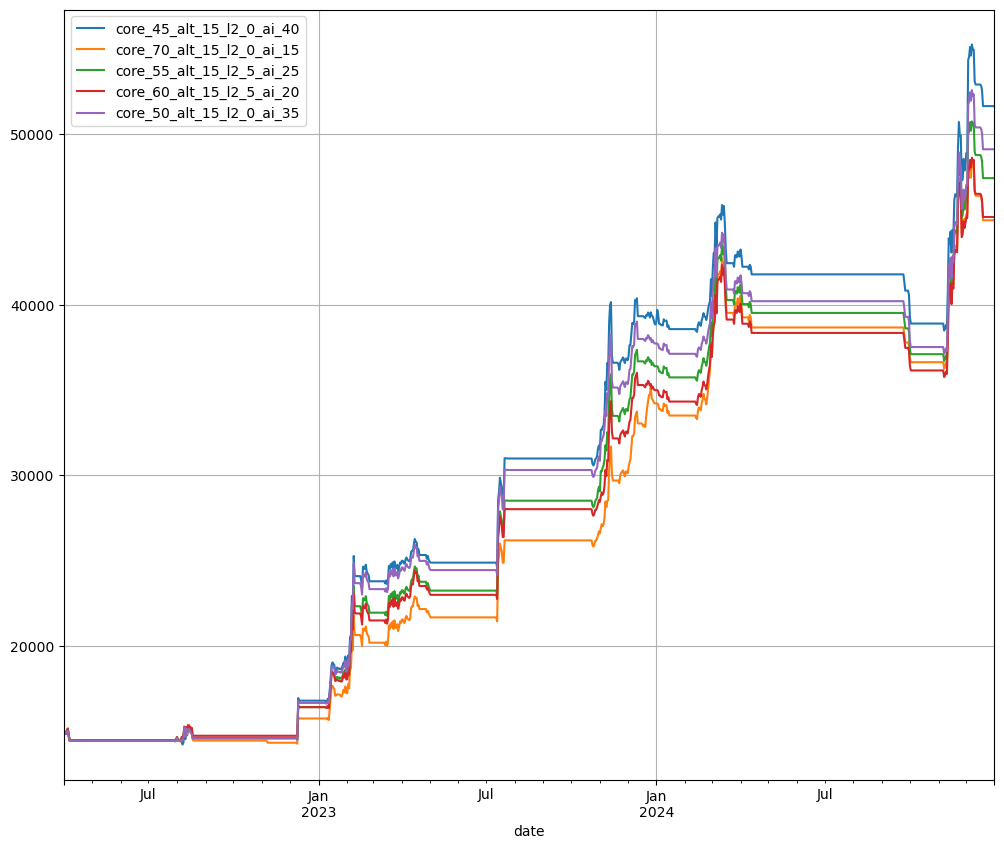

In [88]:
df_core_45_alt_15_l2_0_ai_40['total_portfolio_value'].plot(figsize=(12,10), label='core_45_alt_15_l2_0_ai_40', legend=True)
df_core_70_alt_15_l2_0_ai_15['total_portfolio_value'].plot(figsize=(12,10), label='core_70_alt_15_l2_0_ai_15', legend=True)
df_core_55_alt_15_l2_5_ai_25['total_portfolio_value'].plot(figsize=(12,10), label='core_55_alt_15_l2_5_ai_25', legend=True)
df_core_60_alt_15_l2_5_ai_20['total_portfolio_value'].plot(figsize=(12,10), label='core_60_alt_15_l2_5_ai_20', legend=True)
df_core_50_alt_15_l2_0_ai_35['total_portfolio_value'].plot(figsize=(12,10), label='core_50_alt_15_l2_0_ai_35', legend=True, grid=True)

<Axes: xlabel='date'>

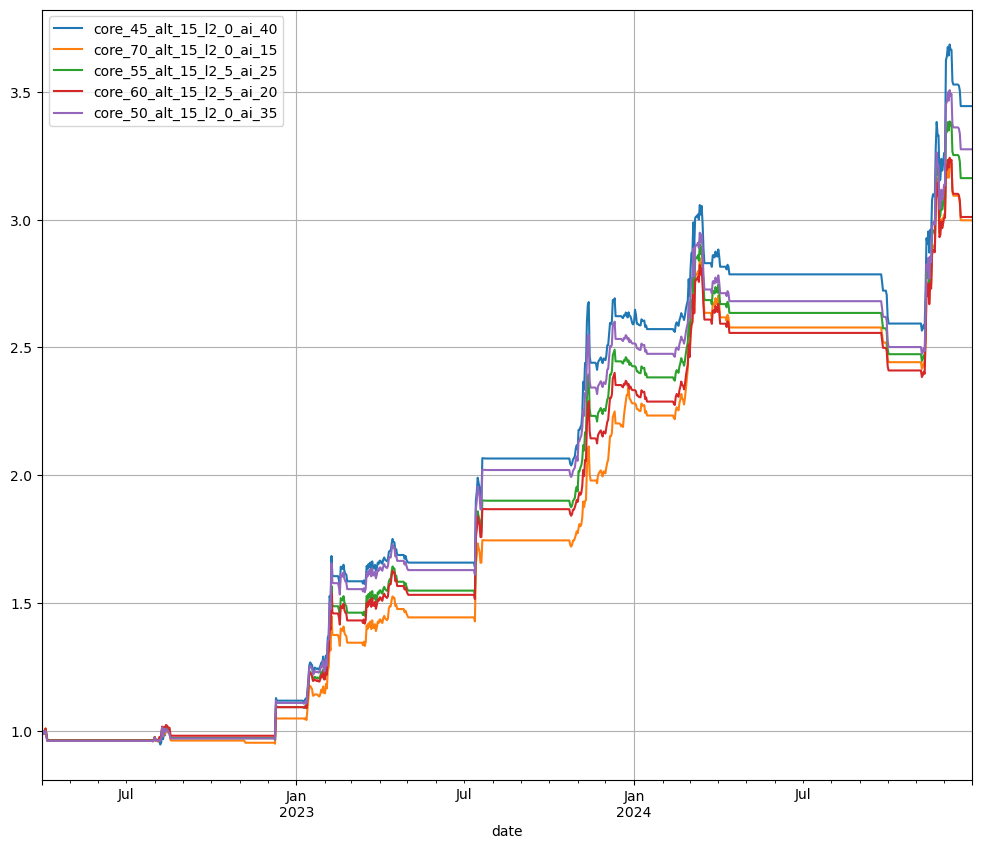

In [89]:
df_core_45_alt_15_l2_0_ai_40['equity_curve'].plot(figsize=(12,10), label='core_45_alt_15_l2_0_ai_40', legend=True)
df_core_70_alt_15_l2_0_ai_15['equity_curve'].plot(figsize=(12,10), label='core_70_alt_15_l2_0_ai_15', legend=True)
df_core_55_alt_15_l2_5_ai_25['equity_curve'].plot(figsize=(12,10), label='core_55_alt_15_l2_5_ai_25', legend=True)
df_core_60_alt_15_l2_5_ai_20['equity_curve'].plot(figsize=(12,10), label='core_60_alt_15_l2_5_ai_20', legend=True)
df_core_50_alt_15_l2_0_ai_35['equity_curve'].plot(figsize=(12,10), label='core_50_alt_15_l2_0_ai_35', legend=True, grid=True)

## Out of Sample Performance for Different Sleeve Weights

In [105]:
## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2025-01-01').date()
end_date_test   = pd.Timestamp('2025-10-31').date()

## Sleeve Weights
w_core = 0.45
w_alt = 0.15
w_l2 = 0.00
w_ai = 0.40

tv = 1.2
df_core_45_alt_15_l2_0_ai_40_os, port_metrics_core_45_alt_15_l2_0_ai_40_os, sleeve_metrics_core_45_alt_15_l2_0_ai_40_os = run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn=fn,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    total_initial_capital=total_initial_capital,
    expanded_ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    warmup_days=warmup_days,
)

## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2025-01-01').date()
end_date_test   = pd.Timestamp('2025-10-31').date()

## Sleeve Weights
w_core = 0.70
w_alt = 0.15
w_l2 = 0.00
w_ai = 0.15

tv = 1.2
df_core_70_alt_15_l2_0_ai_15_os, port_metrics_core_70_alt_15_l2_0_ai_15_os, sleeve_metrics_core_70_alt_15_l2_0_ai_15_os = run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn=fn,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    total_initial_capital=total_initial_capital,
    expanded_ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    warmup_days=warmup_days,
)

## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2025-01-01').date()
end_date_test   = pd.Timestamp('2025-10-31').date()

## Sleeve Weights
w_core = 0.55
w_alt = 0.15
w_l2 = 0.05
w_ai = 0.25

tv = 1.2
df_core_55_alt_15_l2_5_ai_25_os, port_metrics_core_55_alt_15_l2_5_ai_25_os, sleeve_metrics_core_55_alt_15_l2_5_ai_25_os = run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn=fn,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    total_initial_capital=total_initial_capital,
    expanded_ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    warmup_days=warmup_days,
)

## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2025-01-01').date()
end_date_test   = pd.Timestamp('2025-10-31').date()

## Sleeve Weights
w_core = 0.60
w_alt = 0.15
w_l2 = 0.05
w_ai = 0.20

tv = 1.2
df_core_60_alt_15_l2_5_ai_20_os, port_metrics_core_60_alt_15_l2_5_ai_20_os, sleeve_metrics_core_60_alt_15_l2_5_ai_20_os = run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn=fn,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    total_initial_capital=total_initial_capital,
    expanded_ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    warmup_days=warmup_days,
)

## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2025-01-01').date()
end_date_test   = pd.Timestamp('2025-10-31').date()

## Sleeve Weights
w_core = 0.50
w_alt = 0.15
w_l2 = 0.00
w_ai = 0.35

tv = 1.2
df_core_50_alt_15_l2_0_ai_35_os, port_metrics_core_50_alt_15_l2_0_ai_35_os, sleeve_metrics_core_50_alt_15_l2_0_ai_35_os = run_sleeve_performance_with_single_weight(
    w_core, w_alt, w_l2, w_ai,
    fn=fn,
    start_date_test=start_date_test,
    end_date_test=end_date_test,
    total_initial_capital=total_initial_capital,
    expanded_ticker_list=expanded_ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=long_only,
    price_or_returns_calc=price_or_returns_calc,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=tv,
    annual_trading_days=annual_trading_days,
    warmup_days=warmup_days,
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
O

<Axes: xlabel='date'>

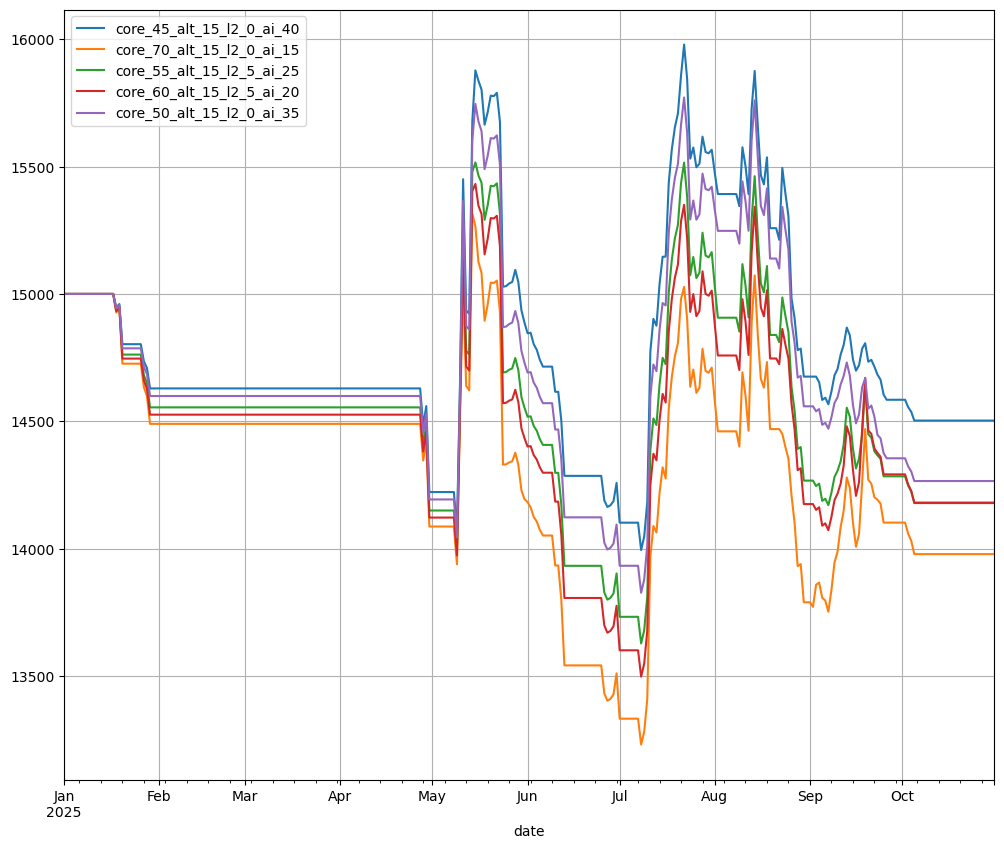

In [106]:
df_core_45_alt_15_l2_0_ai_40_os['total_portfolio_value'].plot(figsize=(12,10), label='core_45_alt_15_l2_0_ai_40', legend=True)
df_core_70_alt_15_l2_0_ai_15_os['total_portfolio_value'].plot(figsize=(12,10), label='core_70_alt_15_l2_0_ai_15', legend=True)
df_core_55_alt_15_l2_5_ai_25_os['total_portfolio_value'].plot(figsize=(12,10), label='core_55_alt_15_l2_5_ai_25', legend=True)
df_core_60_alt_15_l2_5_ai_20_os['total_portfolio_value'].plot(figsize=(12,10), label='core_60_alt_15_l2_5_ai_20', legend=True)
df_core_50_alt_15_l2_0_ai_35_os['total_portfolio_value'].plot(figsize=(12,10), label='core_50_alt_15_l2_0_ai_35', legend=True, grid=True)

<Axes: xlabel='date'>

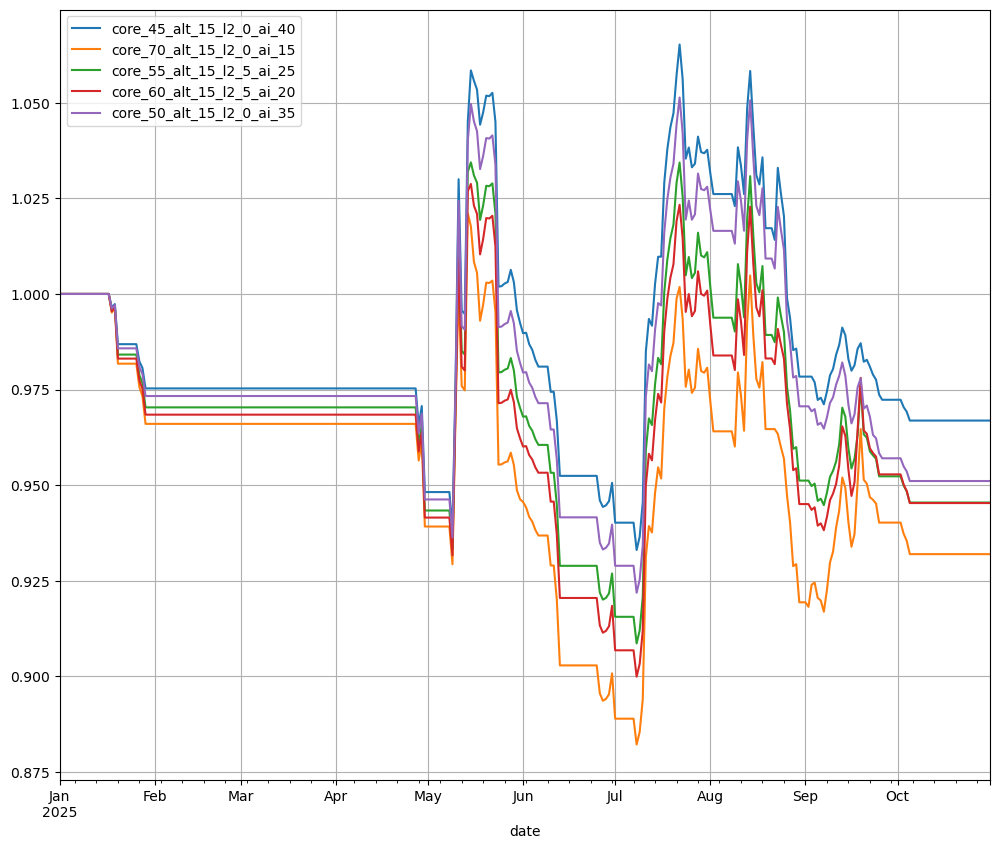

In [107]:
df_core_45_alt_15_l2_0_ai_40_os['equity_curve'].plot(figsize=(12,10), label='core_45_alt_15_l2_0_ai_40', legend=True)
df_core_70_alt_15_l2_0_ai_15_os['equity_curve'].plot(figsize=(12,10), label='core_70_alt_15_l2_0_ai_15', legend=True)
df_core_55_alt_15_l2_5_ai_25_os['equity_curve'].plot(figsize=(12,10), label='core_55_alt_15_l2_5_ai_25', legend=True)
df_core_60_alt_15_l2_5_ai_20_os['equity_curve'].plot(figsize=(12,10), label='core_60_alt_15_l2_5_ai_20', legend=True)
df_core_50_alt_15_l2_0_ai_35_os['equity_curve'].plot(figsize=(12,10), label='core_50_alt_15_l2_0_ai_35', legend=True, grid=True)

In [108]:
print(port_metrics_core_45_alt_15_l2_0_ai_40_os)
print(port_metrics_core_70_alt_15_l2_0_ai_15_os)
print(port_metrics_core_55_alt_15_l2_5_ai_25_os)
print(port_metrics_core_60_alt_15_l2_5_ai_20_os)
print(port_metrics_core_50_alt_15_l2_0_ai_35_os)

{'annualized_return': -0.03964101409940468, 'annualized_sharpe_ratio': -0.5300264300890808, 'calmar_ratio': -0.3344026050989417, 'annualized_std_dev': 0.26434829887616507, 'max_drawdown': -0.11854277895854266, 'max_drawdown_duration': Timedelta('129 days 00:00:00'), 'hit_rate': 0.17105263157894737, 't_statistic': -0.1828203696187479, 'p_value': 0.8550612292330148, 'trade_count': 64.0, 'w_core': 0.45, 'w_alt': 0.15, 'w_l2': 0.0, 'w_ai': 0.4}
{'annualized_return': -0.08116079695395573, 'annualized_sharpe_ratio': -0.8511134545914553, 'calmar_ratio': -0.5964923423639155, 'annualized_std_dev': 0.2502500033920363, 'max_drawdown': -0.1360634348335693, 'max_drawdown_duration': Timedelta('170 days 00:00:00'), 'hit_rate': 0.15789473684210525, 't_statistic': -0.46882846255306965, 'p_value': 0.6395293814789992, 'trade_count': 64.0, 'w_core': 0.7, 'w_alt': 0.15, 'w_l2': 0.0, 'w_ai': 0.15}
{'annualized_return': -0.06515411381958747, 'annualized_sharpe_ratio': -0.7271466865102936, 'calmar_ratio': -0.

In [ ]:
sleeve_metrics_core_45_alt_15_l2_0_ai_40_os

In [ ]:
sleeve_metrics_core_70_alt_15_l2_0_ai_15_os

In [ ]:
sleeve_metrics_core_55_alt_15_l2_5_ai_25_os

In [ ]:
sleeve_metrics_core_60_alt_15_l2_5_ai_20_os

In [ ]:
sleeve_metrics_core_50_alt_15_l2_0_ai_35_os

In [ ]:
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in expanded_ticker_list]
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_ticker_list]
df_core_50_alt_15_l2_0_ai_35_os[daily_pnl_cols].plot(figsize=(12,10), grid=True)

In [ ]:
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in expanded_ticker_list]
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_ticker_list]
df_core_50_alt_15_l2_0_ai_35[daily_pnl_cols].plot(figsize=(12,10), grid=True)

In [ ]:
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in expanded_ticker_list]
df_core_45_alt_15_l2_0_ai_40_os[vol_adj_signal_cols].plot(figsize=(12,10), grid=True)

In [ ]:
pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_ticker_list]
df_core_50_alt_15_l2_0_ai_35_os[pnl_cols].plot(figsize=(12,10), grid=True)

In [ ]:
pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_ticker_list]
df_core_45_alt_15_l2_0_ai_40_os[pnl_cols].plot(figsize=(12,10), grid=True)

In [ ]:
df_core_50_alt_15_l2_0_ai_35_os.head()

## Target Volatility Test for Final Config

In [ ]:
## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

## Sleeve Weights
w_core = 0.50
w_alt = 0.15
w_l2 = 0.00
w_ai = 0.35

port_metrics_dict = {}
sleeve_metrics_dict = {}

tv = 1.2
for tv in [0.50, 0.60, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4]:
    df_core_50_alt_15_l2_0_ai_35_tv, port_metrics_core_50_alt_15_l2_0_ai_35_tv, sleeve_metrics_core_50_alt_15_l2_0_ai_35_tv = run_sleeve_performance_with_single_weight(
        w_core, w_alt, w_l2, w_ai,
        fn=fn,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
        total_initial_capital=total_initial_capital,
        expanded_ticker_list=expanded_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=tv,
        annual_trading_days=annual_trading_days,
        warmup_days=warmup_days,
    )
    port_metrics_dict[tv] = port_metrics_core_50_alt_15_l2_0_ai_35_tv
    sleeve_metrics_dict[tv] = sleeve_metrics_core_50_alt_15_l2_0_ai_35_tv

In [ ]:
port_metrics_dict

In [ ]:
sleeve_metrics_dict

In [ ]:
df_core_50_alt_15_l2_0_ai_35_tv['ICP-USD_daily_pnl'].plot(figsize=(12,10))

## Out of Sample Performance with Target Volatility of 0.8 for Config 5

In [ ]:
cfg_v2 = load_prod_strategy_config(strategy_version='v0.2.0')

In [ ]:
cfg_v2

In [ ]:
expanded_ticker_list = cfg_v2['universe']['tickers']

In [ ]:
expanded_ticker_list_temp = [x for x in expanded_ticker_list if x != 'ICP-USD']

In [ ]:
expanded_ticker_list_temp

In [ ]:
expanded_ticker_list

In [ ]:
## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2025-01-01').date()
end_date_test   = pd.Timestamp('2025-11-30').date()

## Sleeve Weights
w_core = 0.50
w_alt = 0.15
w_l2 = 0.00
w_ai = 0.35

port_metrics_dict_os = {}
sleeve_metrics_dict_os = {}

tv = 1.2
for tv in [0.8]:
    df_core_50_alt_15_l2_0_ai_35_tv_os, port_metrics_core_50_alt_15_l2_0_ai_35_tv_os, sleeve_metrics_core_50_alt_15_l2_0_ai_35_tv_os = run_sleeve_performance_with_single_weight(
        w_core, w_alt, w_l2, w_ai,
        fn=fn,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
        total_initial_capital=total_initial_capital,
        expanded_ticker_list=expanded_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=tv,
        annual_trading_days=annual_trading_days,
        warmup_days=warmup_days,
    )
    port_metrics_dict_os[tv] = port_metrics_core_50_alt_15_l2_0_ai_35_tv_oss
    sleeve_metrics_dict_os[tv] = sleeve_metrics_core_50_alt_15_l2_0_ai_35_tv_oss

In [ ]:
port_metrics_dict_os

In [ ]:
sleeve_metrics_dict_os[0.8]

In [ ]:
df_core_50_alt_15_l2_0_ai_35_tv_os['total_portfolio_value'].plot(figsize=(8,6))

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_ticker_list]
df_core_50_alt_15_l2_0_ai_35_tv_os[daily_pnl_cols].plot(figsize=(12,10))

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_ticker_list]
df_core_50_alt_15_l2_0_ai_35_tv_os['ICP-USD_daily_pnl'].plot(figsize=(12,10))

In [ ]:
def run_sleeve_performance_with_single_weight_wo_ICP(
    w_core, w_alt, w_l2, w_ai,
    fn,
    start_date_test,
    end_date_test,
    total_initial_capital,
    expanded_ticker_list,
    # strategy params
    fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
    entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
    ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
    rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit, r2_smooth_window, r2_confirm_days,
    log_std_window, coef_of_variation_window, vol_of_vol_z_score_window, vol_of_vol_p_min,
    r2_strong_threshold, use_activation, tanh_activation_constant_dict, moving_avg_type,
    long_only, price_or_returns_calc, rolling_cov_window, volatility_window,
    rolling_atr_window, atr_multiplier, transaction_cost_est, passive_trade_rate,
    notional_threshold_pct, cooldown_counter_threshold, use_coinbase_data,
    saved_file_end_date, rolling_sharpe_window, cash_buffer_percentage,
    annualized_target_volatility, annual_trading_days, warmup_days,
):
    # ----- sleeve definition (tickers + budgets for this run) -----
    l1_core_tickers = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']
    # l1_alt_tickers  = ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD']
    l1_alt_tickers  = ['CRO-USD', 'XTZ-USD', 'FIL-USD']
    l2_tickers      = ['SKL-USD', 'IMX-USD', 'LRC-USD', 'STX-USD']
    ai_tickers      = ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD']

    sleeves = {
        "L1_Core": l1_core_tickers,
        "L1_Alt":  l1_alt_tickers,
        "L2":      l2_tickers,
        "AI":      ai_tickers,
    }

    target_risk_budget = {
        "L1_Core": float(np.round(w_core, 2)),
        "L1_Alt":  float(np.round(w_alt, 2)),
        "L2":      float(np.round(w_l2, 2)),
        "AI":      float(np.round(w_ai, 2)),
    }

    # sleeve_budgets dict used by the sizer (includes tickers + weights)
    sleeve_budgets = {
        s: {"tickers": sleeves[s], "weight": target_risk_budget[s]} for s in sleeves
    }

    # ----- 1) run the full backtest -----
    df = fn(
        start_date=start_date_test - pd.Timedelta(days=warmup_days),
        end_date=end_date_test,
        ticker_list=expanded_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        initial_capital=total_initial_capital,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=True,
        signal_start_date=start_date_test,
        sleeve_budgets=sleeve_budgets,
    )

    # ----- 2) cut warmup -----
    df = df[df.index >= pd.Timestamp(start_date_test)]

    # ----- 3) add asset-level + portfolio returns -----
    df = perf.calculate_asset_level_returns(df, end_date_test, expanded_ticker_list)

    # ----- 4) portfolio-level metrics -----
    port_metrics = calculate_risk_and_performance_metrics(
        df,
        strategy_daily_return_col="portfolio_daily_pct_returns",
        strategy_trade_count_col="count_of_positions",
        include_transaction_costs_and_fees=False,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_trading_days=annual_trading_days,
    )
    port_metrics.update({
        "w_core": w_core,
        "w_alt":  w_alt,
        "w_l2":   w_l2,
        "w_ai":   w_ai,
    })

    # ----- 5) sleeve-level metrics -----
    df_sleeves = add_sleeve_series(
        df,
        sleeves=sleeves,
        target_risk_budget=target_risk_budget,
        budget_band=0.20,
        strategy_trade_count_col="count_of_positions",
    )

    sleeve_metrics = summarize_sleeves_with_user_metrics(
        df_sleeves,
        sleeves=sleeves,
        target_risk_budget=target_risk_budget,
        include_transaction_costs_and_fees=False,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        annual_rf=0.05,
        annual_trading_days=annual_trading_days,
    )

    # tag the run weights on the sleeve table too
    sleeve_metrics["w_core"] = w_core
    sleeve_metrics["w_alt"]  = w_alt
    sleeve_metrics["w_l2"]   = w_l2
    sleeve_metrics["w_ai"]   = w_ai

    return df, port_metrics, sleeve_metrics


In [ ]:
## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test   = pd.Timestamp('2024-12-31').date()

## Sleeve Weights
w_core = 0.50
w_alt = 0.15
w_l2 = 0.00
w_ai = 0.35

fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt

expanded_ticker_list_temp = [x for x in expanded_ticker_list if x != 'ICP-USD']

port_metrics_dict_is_wo_ICP = {}
sleeve_metrics_dict_is_wo_ICP = {}

tv = 1.2
for tv in [0.8]:
    df_core_50_alt_15_l2_0_ai_35_tv_is_wo_ICP, port_metrics_core_50_alt_15_l2_0_ai_35_tv_is_wo_ICP, sleeve_metrics_core_50_alt_15_l2_0_ai_35_tv_is_wo_ICP = run_sleeve_performance_with_single_weight_wo_ICP(
        w_core, w_alt, w_l2, w_ai,
        fn=fn,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
        total_initial_capital=total_initial_capital,
        expanded_ticker_list=expanded_ticker_list_temp,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=tv,
        annual_trading_days=annual_trading_days,
        warmup_days=warmup_days,
    )
    port_metrics_dict_is_wo_ICP[tv] = port_metrics_core_50_alt_15_l2_0_ai_35_tv_is_wo_ICP
    sleeve_metrics_dict_is_wo_ICP[tv] = sleeve_metrics_core_50_alt_15_l2_0_ai_35_tv_is_wo_ICP

In [ ]:
port_metrics_dict_is_wo_ICP

In [ ]:
sleeve_metrics_dict_is_wo_ICP[0.8]

In [ ]:
df_core_50_alt_15_l2_0_ai_35_tv_is_wo_ICP['total_portfolio_value'].plot(figsize=(8,6))

In [ ]:
## This Optimization for Sleeve Weights is being run at a Target Volatility of 120%
total_initial_capital = 15000
start_date_test = pd.Timestamp('2025-01-01').date()
end_date_test   = pd.Timestamp('2025-11-30').date()

## Sleeve Weights
w_core = 0.50
w_alt = 0.15
w_l2 = 0.00
w_ai = 0.35

fn = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt

expanded_ticker_list_temp = [x for x in expanded_ticker_list if x != 'ICP-USD']

port_metrics_dict_os_wo_ICP = {}
sleeve_metrics_dict_os_wo_ICP = {}

tv = 1.2
for tv in [0.8]:
    df_core_50_alt_15_l2_0_ai_35_tv_os_wo_ICP, port_metrics_core_50_alt_15_l2_0_ai_35_tv_os_wo_ICP, sleeve_metrics_core_50_alt_15_l2_0_ai_35_tv_os_wo_ICP = run_sleeve_performance_with_single_weight_wo_ICP(
        w_core, w_alt, w_l2, w_ai,
        fn=fn,
        start_date_test=start_date_test,
        end_date_test=end_date_test,
        total_initial_capital=total_initial_capital,
        expanded_ticker_list=expanded_ticker_list_temp,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        rolling_cov_window=rolling_cov_window,
        volatility_window=volatility_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        cooldown_counter_threshold=cooldown_counter_threshold,
        use_coinbase_data=use_coinbase_data,
        saved_file_end_date=saved_file_end_date,
        rolling_sharpe_window=rolling_sharpe_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=tv,
        annual_trading_days=annual_trading_days,
        warmup_days=warmup_days,
    )
    port_metrics_dict_os_wo_ICP[tv] = port_metrics_core_50_alt_15_l2_0_ai_35_tv_os_wo_ICP
    sleeve_metrics_dict_os_wo_ICP[tv] = sleeve_metrics_core_50_alt_15_l2_0_ai_35_tv_os_wo_ICP

In [ ]:
port_metrics_dict_os

In [ ]:
port_metrics_dict_os_wo_ICP

In [ ]:
sleeve_metrics_dict_os_wo_ICP[0.8]

In [ ]:
df_core_50_alt_15_l2_0_ai_35_tv_os['total_portfolio_value'].plot(figsize=(8,6), label='With ICP', legend=True)
df_core_50_alt_15_l2_0_ai_35_tv_os_wo_ICP['total_portfolio_value'].plot(figsize=(8,6), label='Without ICP', legend=True)

### Coin Level Stats

In [ ]:
core_name = "core_L1_run1"
core_df = sleeves[core_name]
core_ret = core_df["portfolio_daily_pct_returns"]  # core portfolio return series

def compute_coin_level_stats(df_run, ticker_list, sleeve_name,
                             core_ret, ret_suffix=ASSET_RET_SUFFIX,
                             ann_days=ANN_DAYS, annual_rf=0.05):
    """
    df_run: backtest DF for a sleeve
    ticker_list: tickers in this run
    sleeve_name: name for this sleeve (for tracking)
    core_ret: Series of core portfolio daily returns
    """
    daily_rf = (1 + annual_rf) ** (1/ann_days) - 1
    rows = []
    for t in ticker_list:
        col = f"{t}{ret_suffix}"
        if col not in df_run.columns:
            continue
        r = df_run[col].dropna()
        if r.empty:
            continue

        mu = (r - daily_rf).mean()
        sig = (r - daily_rf).std()
        ann_ret = mu * ann_days
        ann_vol = sig * np.sqrt(ann_days)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
        hit_rate = (r > 0).mean()
        trade_count = (r != 0).sum()  # rough; you have more detailed trade info if needed

        aligned = pd.concat([r, core_ret], axis=1, join="inner").dropna()
        corr_to_core = aligned.iloc[:, 0].corr(aligned.iloc[:, 1]) if len(aligned) > 1 else np.nan

        rows.append({
            "ticker": t,
            "sleeve": sleeve_name,
            "ann_return": ann_ret,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
            "hit_rate": hit_rate,
            "trade_count": trade_count,
            "corr_to_core": corr_to_core,
        })

    return pd.DataFrame(rows)


In [ ]:
core_ret

In [ ]:
coin_stats_list = []

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["core_L1_run1"],
        ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
        sleeve_name="core_L1_run1",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["L1_run2"],
        ticker_list=['DOGE-USD','LTC-USD','DOT-USD','ALGO-USD','XLM-USD'],
        sleeve_name="L1_run2",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["L1_run3"],
        ticker_list=['ATOM-USD','ICP-USD','XTZ-USD','FIL-USD','CRO-USD'],
        sleeve_name="L1_run3",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["L2_run1"],
        ticker_list=['SKL-USD','LRC-USD','IMX-USD','STX-USD'],
        sleeve_name="L2_run1",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run1"],
        ticker_list=['SHIB-USD','LINK-USD','UNI-USD','FET-USD','AAVE-USD'],
        sleeve_name="DeFi_run1",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run2"],
        ticker_list=['MANA-USD','OXT-USD','KRL-USD','AMP-USD','REQ-USD'],
        sleeve_name="DeFi_run2",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run3"],
        ticker_list=['GRT-USD','COMP-USD','MKR-USD','SNX-USD','SUSHI-USD'],
        sleeve_name="DeFi_run3",
        core_ret=core_ret,
    )
)

coin_stats_list.append(
    compute_coin_level_stats(
        df_run=sleeves["DeFi_run4"],
        ticker_list=['CRV-USD','BAL-USD','1INCH-USD','DIA-USD'],
        sleeve_name="DeFi_run4",
        core_ret=core_ret,
    )
)

coin_stats = pd.concat(coin_stats_list, ignore_index=True)


In [ ]:
defi_ticker_list = ['SHIB-USD','LINK-USD','UNI-USD','FET-USD','AAVE-USD']
defi_ticker_list_2 = ['MANA-USD','OXT-USD','KRL-USD','AMP-USD','REQ-USD']
defi_ticker_list_3 = ['GRT-USD','COMP-USD','MKR-USD','SNX-USD','SUSHI-USD']
defi_ticker_list_4 = ['CRV-USD','BAL-USD','1INCH-USD','DIA-USD']

In [ ]:
coin_stats_list

In [ ]:
coin_stats

### Picking Coins to Trade Alongside Core Portfolio of L1 Coins

In [ ]:
core_tickers = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']

coin_stats["is_core"] = coin_stats["ticker"].isin(core_tickers)

LAMBDA = 0.5  # penalty for correlation to core
coin_stats["score"] = coin_stats["sharpe"] - LAMBDA * coin_stats["corr_to_core"]

# Non-core candidates with basic quality filters
alt_candidates = coin_stats[
    (~coin_stats["is_core"]) &
    (coin_stats["sharpe"] > 0) &
    (coin_stats["trade_count"] >= 30)
].copy()

alt_candidates = alt_candidates.sort_values("score", ascending=False)

K = 8  # eg: start with top 8 alts
alt_universe_static = alt_candidates["ticker"].unique().tolist()[:K]

print("Static alt universe:", alt_universe_static)


In [ ]:
core_tickers + alt_universe_static

In [ ]:
coin_stats

In [ ]:
alt_candidates

In [ ]:
sleeve_ret.head()

In [ ]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
# defi_ticker_list_4 = ['CRV-USD','BAL-USD','1INCH-USD','DIA-USD']
expanded_universe_list = core_tickers + alt_universe_static
df_final_prod_config_backtested_expanded_alt_universe = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=expanded_universe_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_expanded_alt_universe = df_final_prod_config_backtested_expanded_alt_universe[df_final_prod_config_backtested_expanded_alt_universe.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_expanded_alt_universe = perf.calculate_asset_level_returns(df_final_prod_config_backtested_expanded_alt_universe, end_date_test, expanded_universe_list)

portfolio_perf_metrics_expanded_alt_universe = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_expanded_alt_universe, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                      strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_expanded_alt_universe

In [ ]:
df_final_prod_config_backtested_expanded_alt_universe['total_portfolio_value'].plot(figsize=(8,6))

In [ ]:
df_final_prod_config_backtested_expanded_alt_universe['equity_curve'].plot(figsize=(8,6))

In [ ]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe[final_signal_cols].plot(figsize=(8,6))

In [ ]:
## Higher Vol Target (0.90)
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
# defi_ticker_list_4 = ['CRV-USD','BAL-USD','1INCH-USD','DIA-USD']
expanded_universe_list = core_tickers + alt_universe_static
df_final_prod_config_backtested_expanded_alt_universe_higher_vol = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=expanded_universe_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=0.90,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_expanded_alt_universe_higher_vol = df_final_prod_config_backtested_expanded_alt_universe_higher_vol[df_final_prod_config_backtested_expanded_alt_universe_higher_vol.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_expanded_alt_universe_higher_vol = perf.calculate_asset_level_returns(df_final_prod_config_backtested_expanded_alt_universe_higher_vol, end_date_test, expanded_universe_list)

portfolio_perf_metrics_expanded_alt_universe_higher_vol = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_expanded_alt_universe_higher_vol, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                                 strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_expanded_alt_universe_higher_vol

In [ ]:
df_final_prod_config_backtested_expanded_alt_universe_higher_vol['total_portfolio_value'].plot(figsize=(8,6))

In [ ]:
df_final_prod_config_backtested_expanded_alt_universe_higher_vol['equity_curve'].plot(figsize=(8,6))

daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe_higher_vol[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in expanded_universe_list]
df_final_prod_config_backtested_expanded_alt_universe_higher_vol[final_signal_cols].plot(figsize=(8,6))

### Rolling Sharpe & Performance Driven Alt Ticker Selection

In [ ]:
sleeves.keys()

In [ ]:
# Start from one sleeve and outer-join others
df_all = None
for name, df in sleeves.items():
    print(name)
    if name == 'L1_large':
        continue
    else:
        asset_cols = [c for c in df.columns if c.endswith(ASSET_RET_SUFFIX) and c != 'portfolio_daily_pct_returns']
        sub = df[asset_cols]
        if df_all is None:
            df_all = sub.copy()
        else:
            if ('ADA-USD_daily_pct_returns' in df_all.columns) & ('ADA-USD_daily_pct_returns' in sub.columns):
                sub = sub.drop(['ADA-USD_daily_pct_returns'], axis=1)
            df_all = df_all.join(sub, how="outer")
        
df_all = df_all.sort_index()
all_tickers = sorted({c.replace(ASSET_RET_SUFFIX, "") for c in df_all.columns})


In [ ]:
all_tickers

In [ ]:
def compute_rolling_coin_sharpe(df, ticker_list,
                                window_days=180,
                                ret_suffix=ASSET_RET_SUFFIX,
                                ann_days=ANN_DAYS, annual_rf=0.05):
    """
    Returns a MultiIndex Series: index=(date, ticker), value=rolling Sharpe.
    """
    daily_rf = (1 + annual_rf) ** (1/ann_days) - 1
    frames = []
    for t in ticker_list:
        col = f"{t}{ret_suffix}"
        if col not in df.columns:
            continue
        r = df[col].dropna()
        if r.empty:
            continue
        
        excess_returns = r - daily_rf
        roll_mu = excess_returns.rolling(window_days).mean()
        roll_sig = excess_returns.rolling(window_days).std()
        roll_sharpe = (roll_mu / roll_sig) * np.sqrt(ann_days)

        s = roll_sharpe.to_frame("rolling_sharpe")
        s["ticker"] = t
        frames.append(s)

    out = pd.concat(frames)
    out = out.reset_index().set_index(["date", "ticker"]).sort_index()
    out.index.names = ["date", "ticker"]
    out = out.replace([np.inf, -np.inf], np.nan)
    return out["rolling_sharpe"]

rolling_sharpe = compute_rolling_coin_sharpe(df_all, all_tickers, window_days=180)


In [ ]:
rolling_sharpe

In [ ]:
def build_alt_universe_by_month(rolling_sharpe,
                                core_tickers,
                                sharpe_threshold=0.0,
                                max_alts=8):
    """
    rolling_sharpe: Series indexed by (date, ticker)
    """
    alt_universe_by_month = {}

    dates = rolling_sharpe.index.get_level_values("date")
    month_ends = pd.to_datetime(dates).to_period("M").to_timestamp("M").unique()

    for me in month_ends:
        try:
            rs_me = rolling_sharpe.xs(me, level="date")
        except KeyError:
            continue

        rs_df = rs_me.reset_index()
        rs_df = rs_df[~rs_df["ticker"].isin(core_tickers)]

        # Filter by Sharpe threshold
        rs_df = rs_df[rs_df["rolling_sharpe"] > sharpe_threshold]

        rs_df = rs_df.sort_values("rolling_sharpe", ascending=False)
        selected = rs_df["ticker"].head(max_alts).tolist()
        alt_universe_by_month[me.date()] = selected

    return alt_universe_by_month

alt_universe_by_month = build_alt_universe_by_month(
    rolling_sharpe,
    core_tickers=core_tickers,
    sharpe_threshold=0.0,
    max_alts=8,
)

list(alt_universe_by_month.items())[:5]  # peek at first few months


In [ ]:
alt_universe_by_month

In [ ]:
dates = rolling_sharpe.index.get_level_values("date")
month_ends = pd.to_datetime(dates).to_period("M").to_timestamp("M").unique()
for me in month_ends:
    try:
        rs_me = rolling_sharpe.xs(me, level="date")
    except KeyError:
        continue

In [ ]:
rs_df = rs_me.reset_index()
rs_df = rs_df[~rs_df["ticker"].isin(core_tickers)]

In [ ]:
sharpe_threshold=0.0
max_alts = 8
# Filter by Sharpe threshold
rs_df = rs_df[rs_df["rolling_sharpe"] > sharpe_threshold]
rs_df = rs_df.sort_values("rolling_sharpe", ascending=False)

selected = rs_df["ticker"].head(max_alts).tolist()
alt_universe_by_month[me.date()] = selected

In [ ]:
selected

In [ ]:
rs_df

In [ ]:
rs_df

In [ ]:
month_ends

In [ ]:
me

In [ ]:
rs_me

## Sleeve Level Portfolio Optimization

In [ ]:
sleeves_for_opt = ["core_L1_run1", "L1_run2", "L1_run3", "DeFi_run1", "DeFi_run2"]

mu = sleeve_ret[sleeves_for_opt].mean() * ANN_DAYS        # annualized mean
cov = sleeve_ret[sleeves_for_opt].cov() * ANN_DAYS        # annualized cov

def sharpe_for_w(w, mu, cov):
    w = np.asarray(w)
    ann_ret = w @ mu.values
    ann_vol = np.sqrt(w @ cov.values @ w)
    return ann_ret / ann_vol

# simple constrained grid search over core weight & alt splits
best = None
for w_core in np.linspace(0.6, 0.9, 7):         # 0.60 ... 0.90
    remaining = 1 - w_core
    # split remaining evenly across selected alts for now
    k = len(sleeves_for_opt) - 1
    w_alt = remaining / k
    w = np.array([w_core] + [w_alt] * (k))
    s = sharpe_for_w(w, mu, cov)
    if (best is None) or (s > best[0]):
        best = (s, w)

best_sharpe, best_w = best
dict(zip(sleeves_for_opt, best_w)), best_sharpe


In [ ]:
sleeve_ret['core_L1_run1'].head()

## Prod Config Performance Monitoring

In [189]:
end_date

datetime.date(2025, 12, 18)

In [191]:
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=False, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 6.37019047575238,
 'annualized_sharpe_ratio': 2.301080223458465,
 'calmar_ratio': 46.8014163317845,
 'annualized_std_dev': 0.7985174665866076,
 'max_drawdown': -0.1361110619087431,
 'max_drawdown_duration': Timedelta('120 days 00:00:00'),
 'hit_rate': 0.24079528718703977,
 't_statistic': 4.531079799205928,
 'p_value': 6.384165723946264e-06,
 'trade_count': 289.0}

In [193]:
df_final_prod_config.tail(5)

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_20_avg_true_range_price,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_30,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_highest_high_56,SOL-USD_lowest_low_56,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_20_avg_true_range_price,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_30,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_highest_high_56,AVAX-USD_lowest_low_56,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_new_position_size,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,BTC-USD_daily_pnl,BTC-USD_daily_pct_returns,BTC-USD_position_count,ETH-USD_daily_pnl,ETH-USD_daily_pct_returns,ETH-USD_position_count,SOL-USD_daily_pnl,SOL-USD_daily_pct_returns,SOL-USD_position_count,ADA-USD_daily_pnl,

<Axes: xlabel='date'>

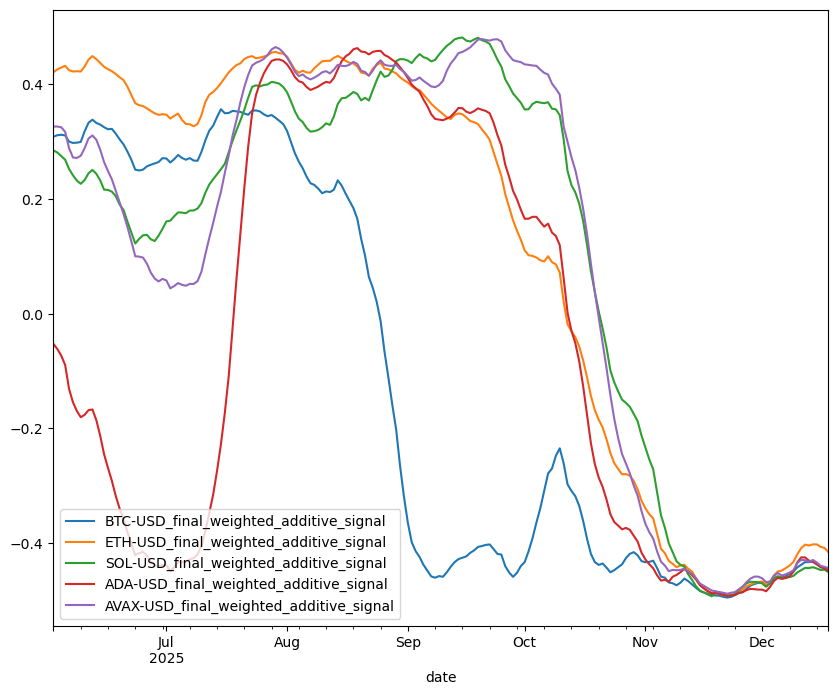

In [203]:
## Signal before Regime Filtering
raw_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][raw_signal_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

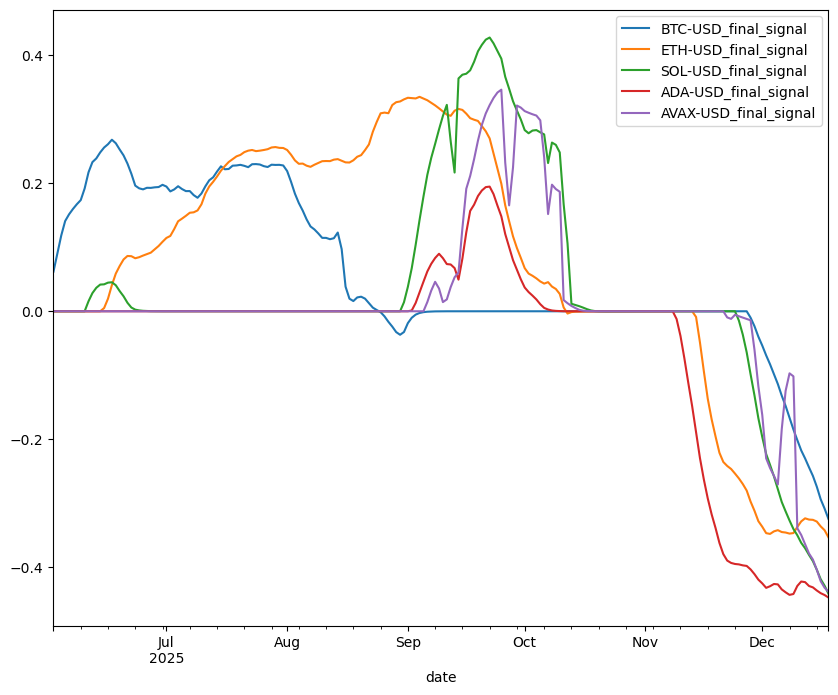

In [201]:
## Signal Before Volatility Adjusting
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][final_signal_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

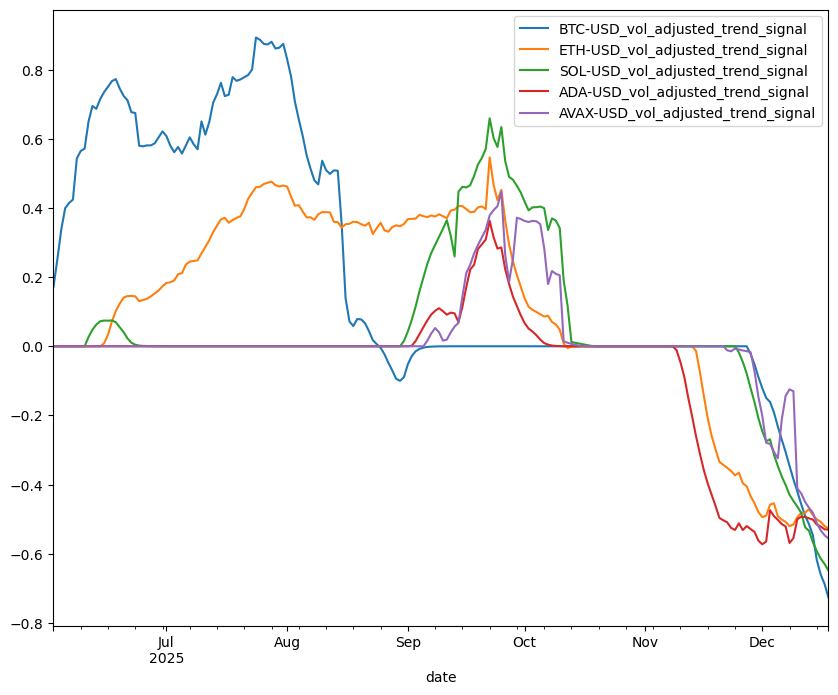

In [205]:
## Signal after Volatility Adjusting
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][vol_adj_signal_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

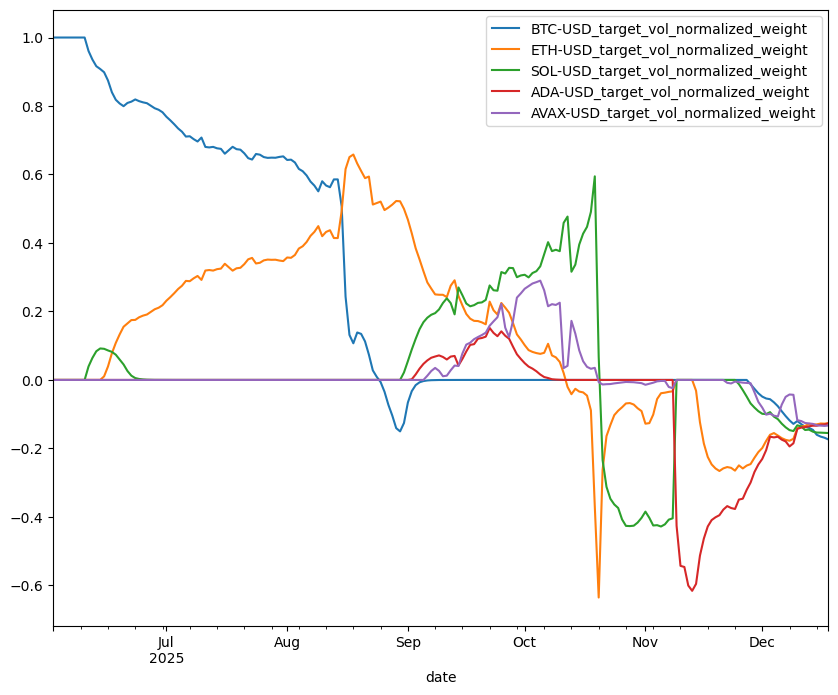

In [207]:
## Signal After Scaling for Cash, Risk Budgets and Target Volatility
target_vol_signal_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][target_vol_signal_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

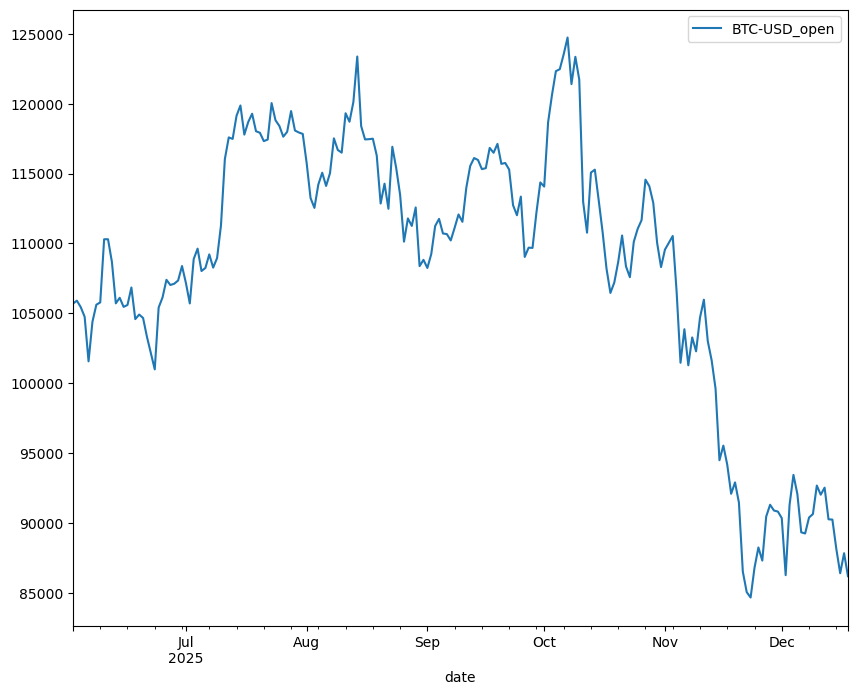

In [209]:
open_cols = [f'{ticker}_open' for ticker in ['BTC-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

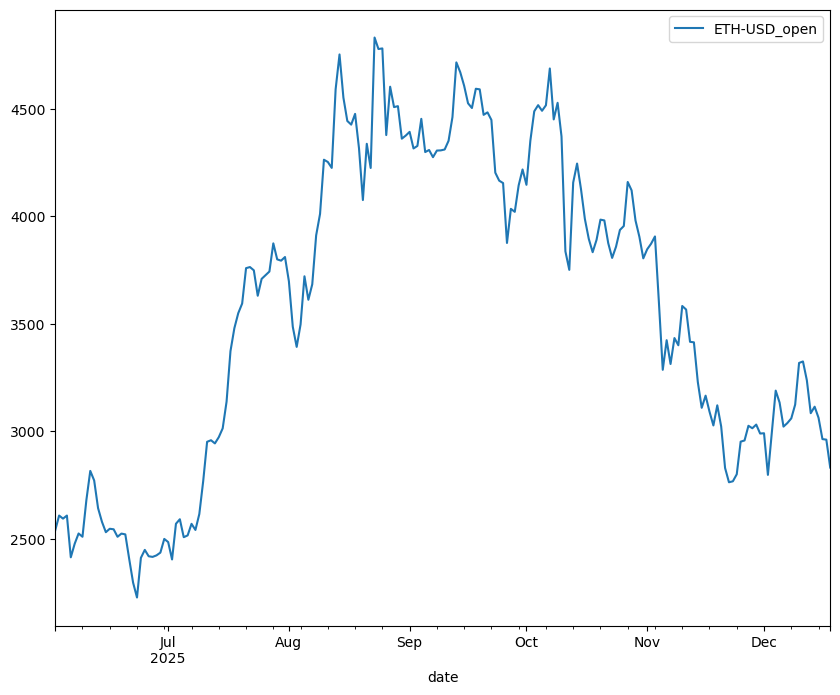

In [211]:
open_cols = [f'{ticker}_open' for ticker in ['ETH-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

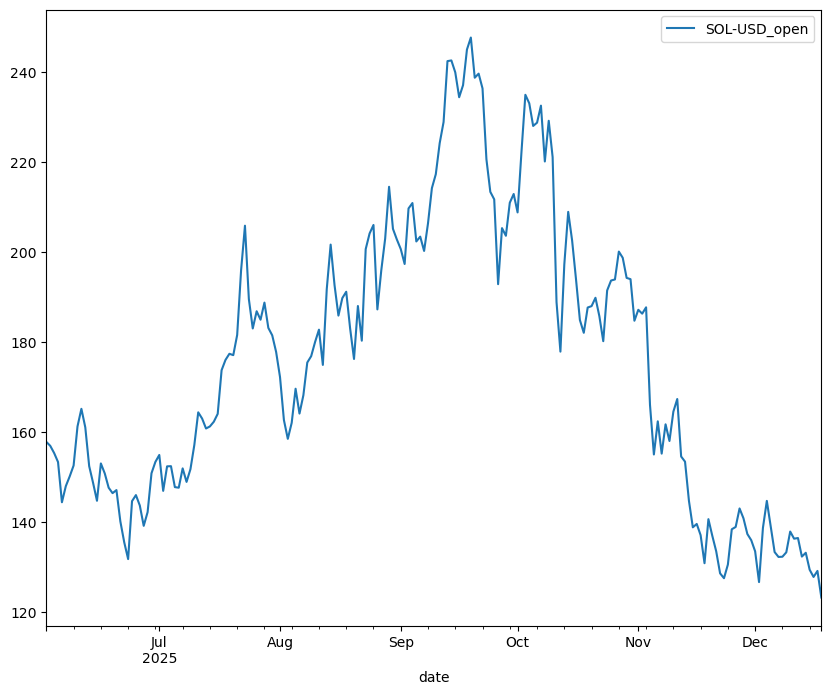

In [213]:
open_cols = [f'{ticker}_open' for ticker in ['SOL-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

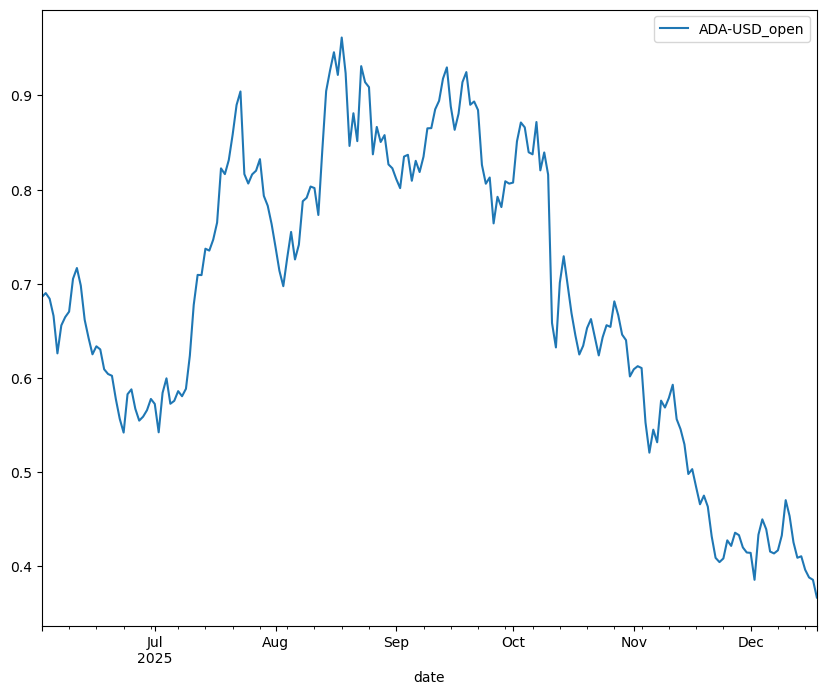

In [215]:
open_cols = [f'{ticker}_open' for ticker in ['ADA-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

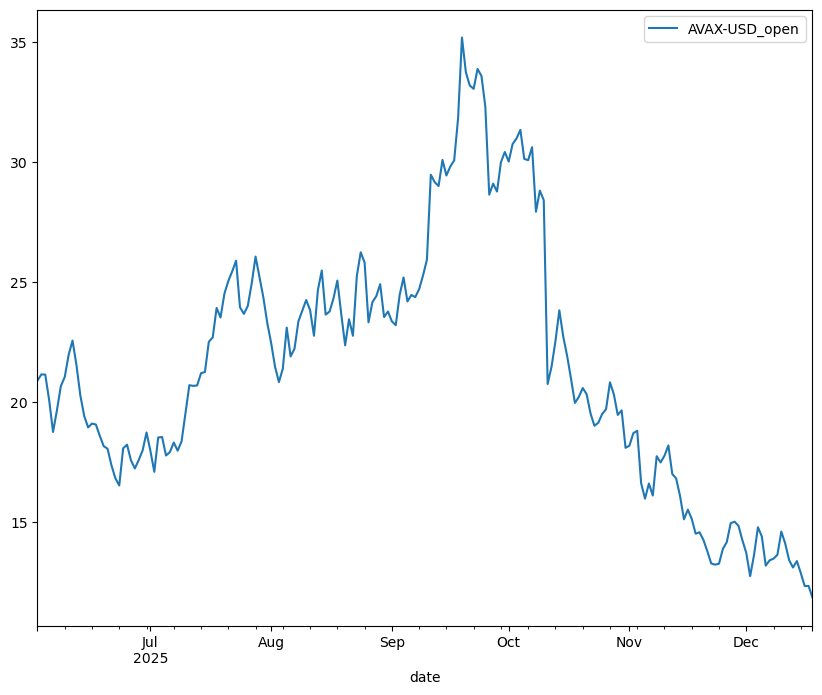

In [217]:
open_cols = [f'{ticker}_open' for ticker in ['AVAX-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))